# Imports

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm

# Config

In [2]:
reference_countries = [
    { 'country': 'Poland', 'province' : None },
    { 'country': 'China', 'province': 'Hubei'},
    { 'country': 'Korea, South', 'province': None },
    { 'country': 'Italy', 'province': None },
    { 'country': 'Germany', 'province': None },
    { 'country': 'Spain', 'province': None },
    { 'country': 'France', 'province': None },
    { 'country': 'US', 'province': 'New York' },
    { 'country': 'Japan', 'province': None },
    { 'country': 'Belarus', 'province': None },
]
other_countries = [
    { 'country': 'Czechia', 'province': None },
    { 'country': 'Slovakia', 'province': None },  
    { 'country': 'US', 'province': None},
    { 'country': 'US', 'province': 'New Jersey' },
    { 'country': 'Austria', 'province': None },
    { 'country': 'Switzerland', 'province': None },
    { 'country': 'Belgium', 'province': None },
    { 'country': 'Australia', 'province': None },
    { 'country': 'Canada', 'province': None },
    { 'country': 'Israel', 'province': None },
    { 'country': 'South Africa', 'province': None },
    { 'country': 'Turkey', 'province': None },
    { 'country': 'Iran', 'province': None },
    { 'country': 'Russia', 'province': None },
    { 'country': 'Belarus', 'province': None }
]

countries = reference_countries + other_countries
main_output_folder = 'output/covid/'
os.makedirs(main_output_folder, exist_ok=True)

str_format = '%Y-%m-%d'
kaggle_str_format = '%m/%d/%y'

# Read data & do basic preprocessing

In [3]:
def get_all_countries(folder='kaggle'):
    df = pd.read_csv(f"data\\{folder}\\time_series_covid_19_confirmed.csv")
    return df['Country/Region'].unique()

def get_all_country_provinces(country='Poland',folder='manual', file='time_series_covid_19_confirmed'):
    df = pd.read_csv(f"data\\{folder}\\{file}.csv")
    country_col = [c for c in ['Country/Region', 'Country_Region'] if c in df.columns][0]
    province_col = [c for c in ['Province/State', 'Province_State'] if c in df.columns][0]
    df = df[(df[country_col] == country) & df[province_col].notnull()]
    return df[province_col].unique()

def get_mask(df, country, province=None):
    country_col = [c for c in ['Country/Region', 'Country_Region'] if c in df.columns][0]
    province_col = [c for c in ['Province/State', 'Province_State'] if c in df.columns][0]
    
    mask = df[country_col] == country
    if province is None:
        no_province_mask = (df[country_col] == country) & df[province_col].isnull()
        if no_province_mask.sum() == 1:
            mask = no_province_mask
    else:
        mask = mask & (df[province_col] == province)
    return mask
    

def parse_data(country, province=None, 
               folder='kaggle', filename='time_series_covid_19_confirmed'):
    df = pd.read_csv(f"data\\{folder}\\{filename}.csv")
    mask = get_mask(df, country, province)
    if mask.sum() == 0:
        return None
    drop_cols_count = 0
    for col in df.columns:
        try:
            date = datetime.datetime.strptime(col, kaggle_str_format)
            break
        except ValueError:
            drop_cols_count = drop_cols_count + 1
    country_series = df[mask].sum()[drop_cols_count:]
    country_series = country_series[country_series > 0]
    df = pd.DataFrame({'count' : country_series.values, 'date' : country_series.index})
    df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, kaggle_str_format))
    df['date'] = df['date'].apply(lambda x: datetime.datetime.strftime(x, str_format))
    return df

def get_population(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    return df[mask]['Population'].sum()

def get_density(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    density = df['Population'].sum() / (df['Population']/df['Density (people/km2)']).sum()
    return density

def get_gdp_ppp(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    gdp = (df['Population'] * df['GDP per capita ($) (PPP)']).sum() / df['Population'].sum()
    return gdp

def get_gdp_nominal(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    gdp = (df['Population'] * df['GDP per capita ($) (nominal)']).sum() / df['Population'].sum()
    return gdp

def get_temperature(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    temperature = df['average yearly temperature (degree Celsius)'].mean()
    return temperature
    

def preprocess_data(df, population, min_count=100, min_count_per_million=10):
    if df.shape[0] == 0:
        return None
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame([[np.nan] * df.shape[1]] * 14, columns=df.columns)], ignore_index=True)
    df['count_per_million'] = df['count'] / (population / 10**6)
    
    if df['count'].max() < min_count or df['count_per_million'].max() < min_count_per_million:
        return None
    day_100 = df[df['count'] >= min_count].index[0]
    df = df.reset_index(drop=True)
    df['day_100'] = df.index - day_100
    day_1_per_million = df[df['count_per_million'] >= min_count_per_million].index[0]
    df['day_1_per_million'] = df.index - day_1_per_million
    return df

def read_preprocess_data(country, province, min_count=100, min_count_per_million=10, min_population=10**6):
    file_kwargs_list = [
        {'folder': 'manual'},
        {'folder': 'kaggle'},
        {'folder' : 'kaggle', 'filename' : 'time_series_covid_19_confirmed_US'}
    ]
    for file_kwargs in file_kwargs_list:
        df = parse_data(country, province, **file_kwargs)
        if df is not None:
            break
    population = get_population(country, province)
    if population < min_population:
        return None
    df = preprocess_data(df, population, min_count=min_count, min_count_per_million=min_count_per_million)
    return df

# Methods for analysis

In [4]:
def tau_2_grow_rate(tau):
    return math.pow(2, 1/tau) - 1
def grow_rate_2_tau(grow_rate):
    return 1 / (math.log(1 + grow_rate, 2) + 10**(-6))
def get_exp_func(df, day, tau):
    N_day = df.loc[day]['count']
    N_0 = N_day / math.pow(2, day/tau)
    return pd.Series(df.index.map(lambda x: N_0 * math.pow(2, x/tau)), index=df.index)
def add_exp_func(df, day, tau, info):
    grow_rate = tau_2_grow_rate(tau)
    col_prefix = f'doubles every {tau} days (daily increase {100*grow_rate:.0f}%)'
    col = f'{col_prefix} d={day}'
    if info:
        col = f'{col}\n({info})'
    df[col] = get_exp_func(df, day, tau)
    return col_prefix, col

def get_week_end_day(day):
    return (math.floor(day/7) + 1) * 7 - 1

def analyze_df(df, index_col='day_100', min_count=100):
    df.index = df[index_col]
    df.index.name = 'day'
    df['week'] = df.index.map(lambda x: math.floor(x / 7))
    df['increase'] = df['count'] - df['count'].shift(1)
    for i in [1,2,3,4,5,6,7,14]:
        df[f'grow_rate_{i}'] = np.power(df['count'] / df['count'].shift(i), 1/i) - 1
    grow_rate_cols = [f'grow_rate_{i}' for i in range(7,0,-1)]
    df[f'grow_rate_by_week'] = df[df['count'].notnull()]['week'].apply(
        lambda x: df[(df['week'] == x) & df['count'].notnull()].tail(1)).apply(
        lambda x: x[[f'grow_rate_{i}' for i in range(x.index[0] % 7 + 1,0,-1)]].values[0] if x.shape[0] > 0 else []).apply(
        lambda x: [y for y in x if not np.isnan(y)]).apply(
        lambda x: x[0] if len(x) > 0 else np.nan
    )
    tau_cols = []
    tau_cols_prefixes = []
    day_last = df[df['count'].notnull()].index[-1]
    day_prev = df[df['count'].notnull()].index[-2]
    day_100 =df[df['count'] >= min_count].index[0]
    day_100_3 = day_100 + 3
    tau_35_grow_rate = round(grow_rate_2_tau(0.35), 2)
    shift = 7
    day = day_100_3
    day_tau_list = []
    prev_grow_rate = None
    while day < day_prev - shift or day == day_100_3:
        grow_rate = df['grow_rate_3'].loc[day]
        if prev_grow_rate is None or abs(prev_grow_rate - grow_rate) >= 0.01:
            prev_grow_rate = grow_rate
            tau =  round(grow_rate_2_tau(grow_rate),2)
            day_tau_list.append((day, tau,'smoothened over 3 days'))
        day = day + shift
    prev_tau_3 = round(grow_rate_2_tau(df['grow_rate_3'].loc[day_prev]), 2)
    day_tau_list.append((day_prev, prev_tau_3,f'smoothened over 3 days, upto {df.loc[day_prev]["date"]}'))
    if df['increase'].loc[day_last] > 0:
        curr_tau = round(grow_rate_2_tau(df['grow_rate_1'].loc[day_last]),2)
        curr_tau_3 = round(grow_rate_2_tau(df['grow_rate_3'].loc[day_last]),2)
        day_tau_list.extend([
            (day_last, curr_tau_3,f'smoothened over 3 days, upto {df.loc[day_last]["date"]}'),
            (day_last, curr_tau,f'smoothened over 1 day, upto {df.loc[day_last]["date"]}'),
        ])
    for day, tau, info in day_tau_list:
            col_prefix, col = add_exp_func(df, day, tau, info)
            tau_cols.append(col)
            tau_cols_prefixes.append(col_prefix)
    return df, tau_cols, tau_cols_prefixes

# Methods for plotting

In [5]:
def get_label(country, province, separator=', '):
    label = country
    if province is not None:
        label = f"{province}{separator}{label}"
    label = label.replace('*','')
    return label
def reduce_xticks(ax, data_points_count):
    if data_points_count < 30:
        return
    elif data_points_count < 50:
        n = 5
    else:
        n = 10
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    offset = (n - (int(ticklabels[0]) % n))
    ax.xaxis.set_ticks(ticks[offset::n])
    ax.xaxis.set_ticklabels(ticklabels[offset::n])

def plot_daily_increase(df, ax):
    df = df[df['increase'].notnull()]
    df['increase'].plot(kind='bar', 
                                              ax=ax, 
                                              label='new cases count')
    add_day_labels(df, ax, offset=-df.index[0])
    ax.set_ylabel('count')
    reduce_xticks(ax, df.shape[0])
    ax.legend()  
    ax.set_title('New cases count - daily increase count (linear scale)')

def plot_count(df, ax):
    df = df[df['count'].notnull()]
    df['count'].plot(kind='bar', 
                                              ax=ax, 
                                              label='infected count')
    add_day_labels(df, ax, offset=-df.index[0])
    ax.set_ylabel('count')
    reduce_xticks(ax, df.shape[0])
    ax.legend()  
    ax.set_title('Infected count (linear scale)')    

def add_day_labels(df, ax, offset=0):
    day_100_date_str = df[df['count'] >= 100]['date'].iloc[0]
    day_100_label = f'{day_100_date_str}, day 0, 100 cases reached'
    ax.axvline(0 + offset, label=day_100_label, color='black', alpha=0.7)
    
    day_last_date_str = df[df['count'].notnull()]['date'].iloc[-1]
    day_count = df[df['count'].notnull()].index[-1]
    day_last_label = f'{day_last_date_str}, day {day_count}, current date'
    ax.axvline(day_count + offset, label=day_last_label, color='black', alpha=0.7)
    
def plot_grow_rate(df, ax, day_offset=0):
    df = df[day_offset:]
    for i in [1, 3]:
        (df[f'grow_rate_{i}'] * 100).plot(ax=ax, 
                                          label=f'daily increase (%) (smoothened over {i} days)',
                                          marker='o',# if i is 1 else None,
                                          grid=True
                                         )
    add_day_labels(df, ax)
    ax.set_ylabel('daily increase %')
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], df['grow_rate_3'].max() * 100 + 10))
    ax.set_title('daily increase %')

def plot_log_count(df, ax, tau_cols, tau_cols_prefixes):
    df[['count']].plot(ax=ax, logy=True, lw=4, marker='o', markersize=8, grid=True)
    cmap = plt.get_cmap('jet_r')
    i = 0
    colors = ['orange', 'purple', 'green', 'red', 'cyan', 'magenta']
    if tau_cols is not None:
        for prefix in tau_cols_prefixes:
            color = colors[i % len(colors)]
            i = i + 1
            cols = [c for c in tau_cols if c.startswith(prefix)]
            df[cols].plot(ax=ax, logy=True, style=['--', ':'], color=color, grid=True)
    add_day_labels(df, ax)
    ax.set_ylim((1, df['count'].max() * 10**2))
    ax.set_ylabel('count')
    ax.legend(loc='best')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Infected count (logarithmic scale)')

markers = ['o', 'v', '^', 's', '*']

def plot_log_count_all(countries, ax, max_days=None):
    for i, country in enumerate(countries):
        label = get_label(country['country'], country['province']) 
        df = country['df']
        day_offset=df.index.get_loc(0)
        df = df[day_offset:]
        if max_days is not None:
            df = df[:max_days]
        df['count_per_million'].plot(
            ax=ax, 
            logy=True, 
            lw=2, 
            markersize=8, 
            grid=True,
            label=label,
            marker=markers[int(i/5) % len(markers)]
        )
    
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    ax.set_ylabel('count per million inhabitants')
    title = 'Infected count per million inhabitants (logarithmic scale)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    ax.legend()
    
def plot_grow_rate_all(countries, ax, max_days=None):
    for i, country in enumerate(countries):
        df = country['df']
        day_offset=df.index.get_loc(0)
        df = df[day_offset:]
        if max_days is not None:
            df = df[:max_days]
        label = get_label(country['country'], country['province'])
        (df['grow_rate_by_week'] * 100).plot(
            ax=ax, 
            label=label,
            grid=True,
            lw=2,
            markersize=8, 
            marker=markers[int(i/5) % len(markers)]
        )
    ax.set_ylabel('daily increase %')
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], 100))
    title = f'daily increase (%) (week by week)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    
def plot_country_report(df, country, province, tau_cols, tau_cols_prefixes):
    fig = plt.figure(figsize=(16,24))
    title = 'COVID-19 in ' + get_label(country, province)
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(5,2)

    ax = fig.add_subplot(gs[0, 0])
    plot_count(df, ax)
    
    ax = fig.add_subplot(gs[0, 1])
    plot_daily_increase(df, ax)
    
    ax = fig.add_subplot(gs[1:3, :])
    plot_log_count(df, ax, tau_cols, tau_cols_prefixes)
    
    ax = fig.add_subplot(gs[3:4,:])
    plot_grow_rate(df, ax, day_offset=df.index.get_loc(0))
    return fig
    
def plot_all_country_report(countries, smooth_period, max_days=None, title=None):
    fig = plt.figure(figsize=(16,24))
    if title is None:
        title = 'COVID-19 around the world'
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(4,2)
    ax = fig.add_subplot(gs[0:2, :])
    plot_log_count_all(countries, ax,  max_days=max_days)
    ax = fig.add_subplot(gs[2:4,:])
    plot_grow_rate_all(countries, ax,  max_days=max_days)
    return fig

def read_data_plot_country(country, province, output_folder='by_country/'):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    print(country, province)
    df = read_preprocess_data(country, province)
    df, tau_cols, tau_cols_prefixes = analyze_df(df, index_col='day_100')
    label = get_label(country, province, separator='_')
    file_name = f'{output_folder}{label}_covid_analysis.xlsx'
    df.to_excel(file_name)
    print(f'Saved analysis to: {file_name}')
    fig = plot_country_report(df, country, province, tau_cols, tau_cols_prefixes)
    plt.show()
    fig_file_name = f'{output_folder}{label}_covid_plot.jpeg'
    fig.savefig(fig_file_name)
    print(f'Saved analysis to: {fig_file_name}')
    
def get_country_info(df, country, province, smooth_period, min_count_per_million=10):
    df = df[df['count'].notnull()]
    country_info = {
    'infected count' : int(df['count'].iloc[-1]),
    'infected count per million' : int(df['count_per_million'].iloc[-1]),
    'current date':df['date'].iloc[-1],
    f'daily increase % (smoothened over last {smooth_period} days)': round(df[f'grow_rate_{smooth_period}'].iloc[-2],3),
    'doubles every ... days': round(grow_rate_2_tau(df[f'grow_rate_{smooth_period}'].iloc[-2]),2),
    'days since at least 1 per million infected': df.index[-1],
    f'days between 1st case and at least {min_count_per_million} per million infected': -df.index[0],
    'population (million)': round(get_population(country, province)/10**6,1),
    'density (people per km2)': round(get_density(country, province),1),
    'GDP per capita ($) (PPP)': round(get_gdp_ppp(country, province),0),
    'GDP per capita ($) (nominal)': round(get_gdp_nominal(country, province),0),
    'average yearly temperature (degree Celsius)': round(get_temperature(country, province),1)
    }
    for week in sorted(df['week'].unique()):
        if week >= 0:
            week_df = df[df['week'] == week]
            if week_df.shape[0] == 7:
                country_info[f'daily increase % week_{week}'] = round(week_df['grow_rate_by_week'].iloc[-1],3)
                country_info[f'infected count per million week_{week}'] = int(week_df['count_per_million'].iloc[-1])
    return pd.Series(country_info)

def get_max_day(countries):
    return max([c['df'][c['df']['count'].notnull()].index[-1] for c in countries])

def get_corr(countries, smooth_period):
    pre_corr_df = pd.DataFrame()
    max_day = get_max_day(countries)
    for day in range(max_day + 1):
        counts = []
        grow_rates = []
        for country in countries:
            df = country['df']
            count = df['count_per_million'].loc[day] if day in df.index else np.nan
            grow_rate = df[f'grow_rate_{smooth_period}'].loc[day] if day in df.index else np.nan
            counts.append(count)
            grow_rates.append(grow_rate)
        pre_corr_df[f'count_{day}'] = counts
        pre_corr_df[f'grow_rate_{smooth_period}_{day}'] = grow_rates
    return pre_corr_df.corr()

def read_data_plot_countries(countries, min_count=100, min_count_per_million=10, max_days=40,
                             output_folder='reference_countries_comparison/', title=None):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    smooth_period  = 7
    for country in tqdm(countries):
        df = read_preprocess_data(country['country'], country['province'], 
                                  min_count=min_count, 
                                  min_count_per_million=min_count_per_million)
        if df is None:
            continue
        df, tau_cols, tau_cols_prefixes = analyze_df(df, 
                                                     index_col='day_1_per_million',
                                                     min_count=min_count)
        country['df'] = df
        country['info'] = get_country_info(df, country['country'], country['province'], smooth_period,
                                           min_count_per_million=min_count_per_million
                                          )
    countries = [c for c in countries if 'df' in c]
    country_df = pd.DataFrame([c['info'] for c in countries], 
                              index=[get_label(c['country'],c['province']) for c in countries])
    country_df.sort_values('infected count per million', ascending=False, inplace=True)
    for c in countries:
        country = c["country"]
        province = c["province"]
        label = get_label(country, province, separator='_')
        file_name = f'{output_folder}{label}_covid_analysis.xlsx'
        c["df"].to_excel(file_name)
    file_name = f'{output_folder}countries_comparison.xlsx'
    country_df.to_excel(file_name)
    display(country_df)
    print(f'Saved analysis to: {file_name}')
    fig = plot_all_country_report(countries, smooth_period, max_days=max_days, title=title)
    plt.show()
    fig_file_name = f'{output_folder}covid_plot.jpeg'
    fig.savefig(fig_file_name)
    print(f'Saved analysis to: {fig_file_name}')
    return country_df

def read_data_correlate_countries(countries,
                                  min_count=100,
                                  min_count_per_million=10,
                                  min_population=10**6,
                                 output_folder='all_countries_correlations/'):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    smooth_period  = 7
    for country in tqdm(countries):
#         print(country)
        df = read_preprocess_data(country['country'], country['province'], 
                                  min_count=min_count, 
                                  min_count_per_million=min_count_per_million,
                                  min_population=min_population
                                 )
        if df is None:
            continue
        df, tau_cols, tau_cols_prefixes = analyze_df(df, index_col='day_1_per_million')
        country['df'] = df
        country['info'] = get_country_info(df, country['country'], country['province'], smooth_period)
    countries = [ c for c in countries if 'df' in c]
    country_df = pd.DataFrame([c['info'] for c in countries], 
                              index=[get_label(c['country'],c['province']) for c in countries])
    country_df.sort_values('infected count per million', ascending=False, inplace=True)
    for c in countries:
        country = c["country"]
        province = c["province"]
        label = get_label(country, province, separator='_')
        file_name = f'{output_folder}{label}_covid_analysis.xlsx'
        c["df"].to_excel(file_name)
    country_df = country_df[country_df['population (million)'] >= 1]
    file_name = f'{output_folder}all_countries_comparison.xlsx'
    country_df.to_excel(file_name)
    display(country_df)
    print(f'Saved analysis to: {file_name}')
    for week in [2]:
        y_cols = [
            f'daily increase % week_{w}' for w in range(week - 1,-1,-1)] + [
            f'days between 1st case and at least {min_count_per_million} per million infected',
            'population (million)',
            'density (people per km2)', 
            'GDP per capita ($) (PPP)',
            'GDP per capita ($) (nominal)',
            'average yearly temperature (degree Celsius)'
        ]
        x_cols = [f'infected count per million week_{week}', f'daily increase % week_{week}']
        cols = x_cols + y_cols
        corr_df = country_df[x_cols + y_cols].corr()[x_cols]
        corr_df.to_excel(f'{output_folder}all_countries_correlations_week_{week}.xlsx')
        display(corr_df)

        for x_col in corr_df.columns:
            for y_col in corr_df.index:
                correlation = corr_df.loc[y_col,x_col]
                if 0.2 <= abs(correlation) < 1.0:
                    country_df.plot(x=x_col, y=y_col, style='o', label='country')
                    plt.ylabel(y_col)
                    plt.savefig(f'{output_folder}{x_col}{y_col}_correlation.jpeg')
                    plt.show()
        for x_col in x_cols:
            country_df[x_col].hist(label=x_col)
            plt.legend()
            plt.savefig(f'{output_folder}{x_col}_hist.jpeg')
            plt.show()
    return country_df

# Per country analysis

Poland None
Saved analysis to: output/covid/by_country/Poland_covid_analysis.xlsx


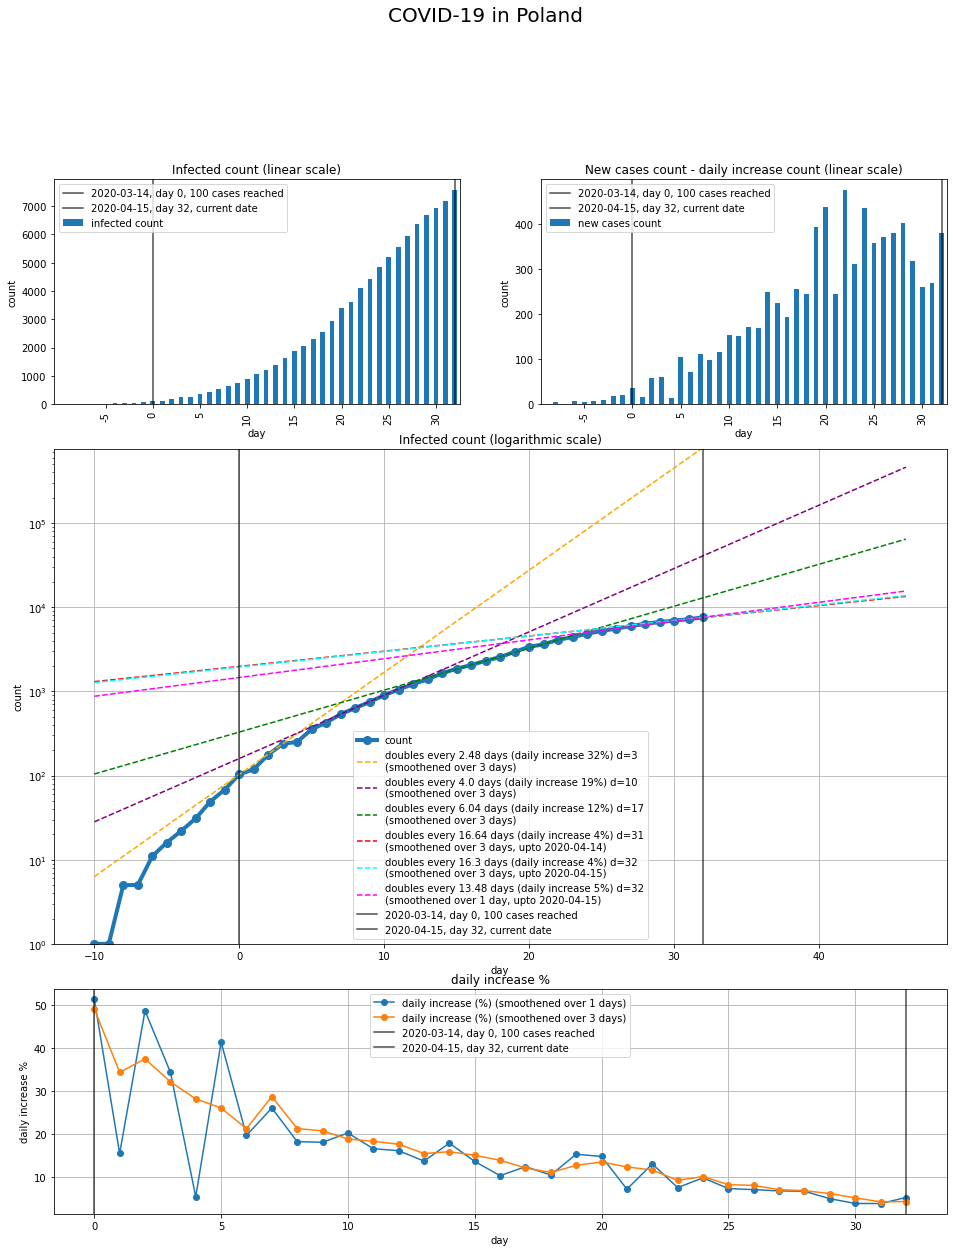

Saved analysis to: output/covid/by_country/Poland_covid_plot.jpeg
China Hubei
Saved analysis to: output/covid/by_country/Hubei_China_covid_analysis.xlsx


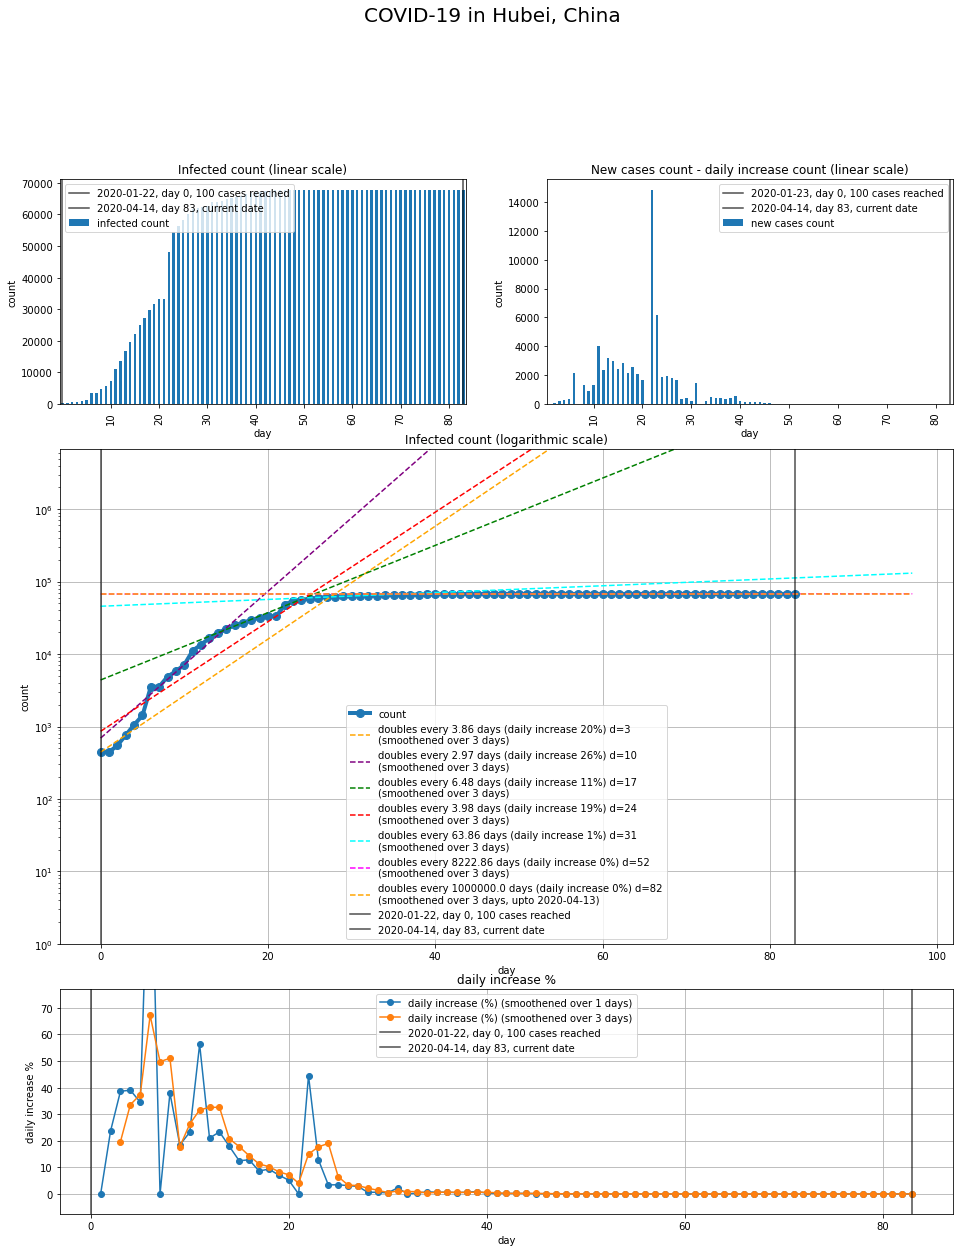

Saved analysis to: output/covid/by_country/Hubei_China_covid_plot.jpeg
Korea, South None
Saved analysis to: output/covid/by_country/Korea, South_covid_analysis.xlsx


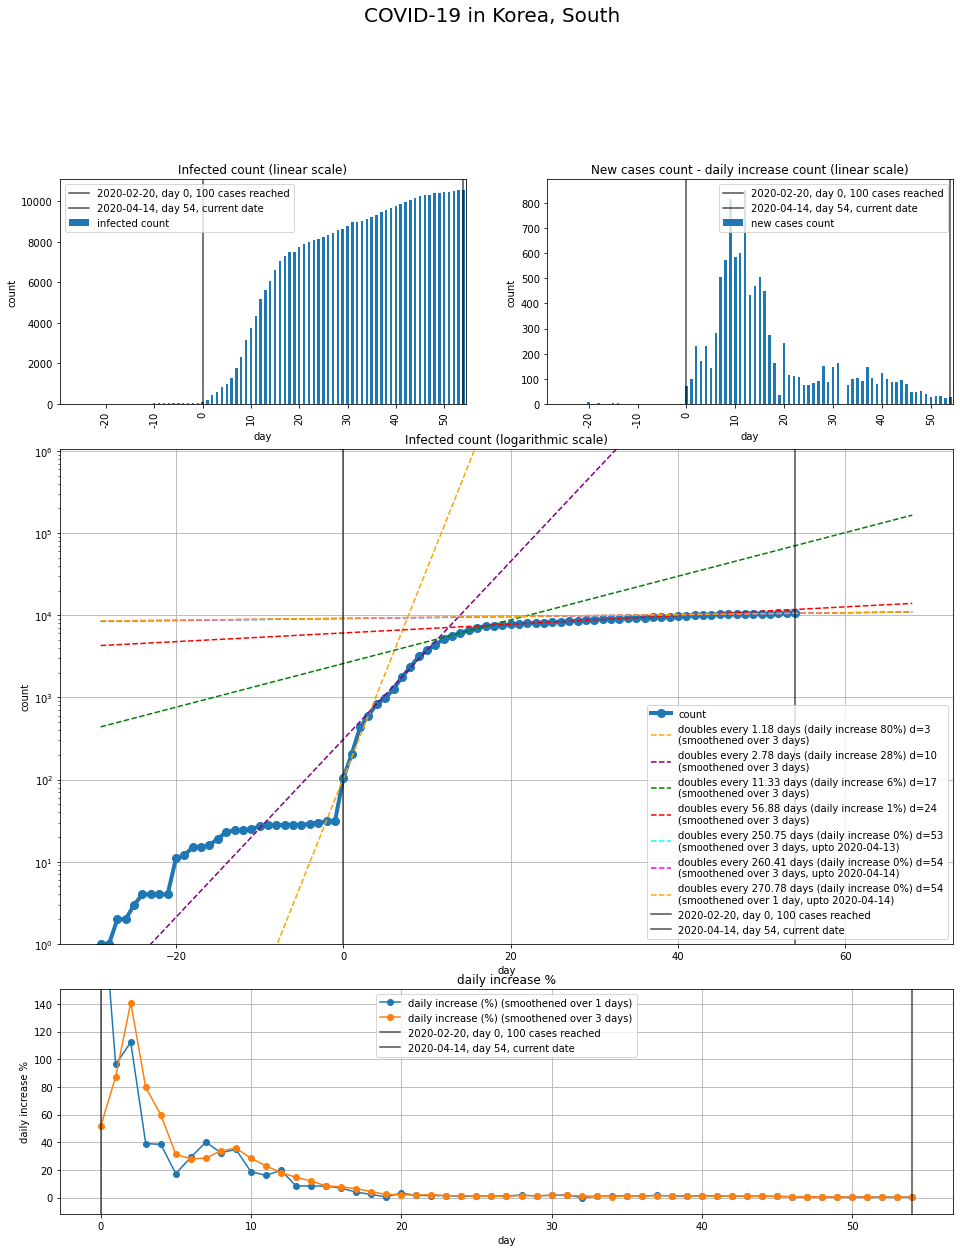

Saved analysis to: output/covid/by_country/Korea, South_covid_plot.jpeg
Italy None
Saved analysis to: output/covid/by_country/Italy_covid_analysis.xlsx


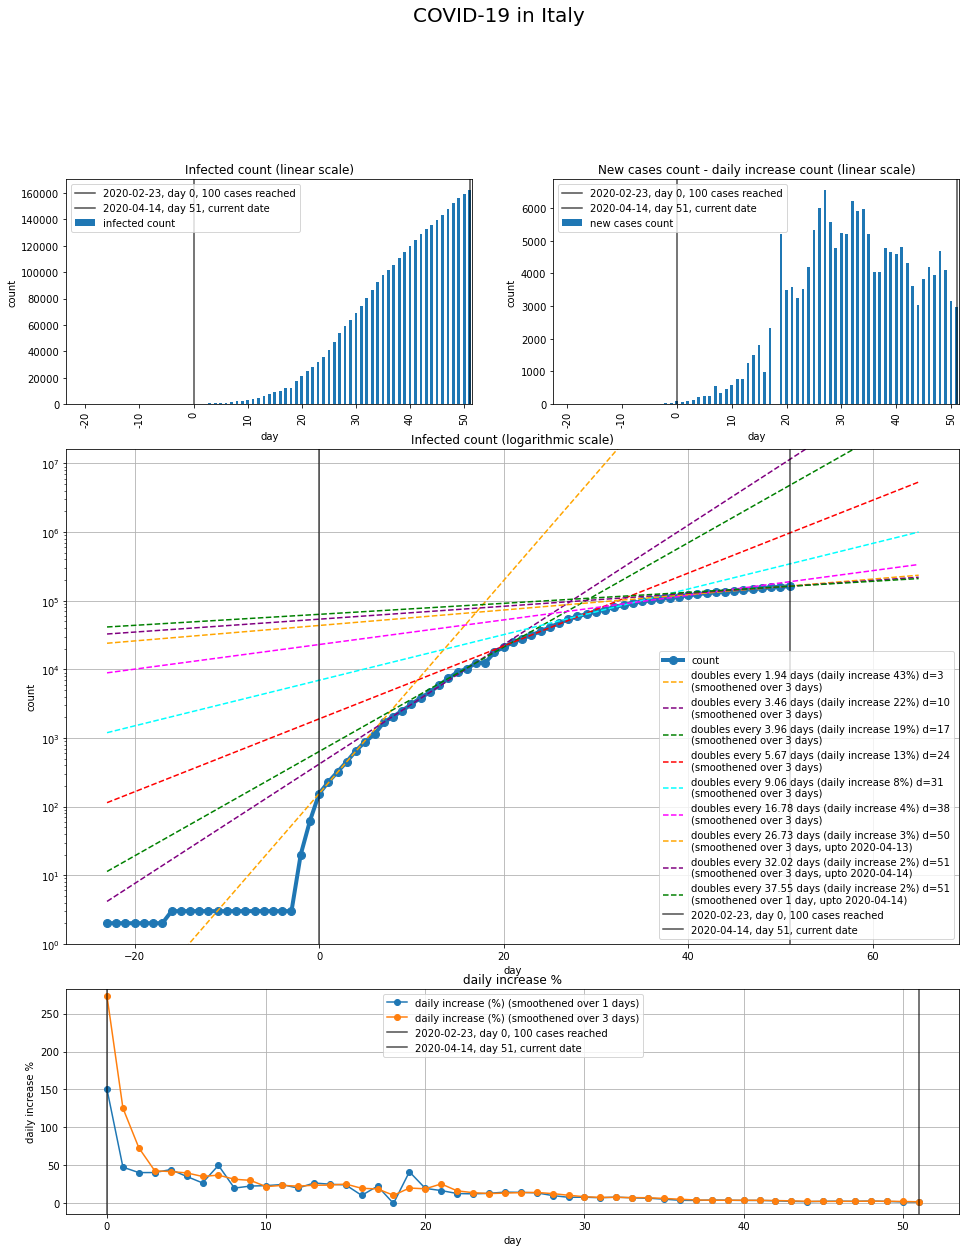

Saved analysis to: output/covid/by_country/Italy_covid_plot.jpeg
Germany None
Saved analysis to: output/covid/by_country/Germany_covid_analysis.xlsx


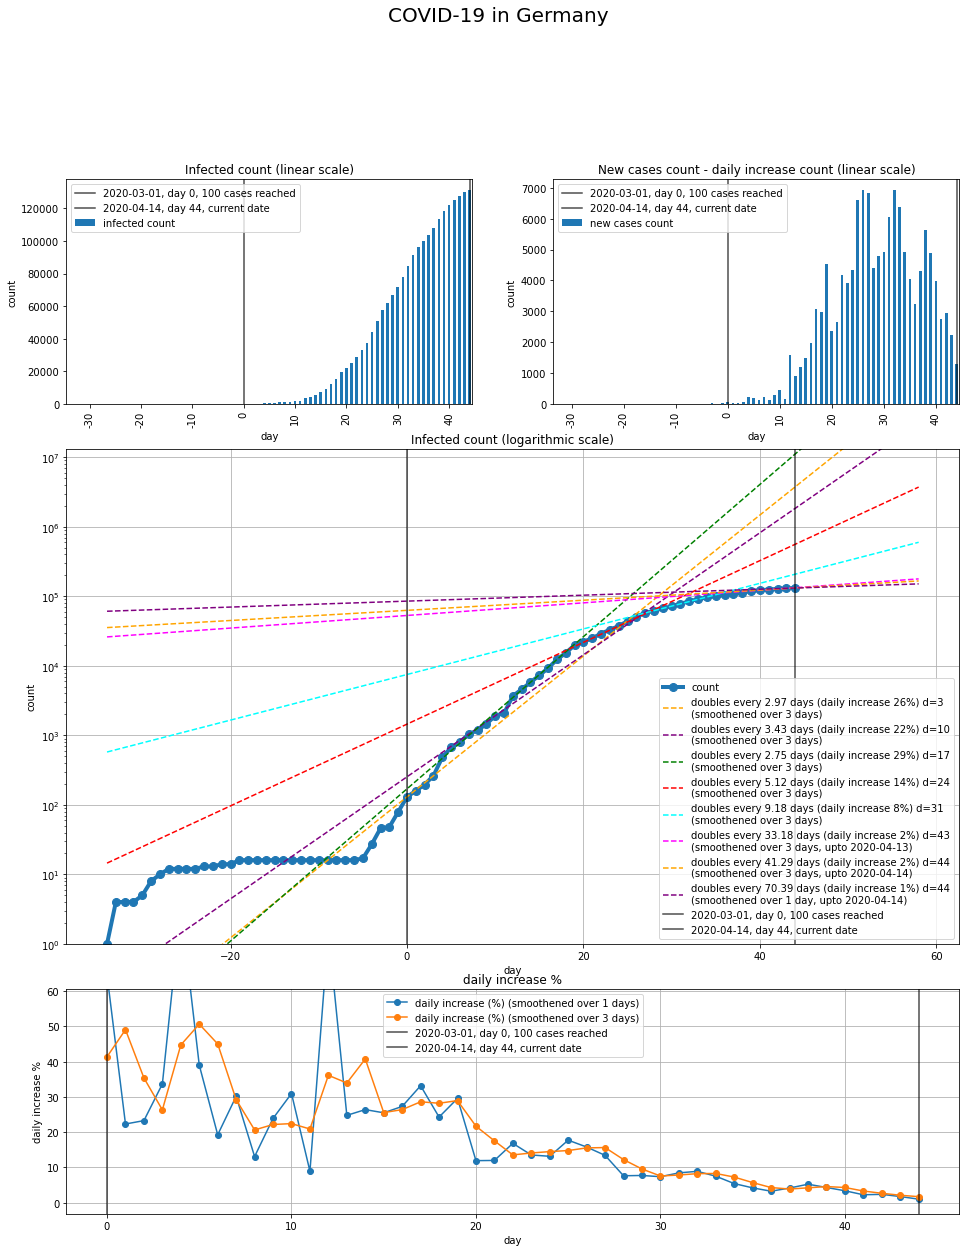

Saved analysis to: output/covid/by_country/Germany_covid_plot.jpeg
Spain None
Saved analysis to: output/covid/by_country/Spain_covid_analysis.xlsx


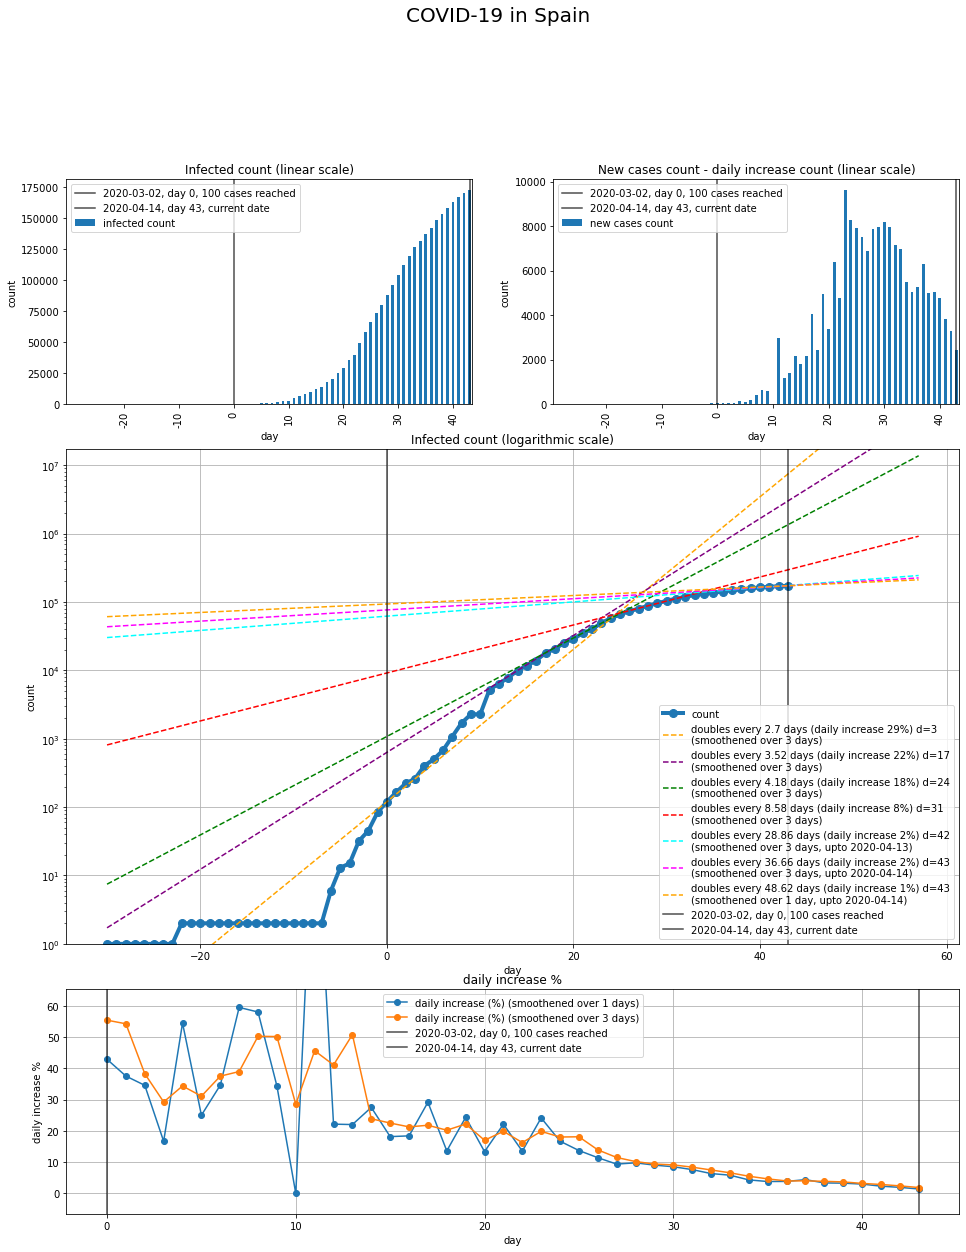

Saved analysis to: output/covid/by_country/Spain_covid_plot.jpeg
France None
Saved analysis to: output/covid/by_country/France_covid_analysis.xlsx


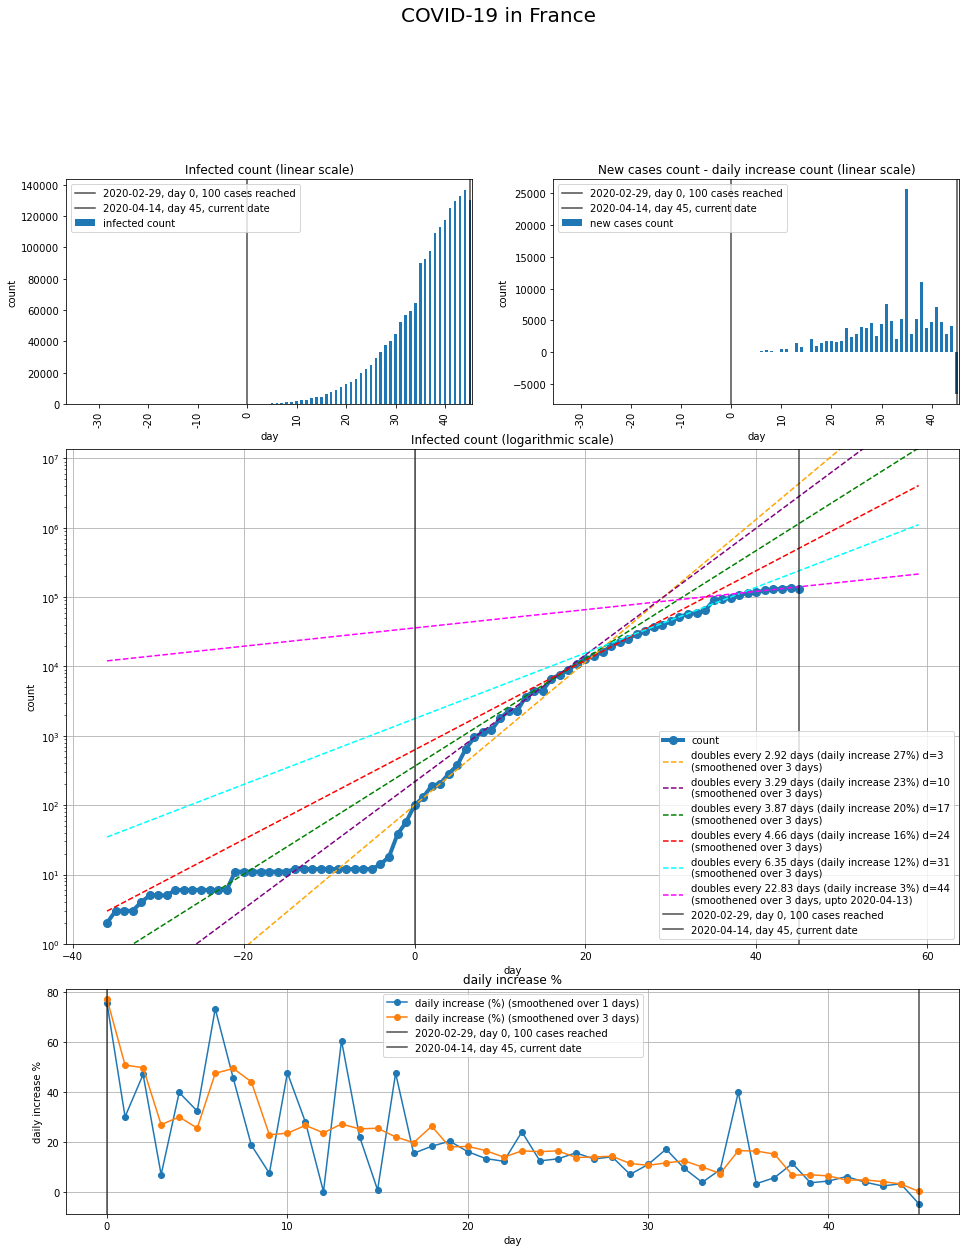

Saved analysis to: output/covid/by_country/France_covid_plot.jpeg
US New York
Saved analysis to: output/covid/by_country/New York_US_covid_analysis.xlsx


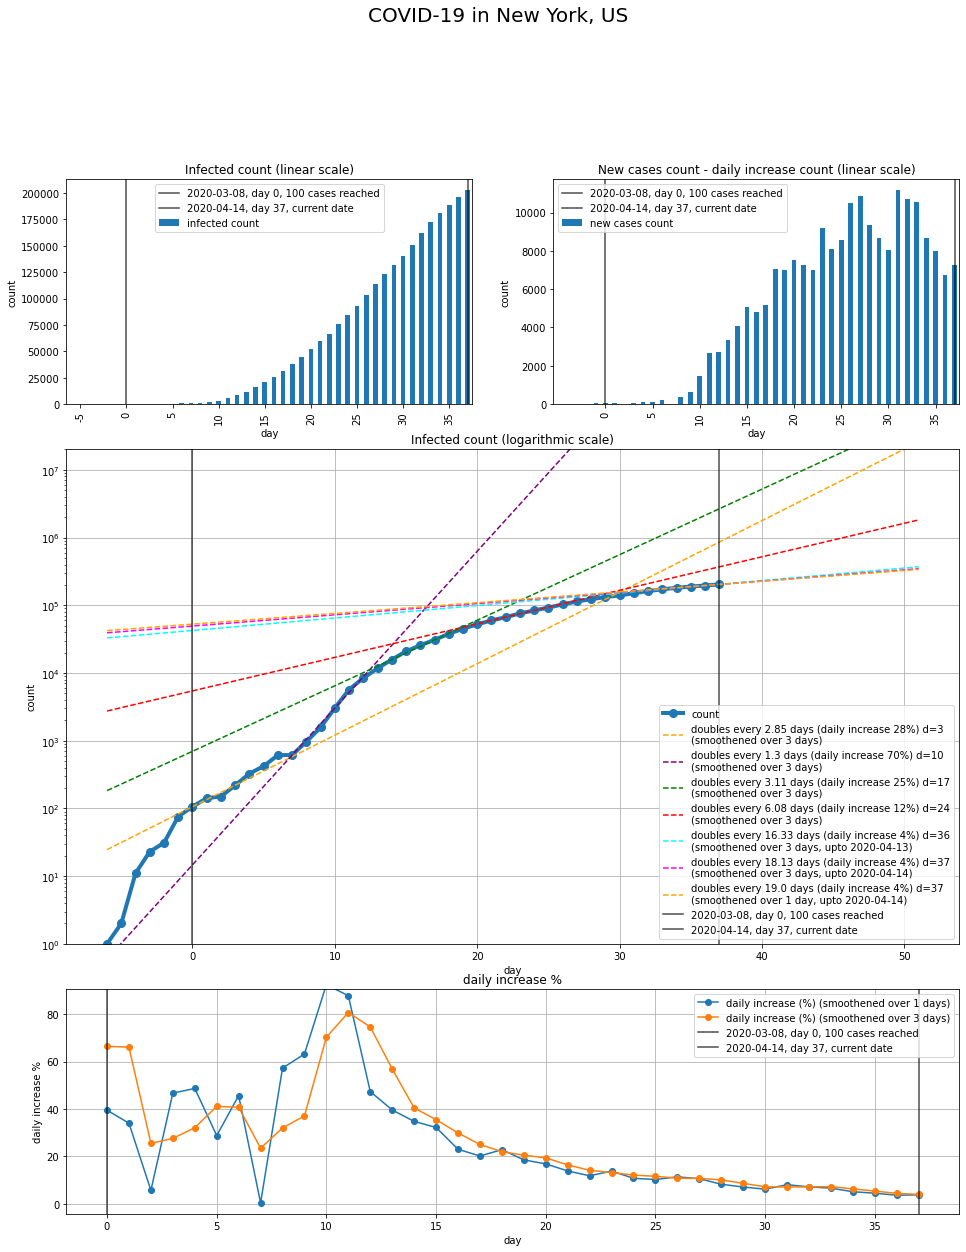

Saved analysis to: output/covid/by_country/New York_US_covid_plot.jpeg
Japan None
Saved analysis to: output/covid/by_country/Japan_covid_analysis.xlsx


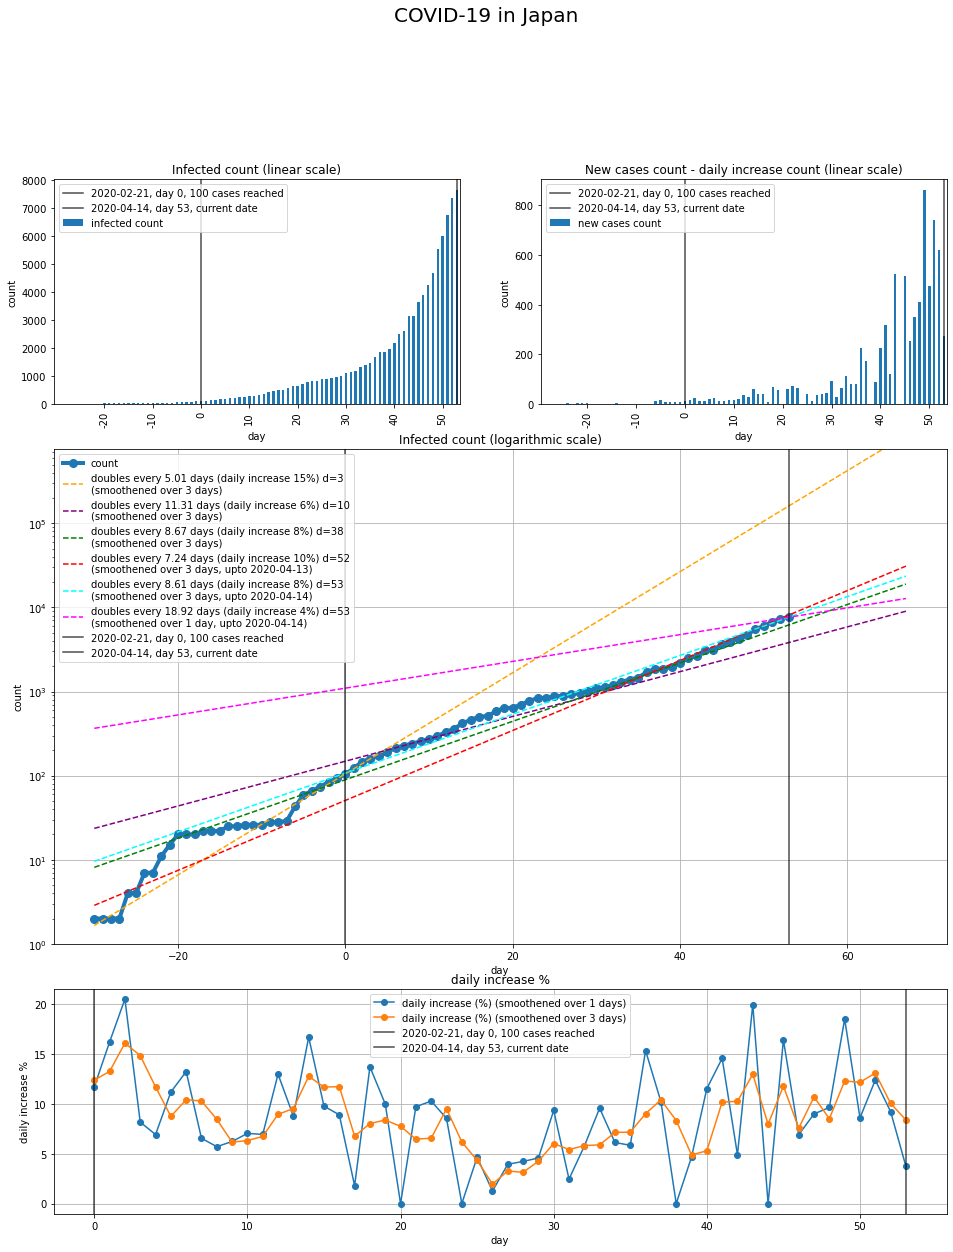

Saved analysis to: output/covid/by_country/Japan_covid_plot.jpeg
Belarus None
Saved analysis to: output/covid/by_country/Belarus_covid_analysis.xlsx


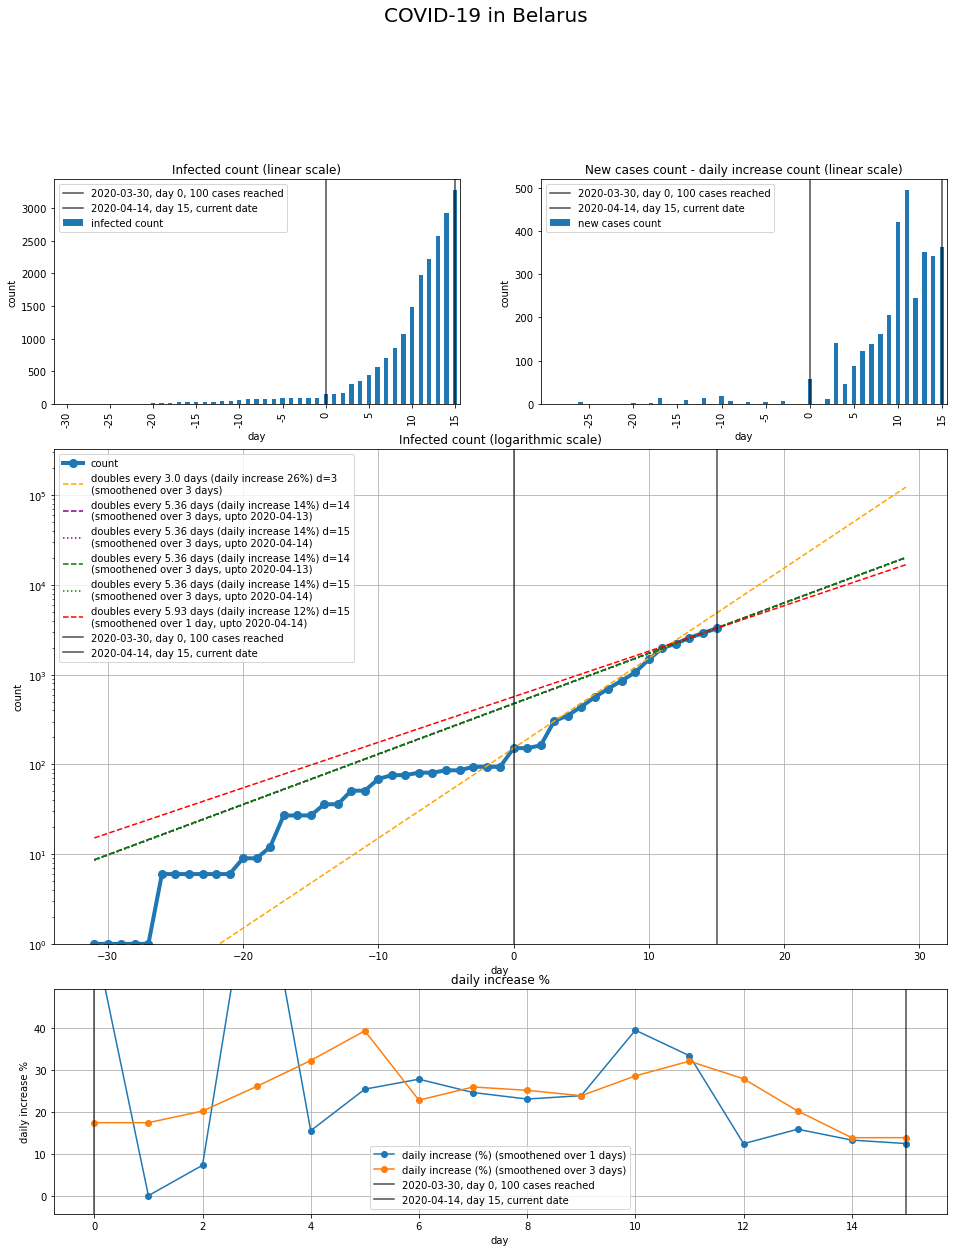

Saved analysis to: output/covid/by_country/Belarus_covid_plot.jpeg
Czechia None
Saved analysis to: output/covid/by_country/Czechia_covid_analysis.xlsx


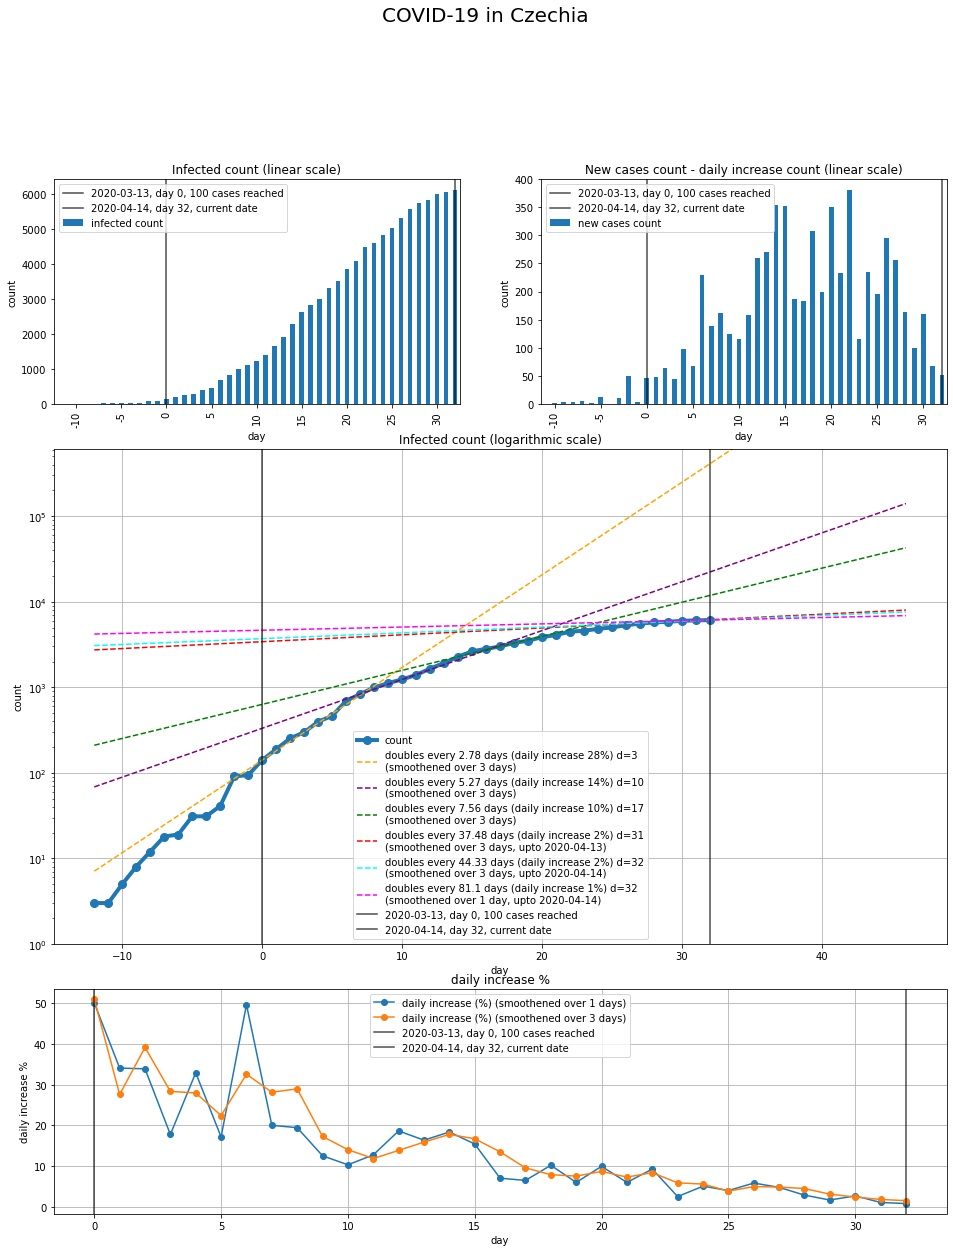

Saved analysis to: output/covid/by_country/Czechia_covid_plot.jpeg
Slovakia None
Saved analysis to: output/covid/by_country/Slovakia_covid_analysis.xlsx


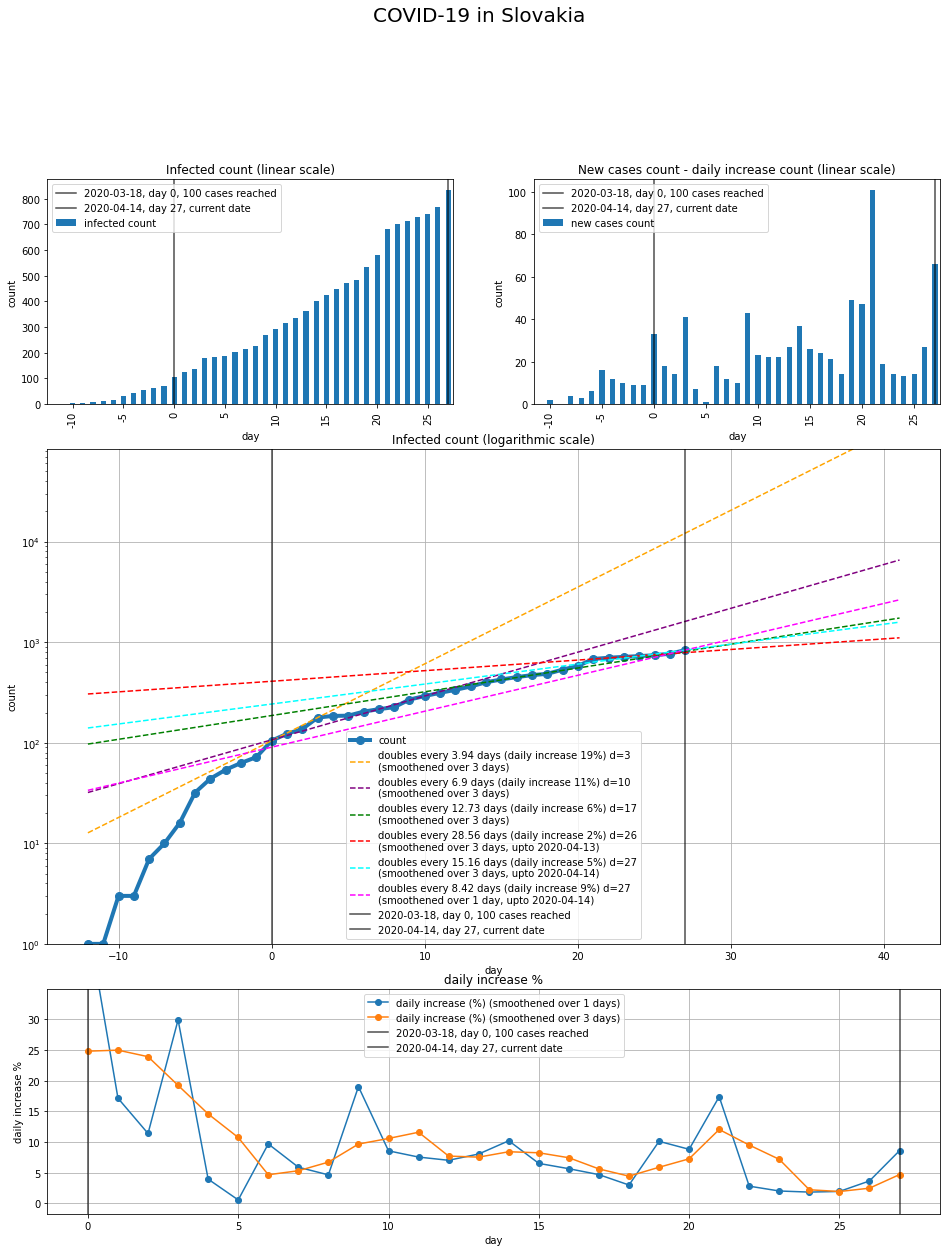

Saved analysis to: output/covid/by_country/Slovakia_covid_plot.jpeg
US None
Saved analysis to: output/covid/by_country/US_covid_analysis.xlsx


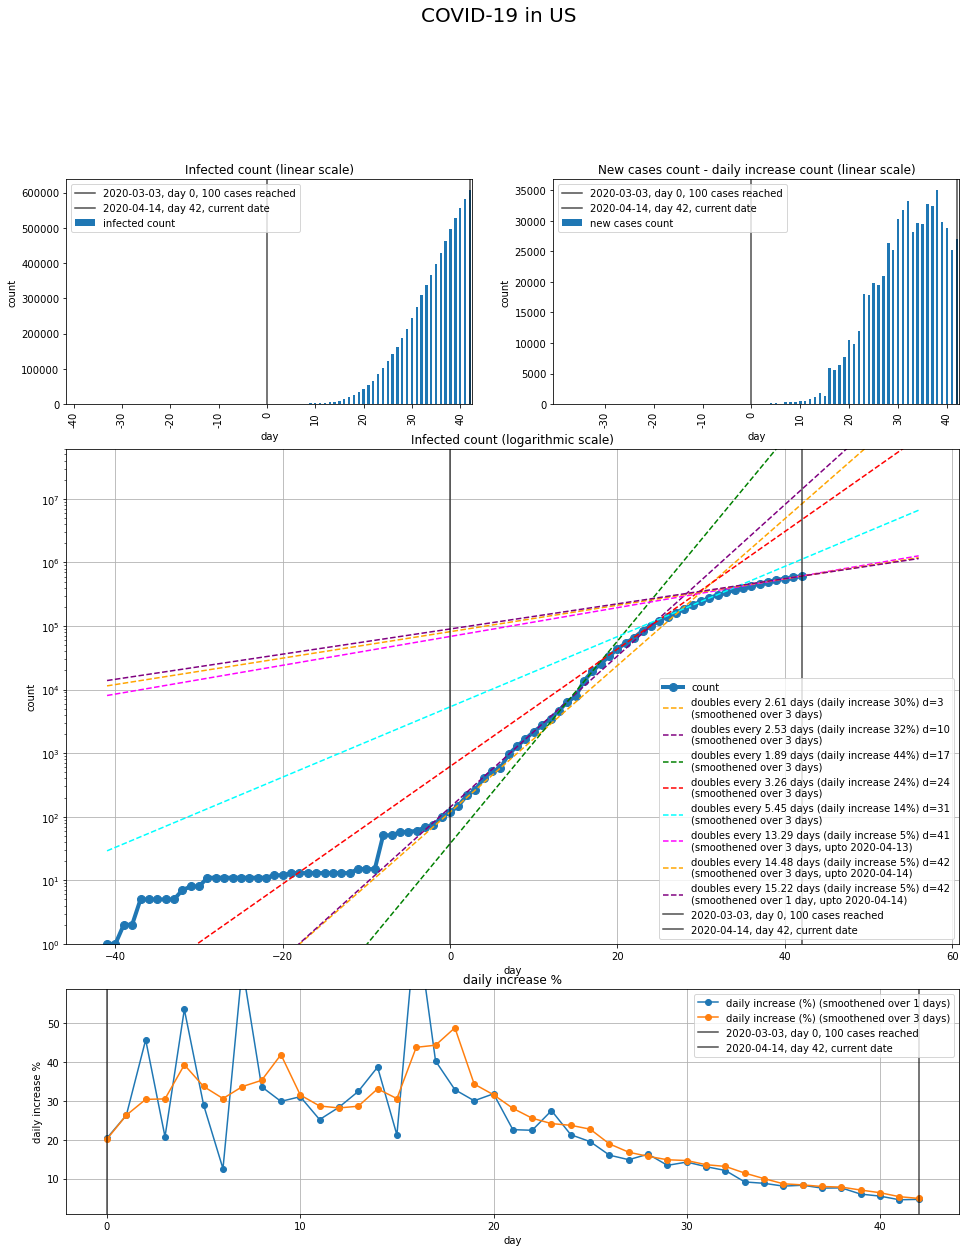

Saved analysis to: output/covid/by_country/US_covid_plot.jpeg
US New Jersey
Saved analysis to: output/covid/by_country/New Jersey_US_covid_analysis.xlsx


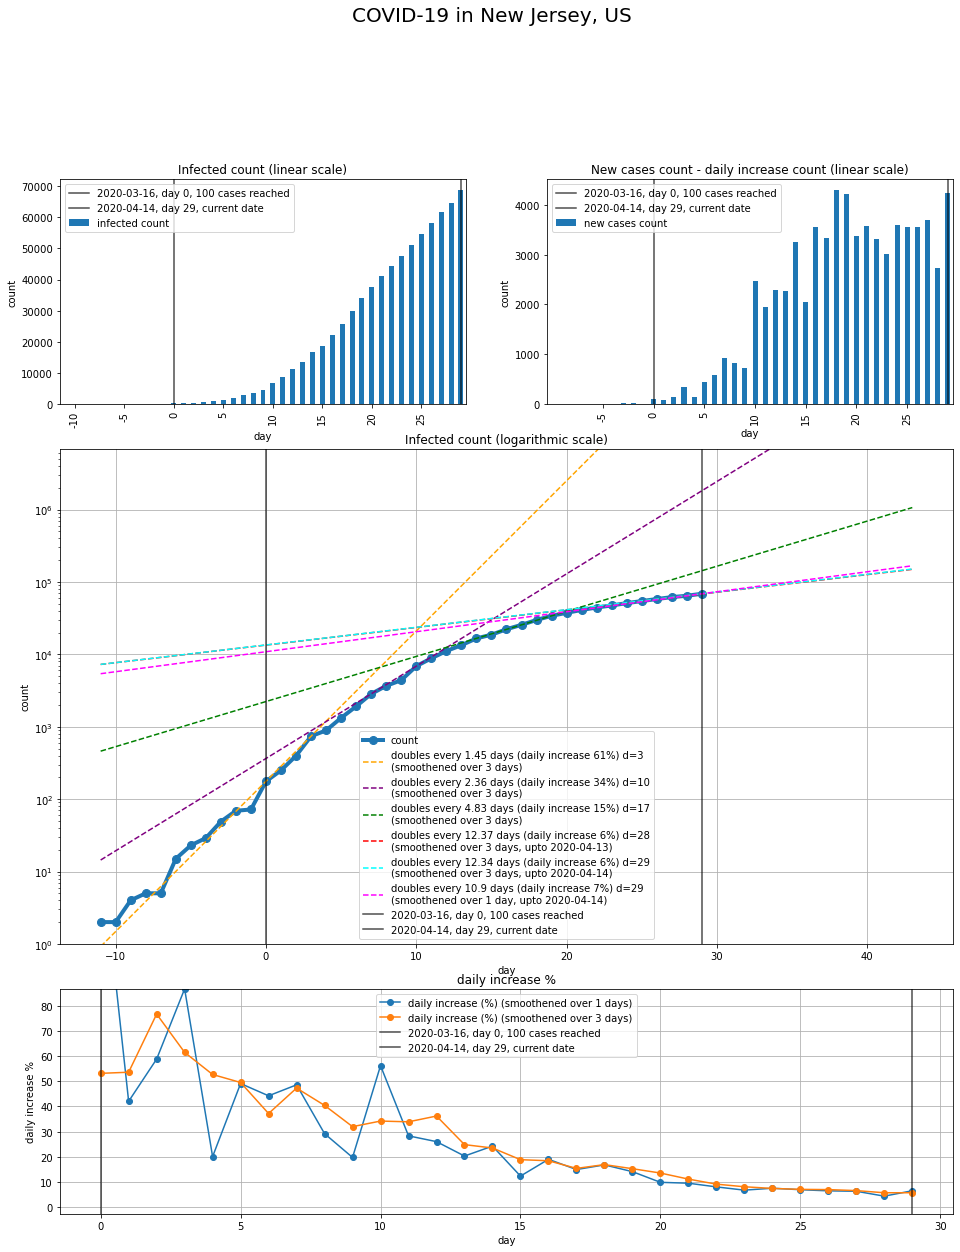

Saved analysis to: output/covid/by_country/New Jersey_US_covid_plot.jpeg
Austria None
Saved analysis to: output/covid/by_country/Austria_covid_analysis.xlsx


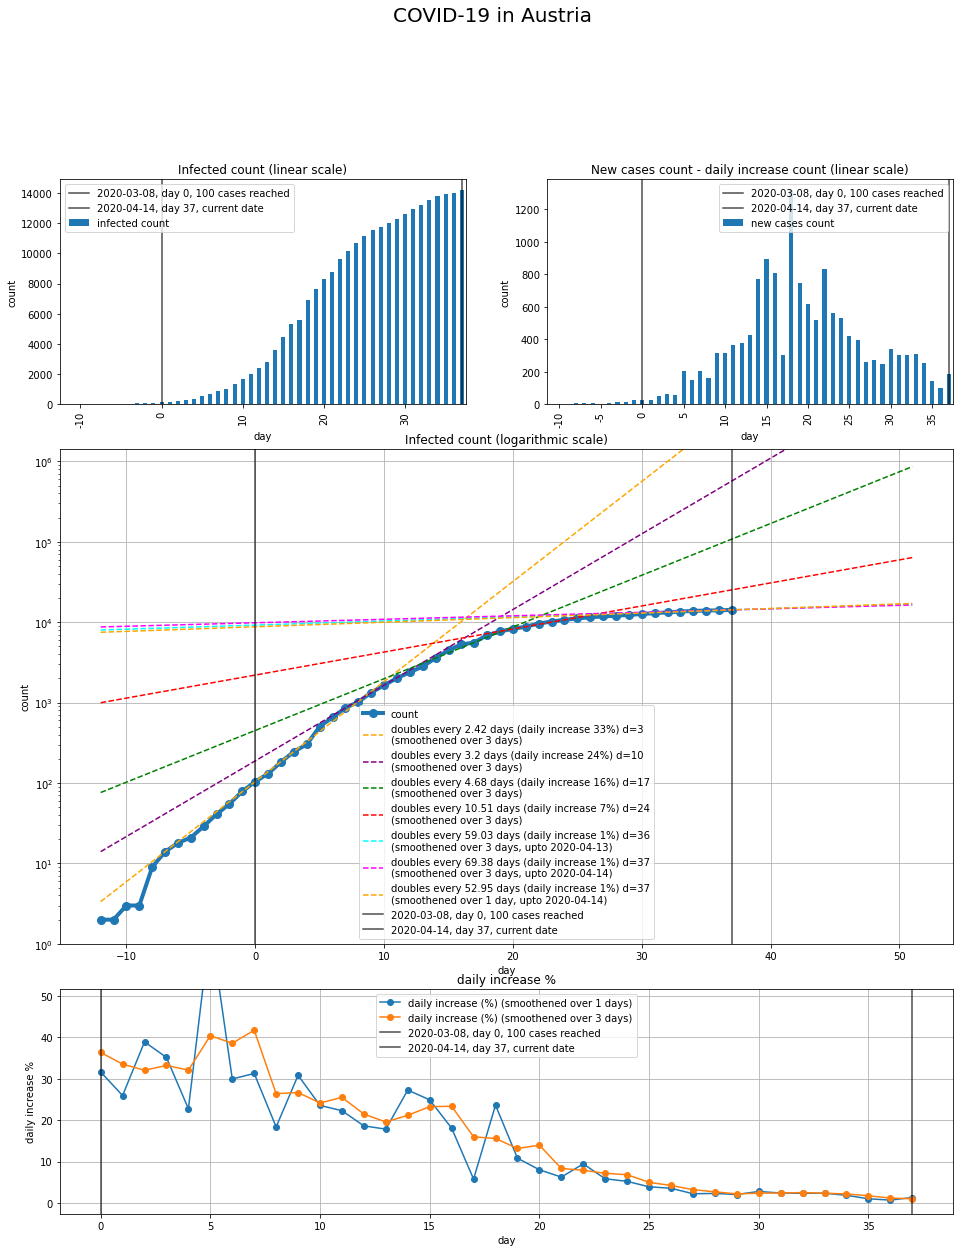

Saved analysis to: output/covid/by_country/Austria_covid_plot.jpeg
Switzerland None
Saved analysis to: output/covid/by_country/Switzerland_covid_analysis.xlsx


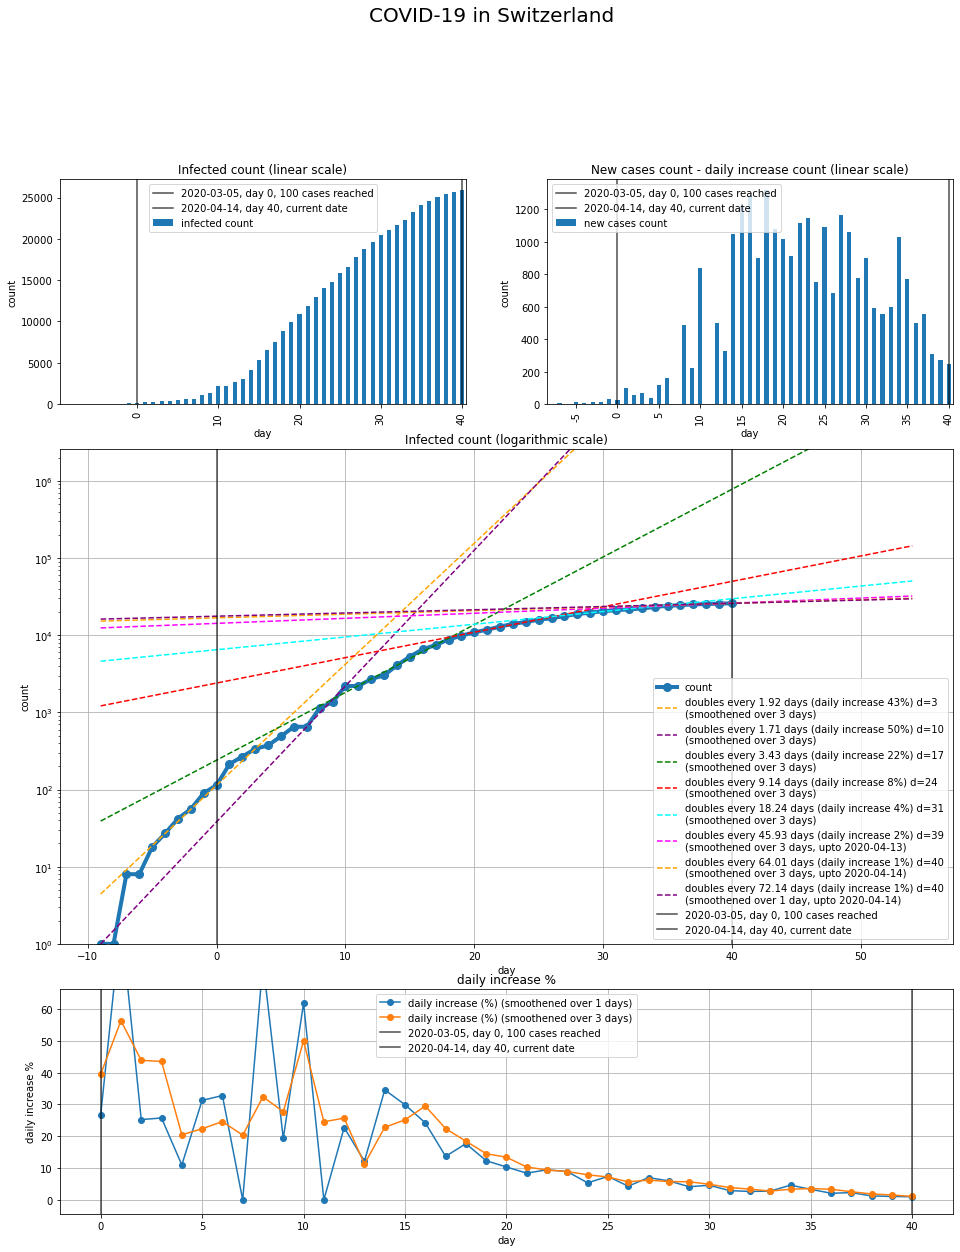

Saved analysis to: output/covid/by_country/Switzerland_covid_plot.jpeg
Belgium None
Saved analysis to: output/covid/by_country/Belgium_covid_analysis.xlsx


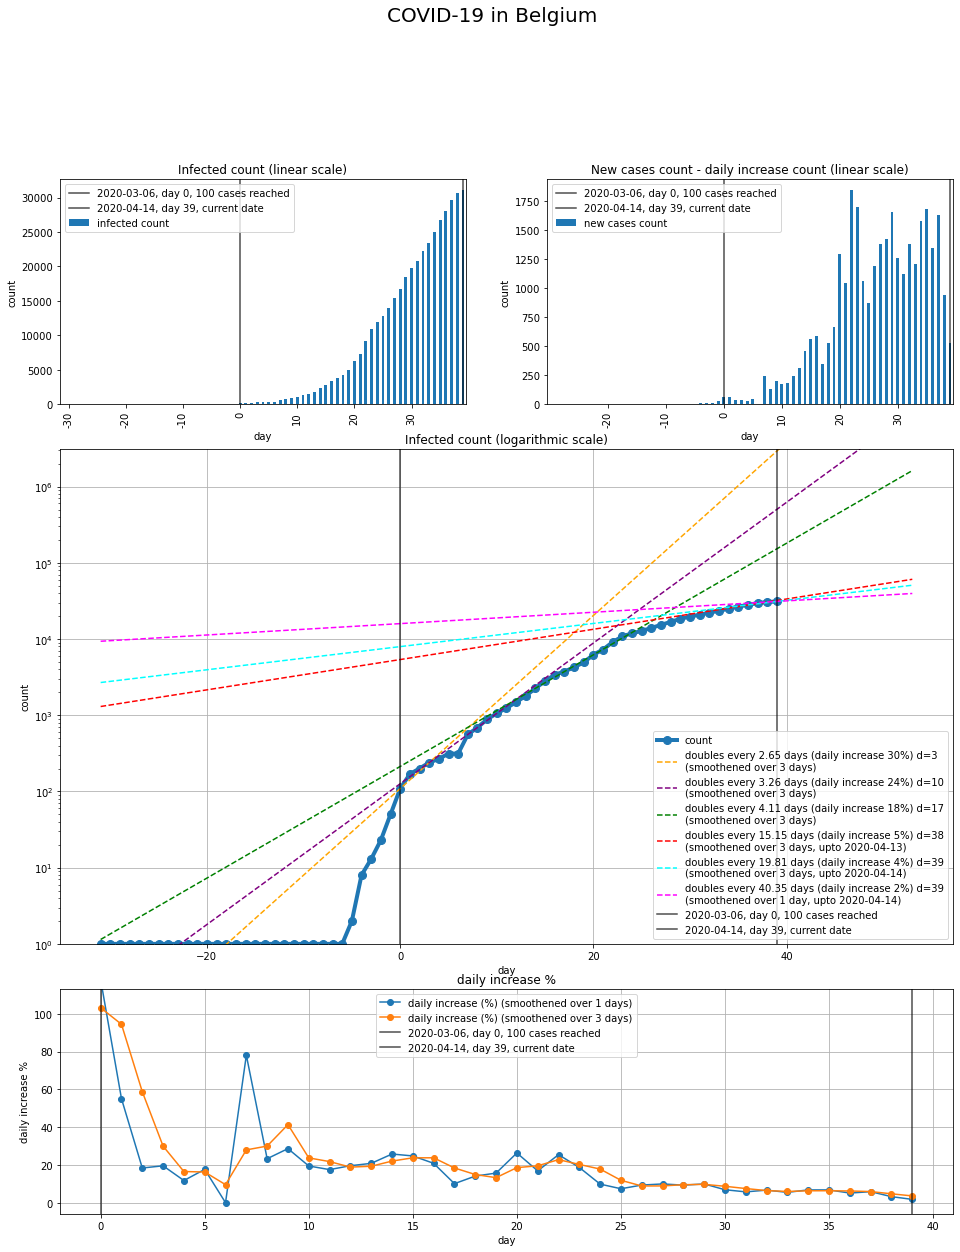

Saved analysis to: output/covid/by_country/Belgium_covid_plot.jpeg
Australia None
Saved analysis to: output/covid/by_country/Australia_covid_analysis.xlsx


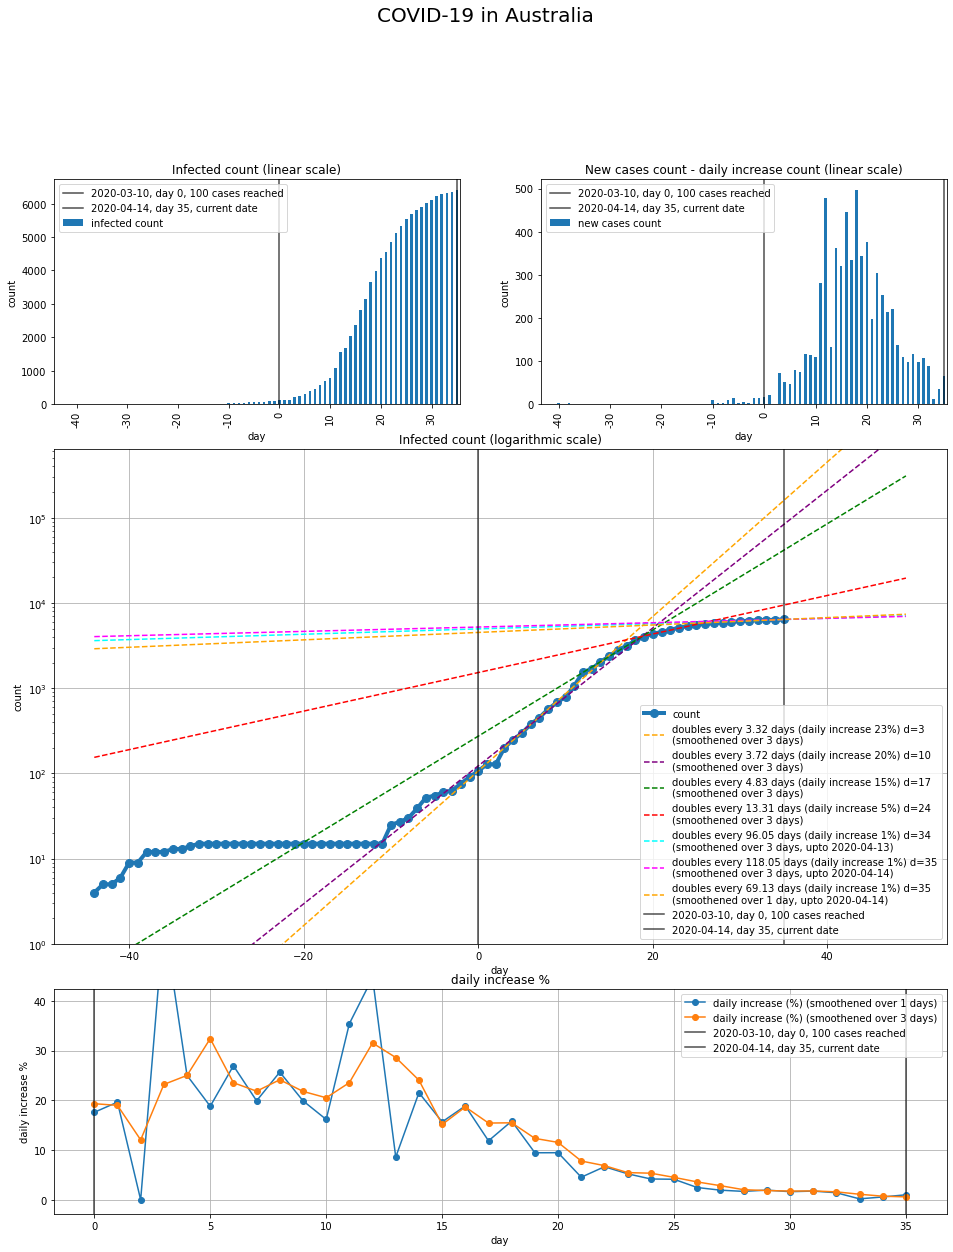

Saved analysis to: output/covid/by_country/Australia_covid_plot.jpeg
Canada None
Saved analysis to: output/covid/by_country/Canada_covid_analysis.xlsx


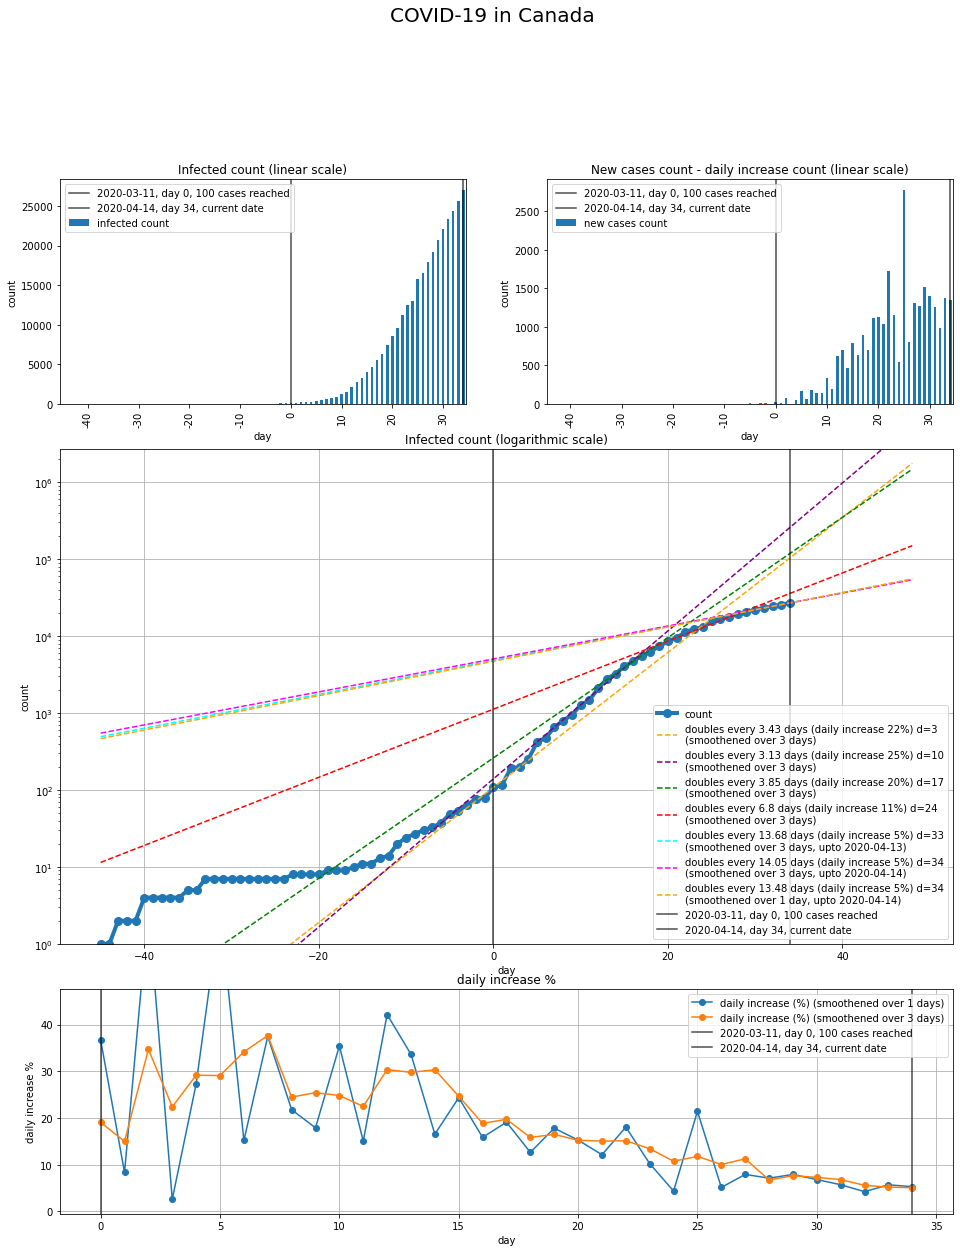

Saved analysis to: output/covid/by_country/Canada_covid_plot.jpeg
Israel None
Saved analysis to: output/covid/by_country/Israel_covid_analysis.xlsx


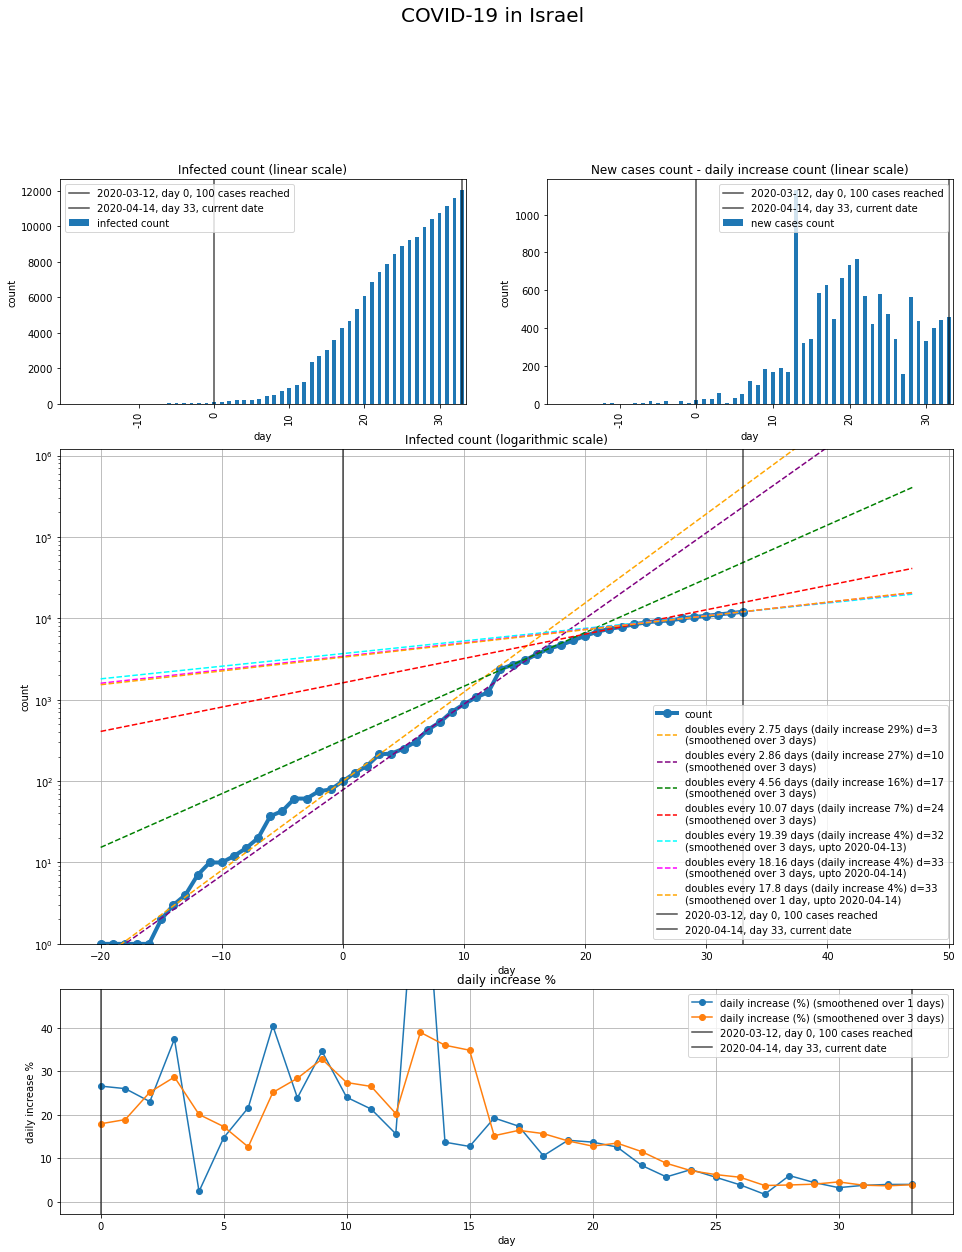

Saved analysis to: output/covid/by_country/Israel_covid_plot.jpeg
South Africa None
Saved analysis to: output/covid/by_country/South Africa_covid_analysis.xlsx


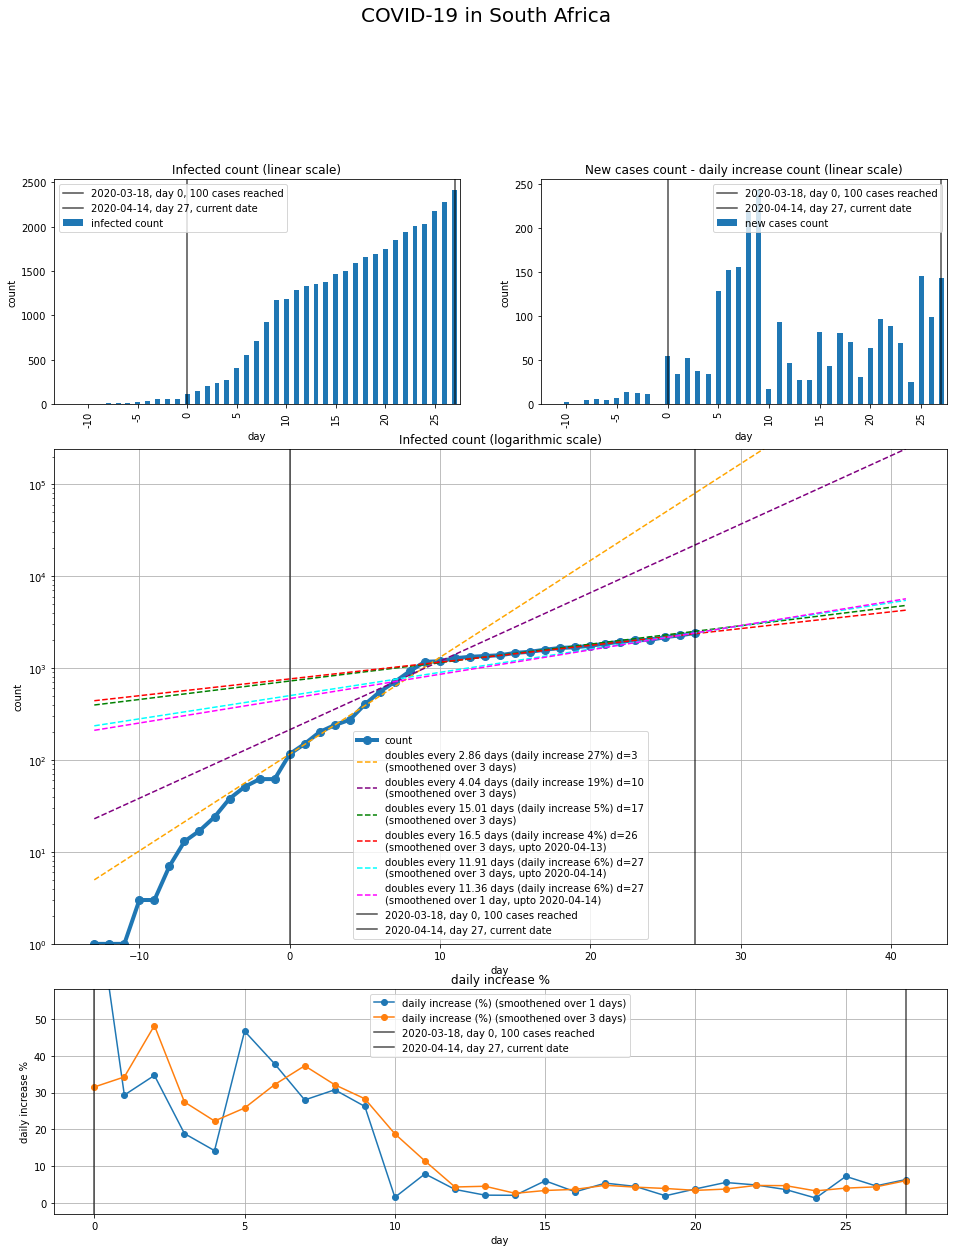

Saved analysis to: output/covid/by_country/South Africa_covid_plot.jpeg
Turkey None
Saved analysis to: output/covid/by_country/Turkey_covid_analysis.xlsx


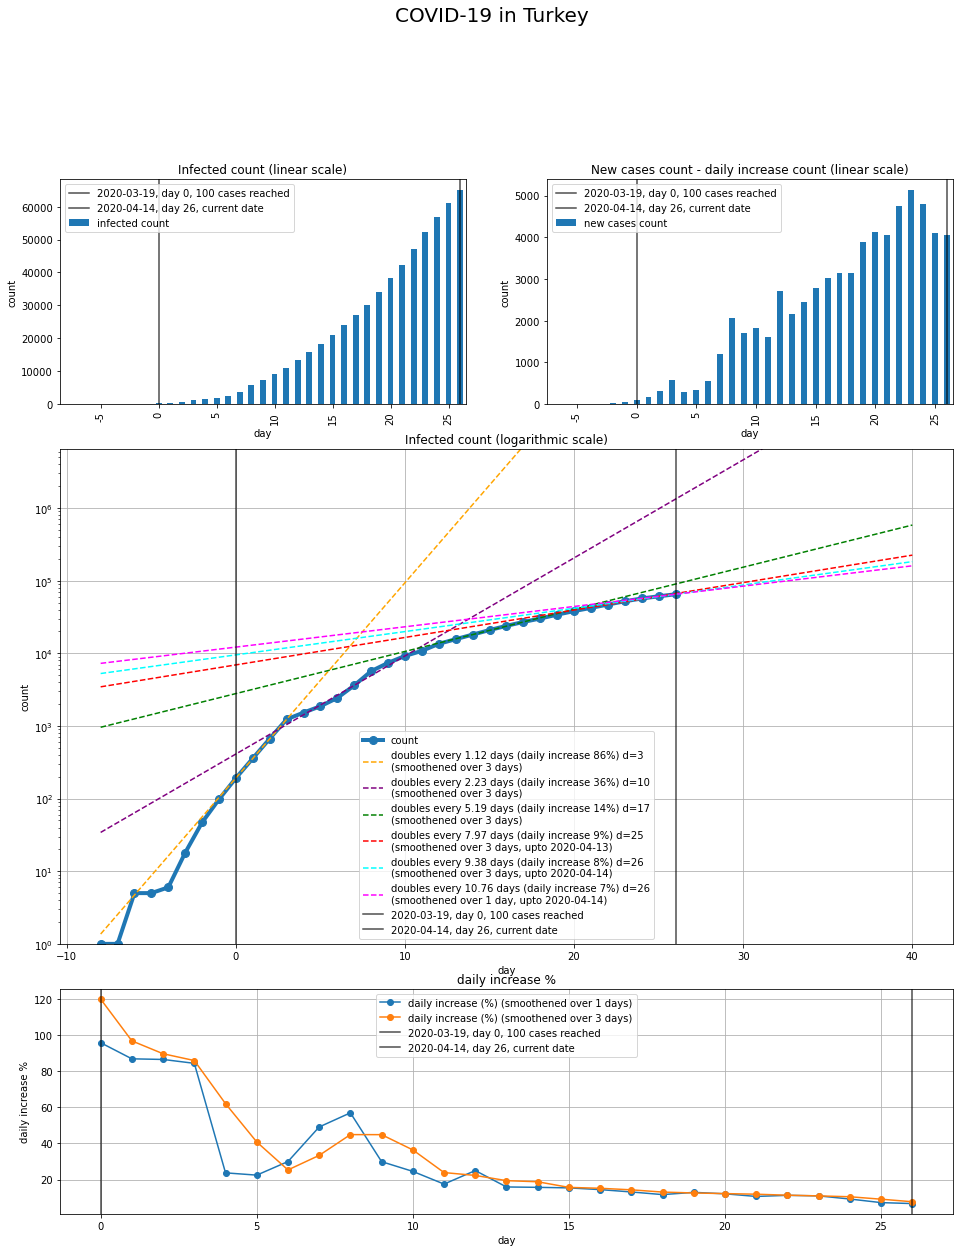

Saved analysis to: output/covid/by_country/Turkey_covid_plot.jpeg
Iran None
Saved analysis to: output/covid/by_country/Iran_covid_analysis.xlsx


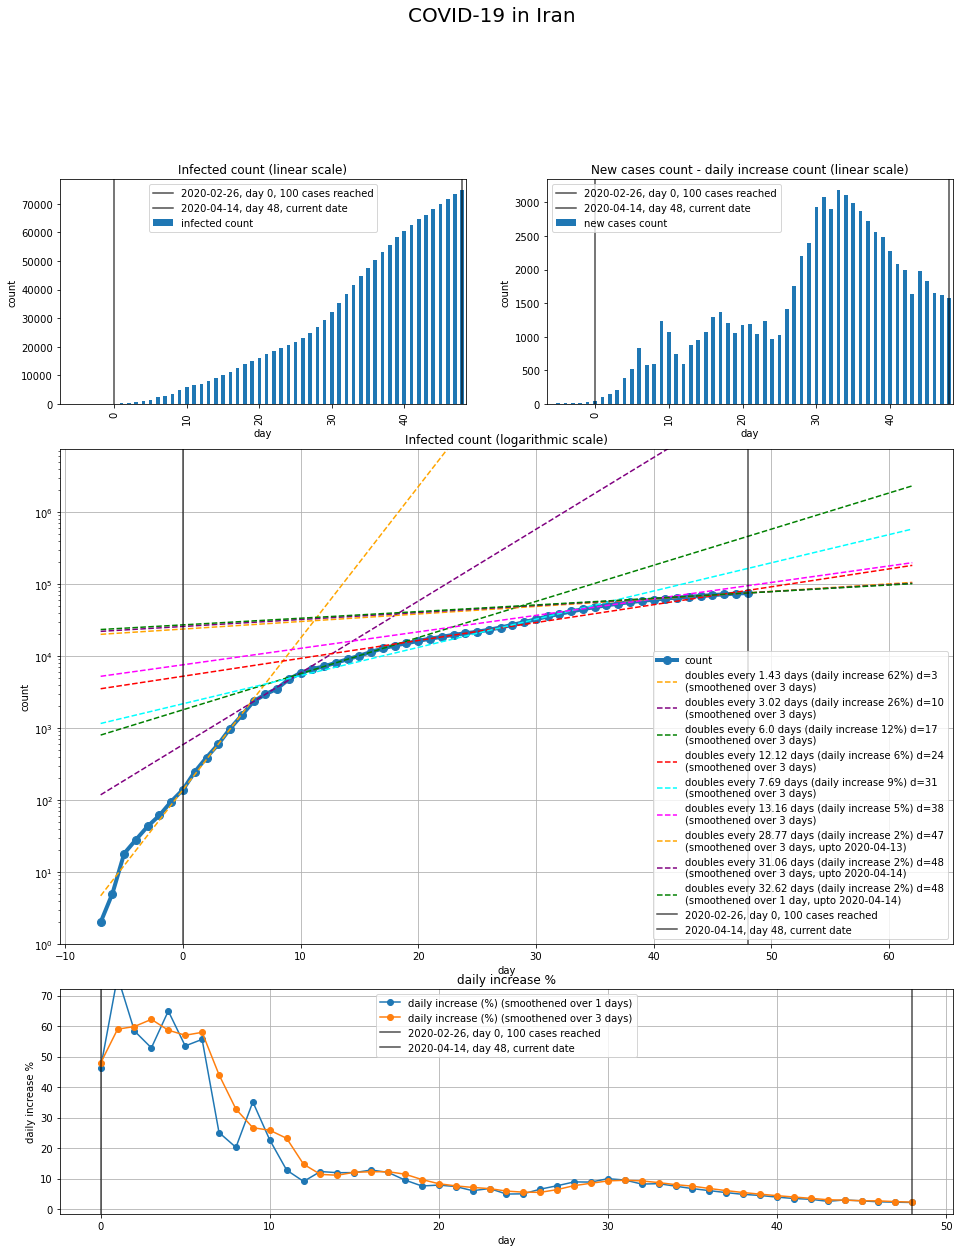

Saved analysis to: output/covid/by_country/Iran_covid_plot.jpeg
Russia None
Saved analysis to: output/covid/by_country/Russia_covid_analysis.xlsx


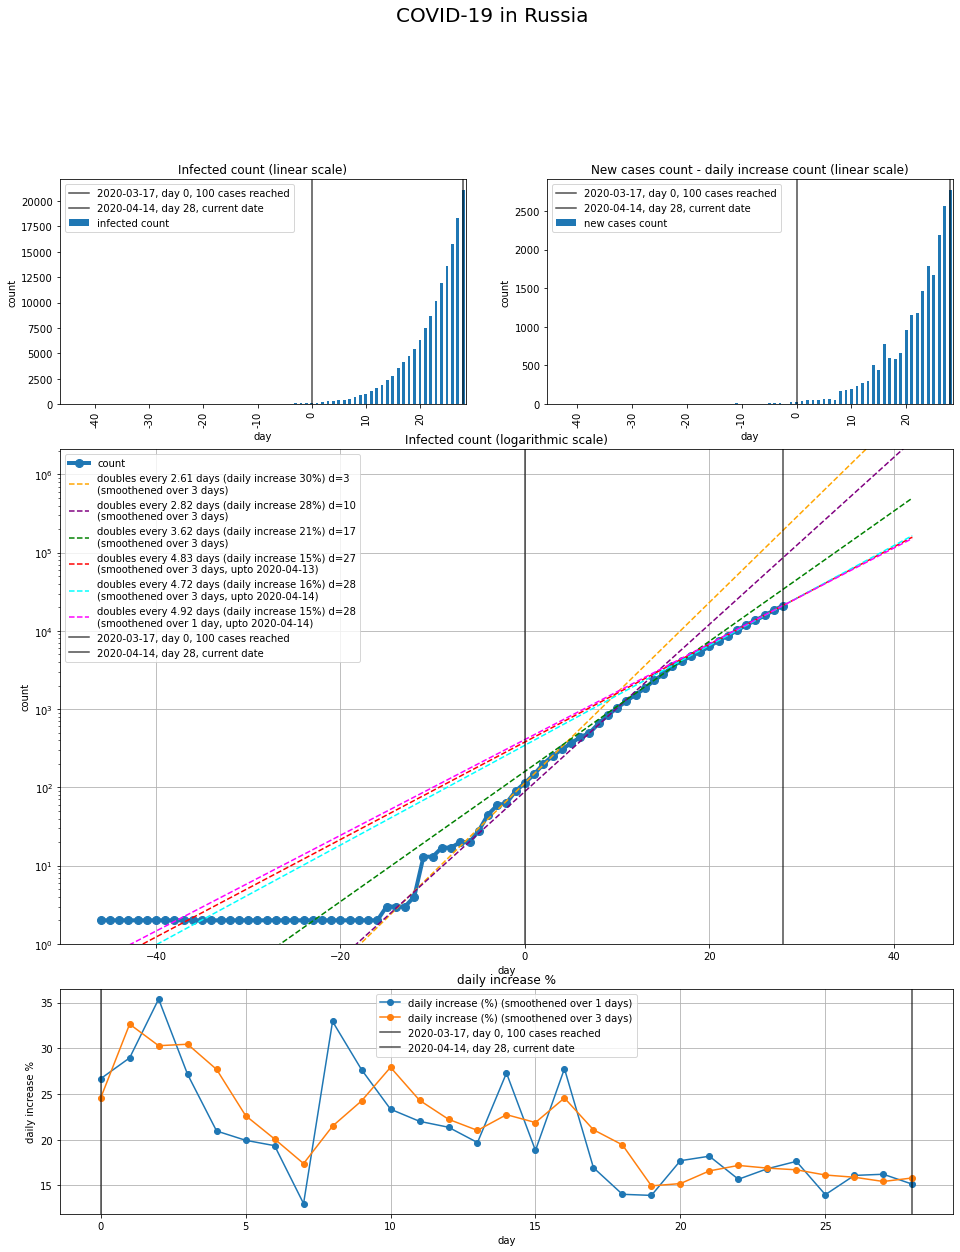

Saved analysis to: output/covid/by_country/Russia_covid_plot.jpeg
Belarus None
Saved analysis to: output/covid/by_country/Belarus_covid_analysis.xlsx


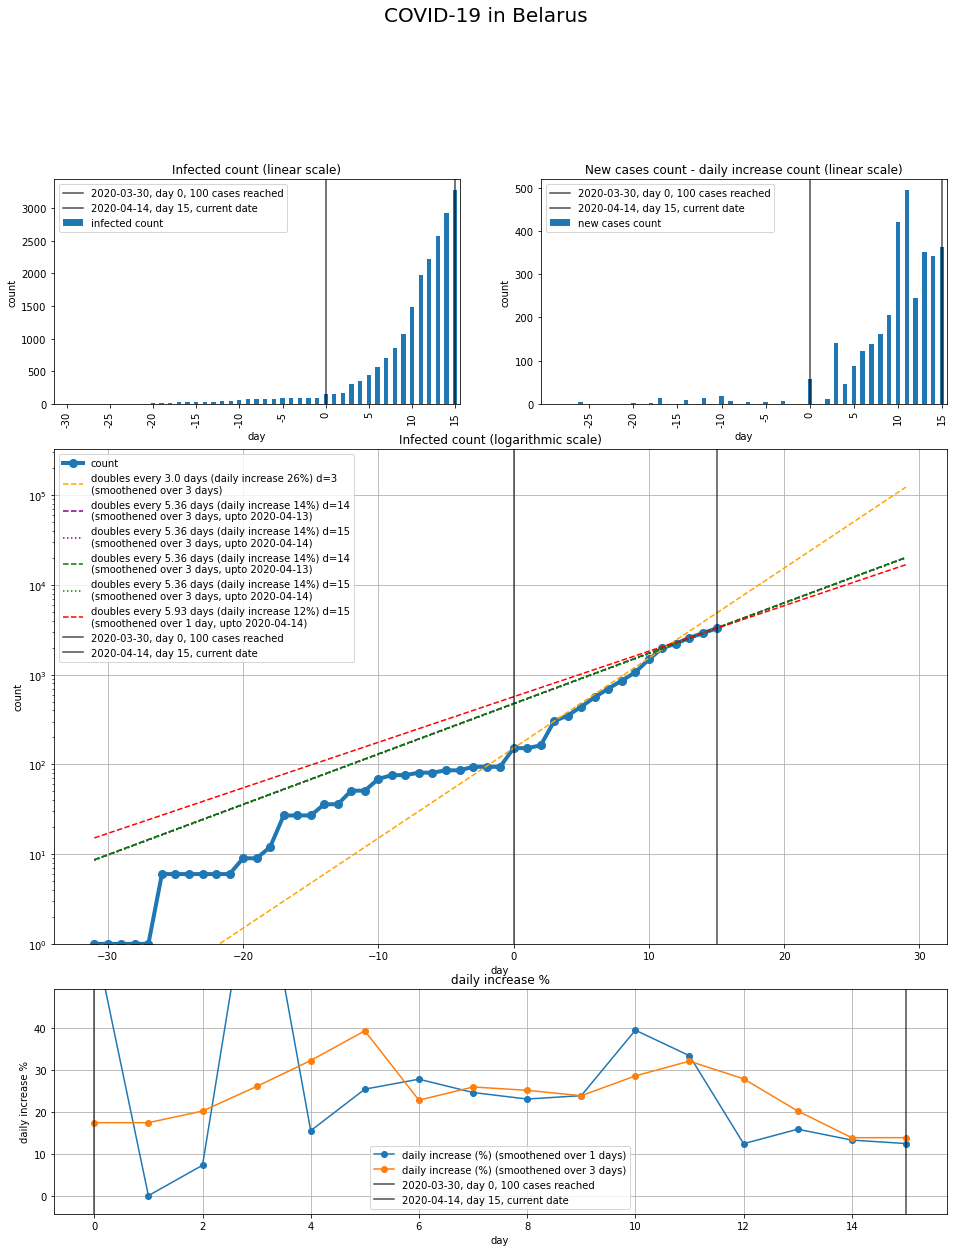

Saved analysis to: output/covid/by_country/Belarus_covid_plot.jpeg


In [6]:
for country in countries:
    read_data_plot_country(country['country'], country['province'], output_folder='by_country/')

# Plot all countries

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


infected count  infected count per million current date  \
New York, US          203020                       10436   2020-04-14   
Spain                 172541                        3663   2020-04-14   
Italy                 162488                        2697   2020-04-14   
France                130253                        1941   2020-04-14   
Germany               131359                        1579   2020-04-14   
Hubei, China           67803                        1159   2020-04-14   
Belarus                 3281                         348   2020-04-14   
Korea, South           10564                         204   2020-04-14   
Poland                  7582                         197   2020-04-15   
Japan                   7645                          60   2020-04-14   

              daily increase % (smoothened over last 7 days)  \
New York, US                                           0.058   
Spain                                                  0.032   
Italy                                                  0.027   
France                                                 0.049   
Germany                                                0.033   
Hubei, China                                           0.000   
Belarus                                                0.226   
Korea, South                                           0.003   
Poland                                                 0.058   
Japan                                                  0.105   

              doubles every ... days  \
New York, US                   12.27   
Spain                          22.18   
Italy                          26.20   
France                         14.56   
Germany                        21.12   
Hubei, China              1000000.00   
Belarus                         3.40   
Korea, South                  199.60   
Poland                         12.26   
Japan                           6.92   

              days since at least 1 per million infected  \
New York, US                                          34   
Spain                                                 38   
Italy                                                 47   
France                                                38   
Germany                                               37   
Hubei, China                                          80   
Belarus                                               15   
Korea, South                                          51   
Poland                                                26   
Japan                                                 20   

              days between 1st case and at least 10 per million infected  \
New York, US                                                  9            
Spain                                                        35            
Italy                                                        27            
France                                                       43            
Germany                                                      41            
Hubei, China                                                  3            
Belarus                                                      31            
Korea, South                                                 32            
Poland                                                       16            
Japan                                                        63            

              population (million)  density (people per km2)  \
New York, US                  19.5                     159.0   
Spain                         47.1                      93.0   
Italy                         60.2                     200.0   
France                        67.1                     123.0   
Germany                       83.1                     233.0   
Hubei, China                  58.5                     314.7   
Belarus                        9.4                      46.0   
Korea, South                  51.7                    

Saved analysis to: output/covid/reference_countries_comparison/countries_comparison.xlsx


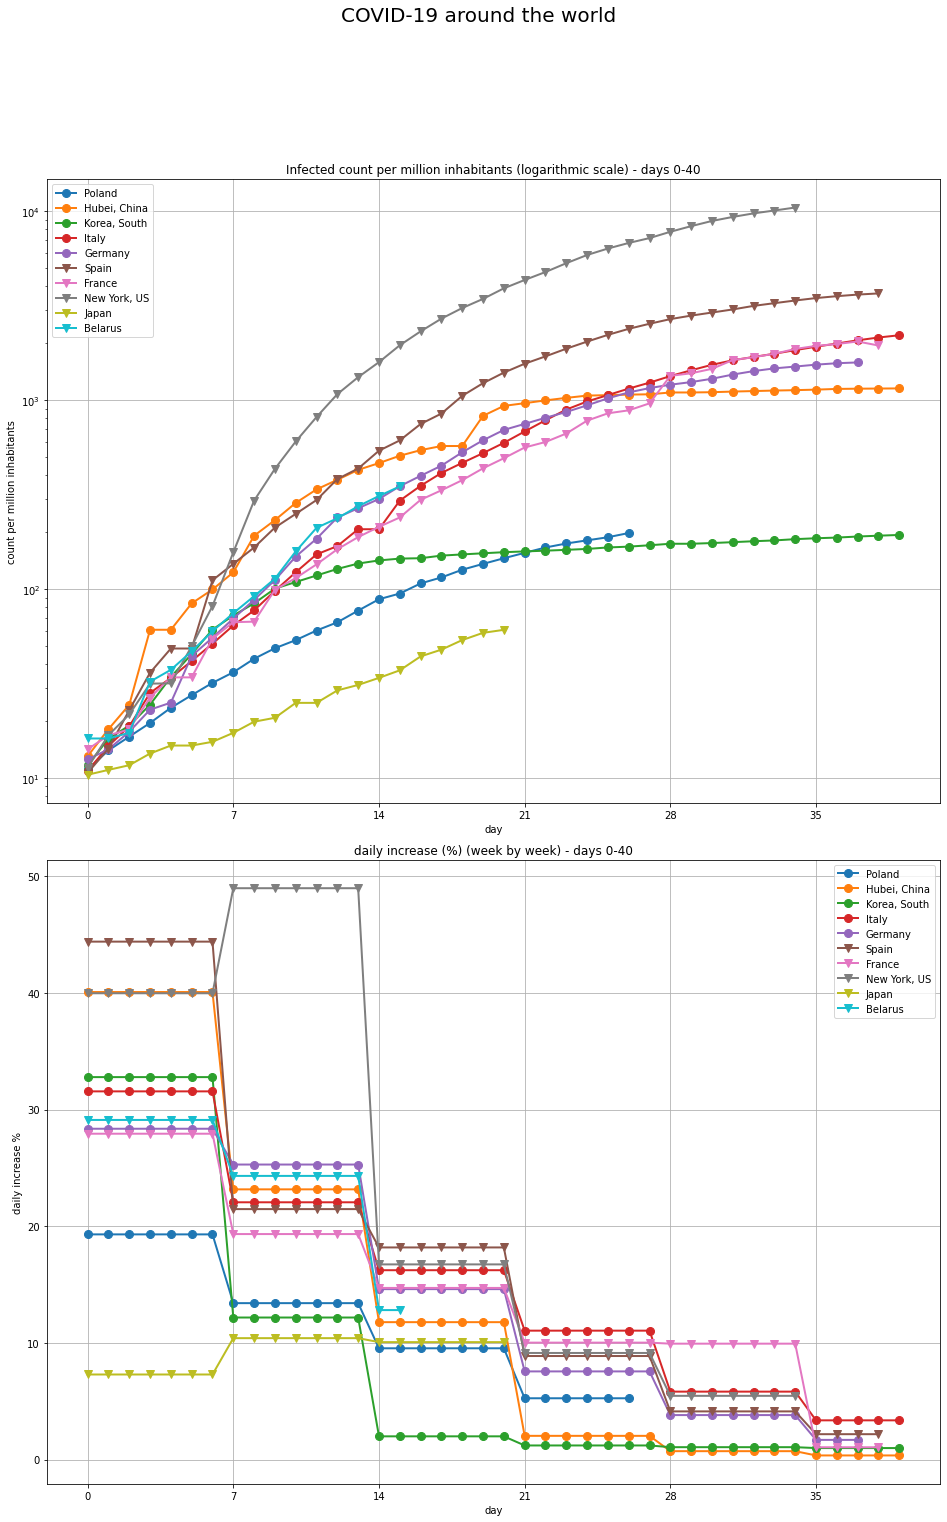

Saved analysis to: output/covid/reference_countries_comparison/covid_plot.jpeg


In [7]:
country_df = read_data_plot_countries(reference_countries, output_folder='reference_countries_comparison/',
                                      min_count_per_million=10,
                                      max_days=40)

# Correlations for all countries

100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:43<00:00,  4.21it/s]


infected count  infected count per million current date  \
New York, US          203020                       10436   2020-04-14   
Spain                 172541                        3663   2020-04-14   
Switzerland            25936                        3026   2020-04-14   
Belgium                31119                        2702   2020-04-14   
Italy                 162488                        2697   2020-04-14   
...                      ...                         ...          ...   
Senegal                  299                          18   2020-04-14   
Taiwan                   393                          16   2020-04-14   
Sri Lanka                233                          10   2020-04-14   
Guatemala                167                          10   2020-04-14   
Rwanda                   134                          10   2020-04-14   

              daily increase % (smoothened over last 7 days)  \
New York, US                                           0.058   
Spain                                                  0.032   
Switzerland                                            0.025   
Belgium                                                0.057   
Italy                                                  0.027   
...                                                      ...   
Senegal                                                0.037   
Taiwan                                                 0.007   
Sri Lanka                                              0.029   
Guatemala                                              0.121   
Rwanda                                                 0.028   

              doubles every ... days  \
New York, US                   12.27   
Spain                          22.18   
Switzerland                    28.42   
Belgium                        12.60   
Italy                          26.20   
...                              ...   
Senegal                        19.19   
Taiwan                         92.89   
Sri Lanka                      24.49   
Guatemala                       6.05   
Rwanda                         25.51   

              days since at least 1 per million infected  \
New York, US                                          34   
Spain                                                 38   
Switzerland                                           41   
Belgium                                               38   
Italy                                                 47   
...                                                  ...   
Senegal                                               14   
Taiwan                                                19   
Sri Lanka                                              0   
Guatemala                                              0   
Rwanda                                                 2   

              days between 1st case and at least 10 per million infected  \
New York, US                                                  9            
Spain                                                        35            
Switzerland                                                   8            
Belgium                                                      32            
Italy                                                        27            
...                                                         ...            
Senegal                                                      29            
Taiwan                                                       64            
Sri Lanka                                                    78            
Guatemala                                                    31            
Rwanda                                                       29            

              population (million)  density (people per km2)  \
New York, US                  19.5                     159.0   
Spain                         47.1                      93.0   
Switzerland                    8.6                     208.0 

Saved analysis to: output/covid/all_countries_correlations/all_countries_comparison.xlsx


infected count per million week_2  \
infected count per million week_2                                            1.000000   
daily increase % week_2                                                      0.475481   
daily increase % week_1                                                      0.792576   
daily increase % week_0                                                      0.356983   
days between 1st case and at least 10 per milli...                          -0.106822   
population (million)                                                         0.014761   
density (people per km2)                                                    -0.089645   
GDP per capita ($) (PPP)                                                     0.316201   
GDP per capita ($) (nominal)                                                 0.504754   
average yearly temperature (degree Celsius)                                 -0.277388   

                                                    daily increase % week_2  
infected count per million week_2                                  0.475481  
daily increase % week_2                                            1.000000  
daily increase % week_1                                            0.650427  
daily increase % week_0                                            0.172007  
days between 1st case and at least 10 per milli...                 0.019520  
population (million)                                               0.070594  
density (people per km2)                                          -0.173791  
GDP per capita ($) (PPP)                                           0.114667  
GDP per capita ($) (nominal)                                       0.260683  
average yearly temperature (degree Celsius)                       -0.214142

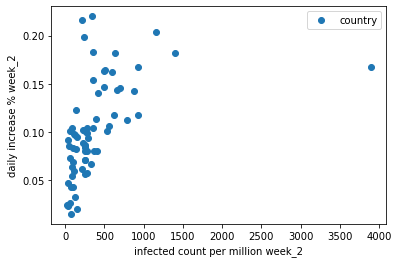

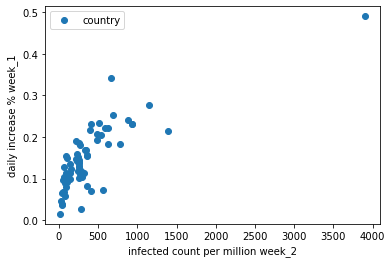

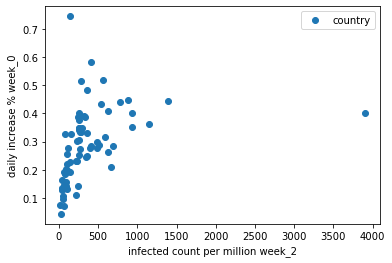

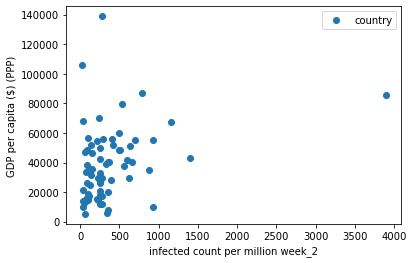

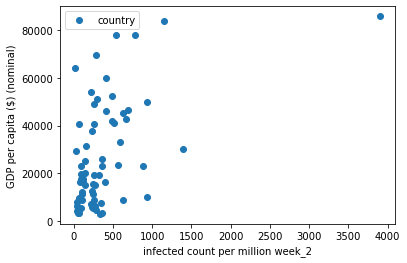

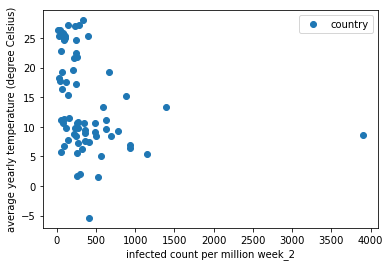

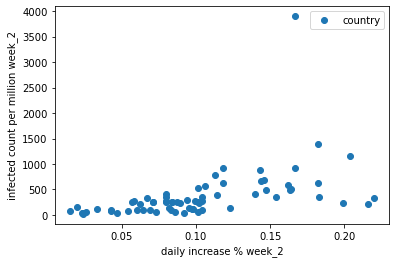

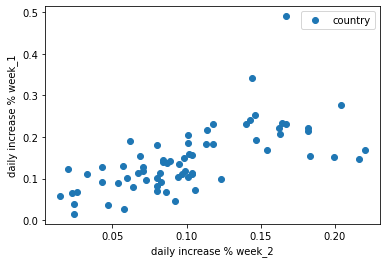

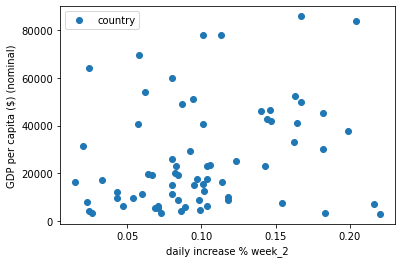

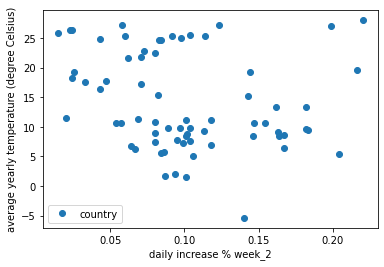

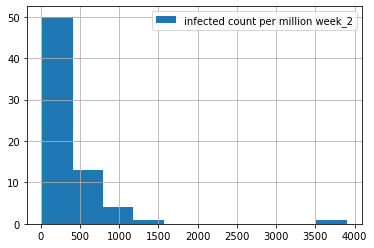

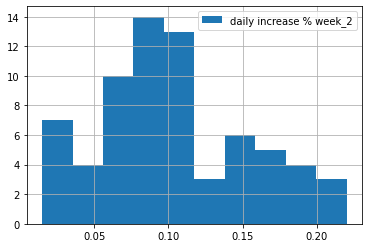

In [8]:
reference_provinces = {
    c['country'] : c['province'] for c in reference_countries if c['province'] is not None
}
all_countries = [{'country' : c, 'province' : reference_provinces[c] if c in reference_provinces else None} for c in get_all_countries()]
country_df = read_data_correlate_countries(all_countries,
                                           min_count_per_million=10,
                                           output_folder='all_countries_correlations/')

# Plots for all Polish provinces

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


infected count  infected count per million  \
mazowieckie, Poland                    1792                         333   
dolnoslaskie, Poland                    764                         263   
lodzkie, Poland                         572                         230   
wielkopolskie, Poland                   785                         225   
podlaskie, Poland                       259                         218   
slaskie, Poland                         988                         217   
kujawsko-pomorskie, Poland              359                         172   
malopolskie, Poland                     561                         165   
swietokrzyskie, Poland                  170                         136   
zachodniopomorskie, Poland              217                         127   
lubelskie, Poland                       270                         126   
podkarpackie, Poland                    243                         114   
warminsko-mazurskie, Poland             125                          87   
lubuskie, Poland                         79                          77   
pomorskie, Poland                       179                          77   

                            current date  \
mazowieckie, Poland           2020-04-15   
dolnoslaskie, Poland          2020-04-15   
lodzkie, Poland               2020-04-15   
wielkopolskie, Poland         2020-04-15   
podlaskie, Poland             2020-04-15   
slaskie, Poland               2020-04-15   
kujawsko-pomorskie, Poland    2020-04-15   
malopolskie, Poland           2020-04-15   
swietokrzyskie, Poland        2020-04-15   
zachodniopomorskie, Poland    2020-04-15   
lubelskie, Poland             2020-04-15   
podkarpackie, Poland          2020-04-15   
warminsko-mazurskie, Poland   2020-04-15   
lubuskie, Poland              2020-04-15   
pomorskie, Poland             2020-04-15   

                             daily increase % (smoothened over last 7 days)  \
mazowieckie, Poland                                                   0.047   
dolnoslaskie, Poland                                                  0.046   
lodzkie, Poland                                                       0.068   
wielkopolskie, Poland                                                 0.101   
podlaskie, Poland                                                     0.105   
slaskie, Poland                                                       0.066   
kujawsko-pomorskie, Poland                                            0.042   
malopolskie, Poland                                                   0.054   
swietokrzyskie, Poland                                                0.036   
zachodniopomorskie, Poland                                            0.068   
lubelskie, Poland                                                     0.035   
podkarpackie, Poland                                                  0.048   
warminsko-mazurskie, Poland                                           0.049   
lubuskie, Poland                                                      0.035   
pomorskie, Poland                                                     0.038   

                             doubles every ... days  \
mazowieckie, Poland                           15.23   
dolnoslaskie, Poland                          15.34   
lodzkie, Poland                               10.55   
wielkopolskie, Poland                          7.23   
podlaskie, Poland                              6.92   
slaskie, Poland                               10.77   
kujawsko-pomorskie, Poland                    16.87   
malopolskie, Poland                           13.12   
swietokrzyskie, Poland                        19.45   
zachodniopomorskie, Poland                    10.51   
lubelskie, Poland                             19.90   
podkarpackie, Poland                          14.64   
warminsko-mazurskie, Poland                   14.35   
lubuskie, Poland                              20.02   
pomorskie, Poland                

Saved analysis to: output/covid/polish_provinces_comparison/countries_comparison.xlsx


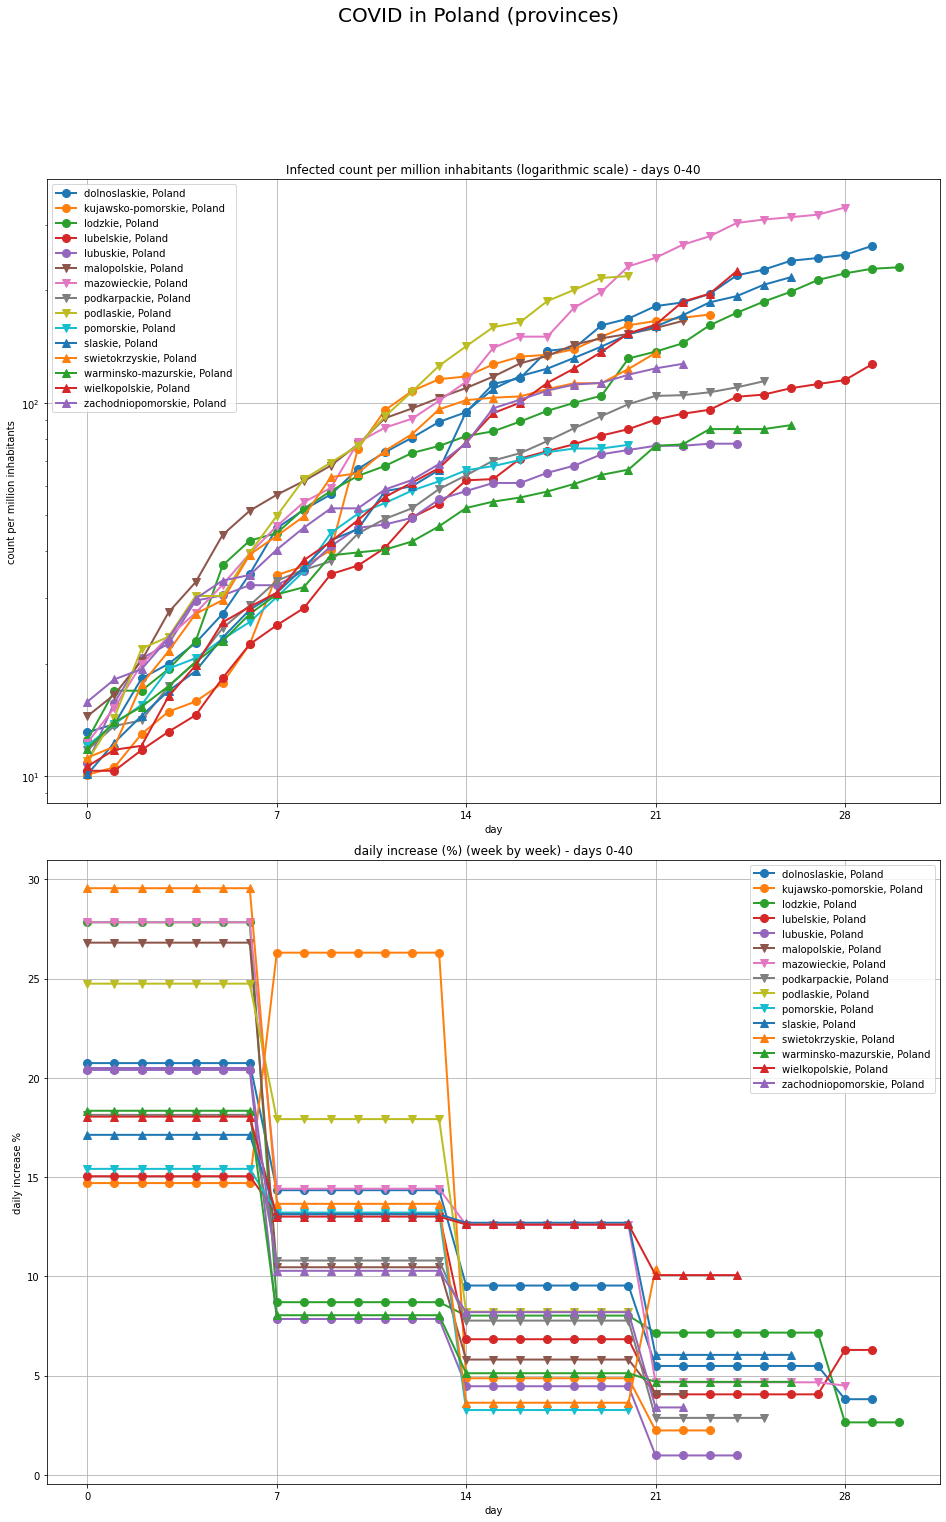

Saved analysis to: output/covid/polish_provinces_comparison/covid_plot.jpeg


In [9]:
polish_provinces = [
    {
        'country': 'Poland',
        'province': p 
    }
    for p in get_all_country_provinces('Poland')]
country_df = read_data_plot_countries(polish_provinces, 
                                      min_count=10, 
                                      title='COVID in Poland (provinces)',
                                      output_folder='polish_provinces_comparison/')

# Plots for all US states

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.85it/s]


infected count  infected count per million current date  \
New York, US                203020                       10436   2020-04-14   
New Jersey, US               68824                        7748   2020-04-14   
Louisiana, US                21518                        4628   2020-04-14   
Massachusetts, US            28164                        4052   2020-04-14   
Connecticut, US              13989                        3923   2020-04-14   
Michigan, US                 26549                        2658   2020-04-14   
Pennsylvania, US             25465                        1989   2020-04-14   
Illinois, US                 23248                        1834   2020-04-14   
Maryland, US                  9472                        1566   2020-04-14   
Washington, US               10799                        1418   2020-04-14   
Colorado, US                  7950                        1380   2020-04-14   
Georgia, US                  14578                        1373   2020-04-14   
Indiana, US                   8527                        1266   2020-04-14   
Florida, US                  21628                        1006   2020-04-14   
Tennessee, US                 5827                         852   2020-04-14   
Virginia, US                  6182                         724   2020-04-14   
California, US               25356                         641   2020-04-14   
Ohio, US                      7285                         623   2020-04-14   
Texas, US                    15006                         517   2020-04-14   
North Carolina, US            5113                         487   2020-04-14   

                    daily increase % (smoothened over last 7 days)  \
New York, US                                                 0.058   
New Jersey, US                                               0.067   
Louisiana, US                                                0.051   
Massachusetts, US                                            0.099   
Connecticut, US                                              0.099   
Michigan, US                                                 0.056   
Pennsylvania, US                                             0.092   
Illinois, US                                                 0.087   
Maryland, US                                                 0.120   
Washington, US                                               0.036   
Colorado, US                                                 0.058   
Georgia, US                                                  0.089   
Indiana, US                                                  0.078   
Florida, US                                                  0.067   
Tennessee, US                                                0.057   
Virginia, US                                                 0.104   
California, US                                               0.059   
Ohio, US                                                     0.066   
Texas, US                                                    0.085   
North Carolina, US                                           0.074   

                    doubles every ... days  \
New York, US                         12.27   
New Jersey, US                       10.73   
Louisiana, US                        14.02   
Massachusetts, US                     7.31   
Connecticut, US                       7.34   
Michigan, US                         12.69   
Pennsylvania, US                      7.88   
Illinois, US                          8.28   
Maryland, US                          6.12   
Washington, US                       19.68   
Colorado, US                         12.29   
Georgia, US                           8.10   
Indiana, US                           9.28   
Florida, US                          10.64   
Tennessee, US                        12.47   
Virginia, US                          7.02   
California, US                       12.09   
Ohio, US                             10.81   
Texas, US      

Saved analysis to: output/covid/us_provinces_comparison/countries_comparison.xlsx


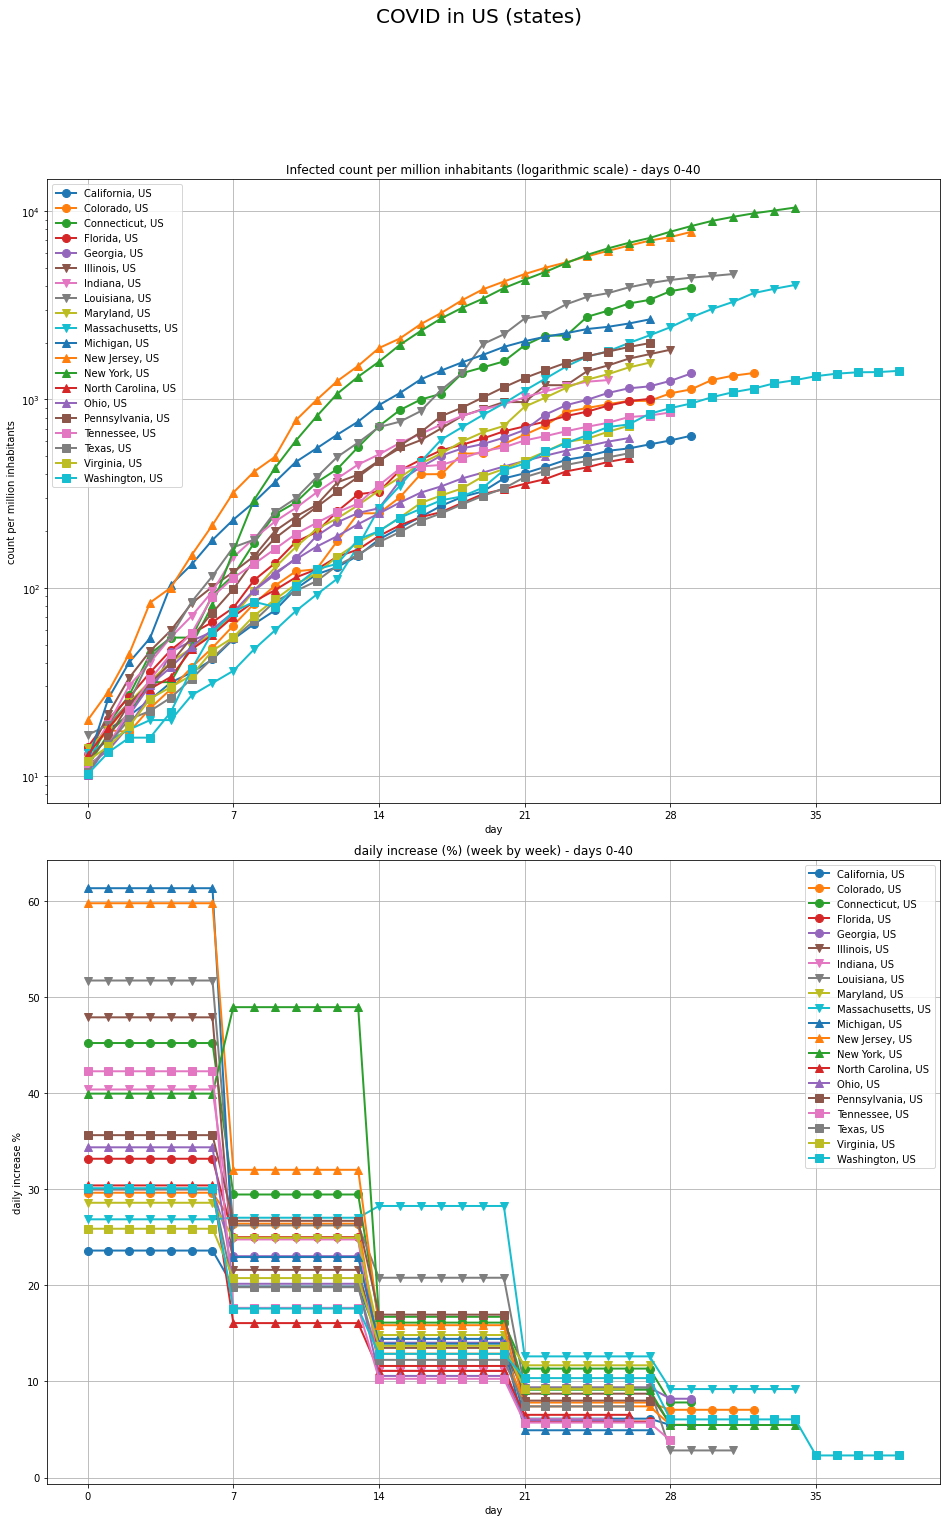

Saved analysis to: output/covid/us_provinces_comparison/covid_plot.jpeg


In [10]:
polish_provinces = [
    {
        'country': 'US',
        'province': p 
    }
    for p in get_all_country_provinces('US', folder='kaggle', file='time_series_covid_19_confirmed_US')]
country_df = read_data_plot_countries(
    polish_provinces, 
    min_count=5000,  
    output_folder='us_provinces_comparison/',
    title='COVID in US (states)'
)

# Countries clustering

In [11]:
from sklearn.cluster import DBSCAN
import uuid

In [12]:
def get_dist(a, b, log=True, offset=0.01, power=2, index_weights=True):
    mask = a.notnull() & b.notnull()
    a = a[mask].astype('float') + offset
    b = b[mask].astype('float') + offset
    if log:
        a = np.log(a)
        b = np.log(b)
    if index_weights:
        weights = np.array(a.index)
    else:
        weights = np.ones(a.index.shape[0])
    return (weights * np.abs(np.power((a-b)/np.maximum(a, b), power))).sum()/ weights.sum()

def country_filtering_condition(country, min_population = 10**6, min_count = 100, min_count_per_million=10, min_days = 14):
    if 'df' not in country:
        return False
    df = country['df']
    population = get_population(country['country'], country['province'])
    if population < min_population:
        return False
    if df['count'].max() < min_count:
        return False
    if df['count_per_million'].max() < min_count_per_million:
        return False
    if df.loc[0:]['count'].notnull().sum() < min_days:
        return False
    return True

def get_dist_df(countries, col='count_per_million', index_weights=True, log=True):
    count_per_million_df = pd.DataFrame({
    c['country'] :  c['df'][col].loc[0:]
        for c in tqdm(countries)})

    dist_df = pd.DataFrame()
    for country_a in tqdm(count_per_million_df.columns):
        for country_b in count_per_million_df.columns:
            d = get_dist(count_per_million_df[country_a], count_per_million_df[country_b], 
                         log=log, power=2, index_weights=index_weights)
            dist_df.loc[country_a, country_b] = d
            dist_df.loc[country_b, country_a] = d
            if country_a == country_b:
                break
    return dist_df

colors = ['orange', 'purple', 'green', 'red', 
          'cyan', 'magenta', 'blue', 'yellow', 'brown', 'lightgreen']
markers = ['o', 'v', '^', 's', '*', 'H', 'D']

def plot_log_count_clustering(countries, ax, max_days=None):
    plotted_clusters = set()
    unique_clusters = sorted(list(set([c['cluster'] for c in countries])))
    for c in unique_clusters:
        for i, country in enumerate(countries):
            cluster = country['cluster']
            if cluster != c:
                continue
            label = f'cluster {cluster}' if cluster != -1 else 'outside cluster'
            label = '_nolegend_' if cluster in plotted_clusters else label
            plotted_clusters.add(cluster)
            color = colors[cluster % len(colors)] if cluster != -1 else 'grey'
            marker = markers[cluster % len(markers)] if cluster != -1 else None
            df = country['df']
            day_offset=df.index.get_loc(0)
            df = df[day_offset:]
            if max_days is not None:
                df = df[:max_days]
            df['count_per_million'].plot(
                ax=ax, 
                logy=True, 
                lw=2 if cluster != -1 else 1,
                markersize=8, 
                grid=True,
                label=label,
                marker=None,
                color=color
            )
    
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    ax.set_ylabel('count per million inhabitants')
    title = 'Infected count per million inhabitants (logarithmic scale)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    ax.legend()
    
def plot_grow_rate_clustering(countries, ax, max_days=None):
    plotted_clusters = set()
    unique_clusters = sorted(list(set([c['cluster'] for c in countries])))
    for c in unique_clusters:
        for i, country in enumerate(countries):
            cluster = country['cluster']
            if cluster != c:
                continue
            label = f'cluster {cluster}' if cluster != -1 else 'outside cluster'
            label = '_nolegend_' if cluster in plotted_clusters else label
            plotted_clusters.add(cluster)
            color = colors[cluster % len(colors)] if cluster != -1 else 'grey'
            marker = markers[cluster % len(markers)] if cluster != -1 else None
            df = country['df']
            day_offset=df.index.get_loc(0)
            df = df[day_offset:]
            if max_days is not None:
                df = df[:max_days]
            (df['grow_rate_by_week'] * 100).plot(
                ax=ax, 
                label=label,
                grid=True,
                lw=2 if cluster != -1 else 1,
                markersize=8, 
                marker=None,
                color=color,)
    ax.set_ylabel('daily increase %')
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], 100))
    title = f'daily increase (%) (week by week)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    
def get_cluster_mean(countries, countries_not_clustering, cluster):
    mean = pd.DataFrame({country['country'] : get_country_info(country['df'], 
                      country['country'], 
                      country['province'], 
                      smooth_period=7,
                      min_count_per_million=10) for country in (countries if cluster != 'too few cases' else countries_not_clustering) 
                         if cluster in ['all countries', 'too few cases'] or country['cluster'] == cluster}).transpose().mean()
    for i in mean.index:
        mean.loc[i] = round(mean.loc[i], 2 if '%' in i else 0)
    
    selected_cols = [
        'GDP per capita ($) (PPP)',
        'GDP per capita ($) (nominal)',
        'average yearly temperature (degree Celsius)',
        'population (million)',
        'density (people per km2)',
        'daily increase % week_0', 
        'daily increase % week_1', 
        'daily increase % week_2', 
        'infected count per million week_0',
        'infected count per million week_1',
        'infected count per million week_2',
        
    ]
    return pd.Series([mean.loc[c] if c in mean.index else np.nan for c in selected_cols], index=selected_cols)

def get_cluster_info(clustering, countries, countries_not_clustering):
    cluster_info= pd.DataFrame([
    {
        'cluster' : f'cluster {c}' if c != -1 else 'outside cluster',
        'countries': ', '.join(clustering[clustering == c].index 
                               if c not in ['all countries', 'too few cases'] 
                               else clustering.index 
                               if c == 'all countries' 
                               else [c['country'] for c in countries_not_clustering]),
        'number of countries': (clustering == c).sum() if c not in ['all countries', 'too few cases'] else 
        clustering.shape[0] if c =='all countries' else len(countries_not_clustering),
        **get_cluster_mean(countries, countries_not_clustering, c).to_dict()
    }
    for c in ['too few cases', 'all countries'] + sorted(clustering.unique())])
    return cluster_info
    
    
def plot_clustering_report(clustering, countries, countries_not_clustering, max_days=None):
    for c in countries:
        c['cluster'] = clustering.loc[c['country']]
    cluster_info = get_cluster_info(clustering, countries, countries_not_clustering)
    with pd.option_context('max_colwidth', -1):
        display(cluster_info)
    fig = plt.figure(figsize=(16,24))
    title = 'COVID-19 around the world - clustering country pandemic behaviour'
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(4,2)
    ax = fig.add_subplot(gs[0:2, :])
    plot_log_count_clustering(countries, ax,  max_days=max_days)
    ax = fig.add_subplot(gs[2:4,:])
    plot_grow_rate_clustering(countries, ax,  max_days=max_days)
    return fig

def reorder_clusters(clustering, countries_for_clustering):
    clustering.index.name = 'country'
    clustering.name = 'cluster'
    clustering_df = clustering.to_frame()
    clustering_df['count_per_million_day_13'] = clustering_df.index.map(
        lambda x: [c for c in countries_for_clustering if c['country'] == x][0]['df'].loc[13, 'count_per_million']
    )
    mean_by_cluster = clustering_df.groupby('cluster')['count_per_million_day_13'].mean()
    mean_by_cluster = mean_by_cluster[mean_by_cluster.index != -1]
    mean_by_cluster.sort_values(ascending=False, inplace=True)
    mean_by_cluster = mean_by_cluster.to_frame().reset_index()
    mean_by_cluster.index.name = 'ordering'
    mean_by_cluster['ordering'] = mean_by_cluster.index
    mean_by_cluster.set_index('cluster', inplace=True, drop=False)
    clustering = clustering.map(lambda x: mean_by_cluster.loc[x, 'ordering'] if x != -1 else x)
    return clustering

In [13]:
countries_for_clustering = [c for c in tqdm(all_countries) 
                            if country_filtering_condition(c, 
                                                           min_population = 10**6,
                                                           min_count = 100,
                                                           min_count_per_million=10,
                                                           min_days = 14)]
    
count_dist_df = get_dist_df(countries_for_clustering, col='count_per_million', index_weights=False, log=True)
grow_dist_df = get_dist_df(countries_for_clustering, col='grow_rate_by_week', index_weights=False, log=True)
dist_df = count_dist_df + grow_dist_df * 0.1

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:13<00:00,  6.56it/s]


In [14]:
filter_list = [c['country'] for c in countries_for_clustering]
countries_not_clustering= [c for c in tqdm(all_countries) 
                            if country_filtering_condition(c, 
                                                           min_population = 10**6,
                                                           min_count = 0,
                                                           min_count_per_million=0,
                                                           min_days = 0) and c['country'] not in filter_list]

100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:04<00:00, 44.39it/s]


In [45]:
def uuid_cluster_rename(clustering):
    cluster_rename_dict = {}
    for c in clustering.unique():
        cluster_rename_dict[c] = uuid.uuid4().hex if c != -1 else -1
    clustering = clustering.map(cluster_rename_dict)
    return clustering
    
def clustering_print_info(clustering):
    clustering_vc = clustering.value_counts()
    clustering_vc.index = clustering_vc.index.map(
        lambda c: ("outside cluster: " if c == -1 else "cluster: ") + ", ".join(clustering[clustering == c].index)
    )
    return clustering_vc.to_frame()
    
def autoscaling_dbscan(dist_df, eps, min_samples=3, max_samples=10, recursive=True, verbose=True):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = dbscan.fit_predict(dist_df)
    clustering = pd.Series(data=labels, index=dist_df.index)
    clustering = uuid_cluster_rename(clustering)
    clustering_vc = clustering.value_counts()
    if recursive:
        if verbose:
            print('initial clusters')
            display(clustering_print_info(clustering))
        big_clusters = clustering_vc[(clustering_vc > max_samples) & (clustering_vc.index != -1)]
        for big_cluster in big_clusters:
            big_cluster_countries = clustering[clustering == big_cluster].index
            big_cluster_dist_df = dist_df.loc[big_cluster_countries, big_cluster_countries]
            big_clustering = autoscaling_dbscan(
                dist_df=dist_df,
                eps=eps/2,
                min_samples=min_samples, max_samples=max_samples, recursive=False)
            clustering.loc[big_clustering.index] = big_clustering
            outside_cluster_countries = big_clustering[big_clustering == -1].index
            outside_cluster_dist_df = dist_df.loc[outside_cluster_countries, outside_cluster_countries]
            outside_cluster_clustering = autoscaling_dbscan(
                dist_df=outside_cluster_dist_df,
                eps=eps,
                min_samples=min_samples, max_samples=max_samples, recursive=False)
            clustering.loc[outside_cluster_clustering.index] = outside_cluster_clustering
        outside_cluster_countries = clustering[clustering == -1].index
        if outside_cluster_countries.shape[0] > max_samples:
            outside_cluster_dist_df = dist_df.loc[outside_cluster_countries, outside_cluster_countries]
            outside_cluster_clustering = autoscaling_dbscan(
                dist_df=outside_cluster_dist_df,
                eps=eps,
                min_samples=min_samples, max_samples=max_samples, recursive=False)
            clustering.loc[outside_cluster_clustering.index] = outside_cluster_clustering
        clustering_vc = clustering.value_counts()
        if verbose:
            print('final clustes')
            display(clustering_print_info(clustering))
    return clustering
def square_size_score(clustering):
    clustering_vc = clustering.value_counts()
    return math.log((clustering_vc * clustering_vc).sum())

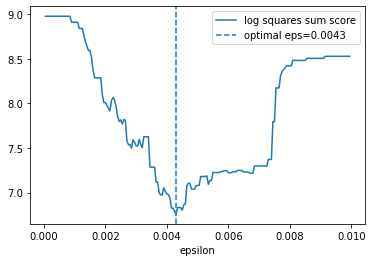

In [59]:
# min_samples = 3
# max_samples = 10
# epsilons = np.arange(0, 0.01, 0.00005)[1:]
# scores = []
# for eps in tqdm(epsilons):
#     clustering = autoscaling_dbscan(dist_df, eps=eps, min_samples=min_samples, max_samples=max_samples, verbose=False)
#     score = square_size_score(clustering)
#     scores.append(score)
scores = pd.Series(scores, epsilons, name='log squares sum score')
scores.index.name = 'epsilon'
optimal_eps = scores.index[scores.argmin()]
ax = scores.plot()
ax.axvline(optimal_eps, ls='--', label=f'optimal eps={optimal_eps}')
plt.legend()

In [61]:
clustering = autoscaling_dbscan(dist_df, eps=optimal_eps, min_samples=min_samples, max_samples=max_samples)

initial clusters


0
cluster: Albania, Algeria, Argentina, Armenia, ...  69
outside cluster: Australia, Bahrain, China, Den...  15
cluster: Burkina Faso, Kuwait, Senegal, Singapo...   5

final clustes


0
outside cluster: Australia, Bahrain, China, Cze...  21
cluster: Austria, Belarus, Germany, Ireland, No...   9
cluster: Azerbaijan, Costa Rica, Cuba, Hungary,...   8
cluster: Bosnia and Herzegovina, Dominican Repu...   7
cluster: Belgium, Canada, France, Italy, Nether...   7
cluster: Algeria, Argentina, Colombia, Congo (K...   6
cluster: Chile, Croatia, Moldova, Romania, Russ...   6
cluster: Burkina Faso, Kuwait, Senegal, Singapo...   5
cluster: Bulgaria, Kazakhstan, Philippines, Slo...   5
cluster: Armenia, Lithuania, Mauritius, New Zea...   4
cluster: Albania, Brazil, Kyrgyzstan, Lebanon        4
cluster: Bolivia, Georgia, Japan, West Bank and...   4
cluster: Iraq, Jordan, Thailand                      3

cluster  \
0   cluster too few cases   
1   cluster all countries   
2   outside cluster         
3   cluster 0               
4   cluster 1               
5   cluster 2               
6   cluster 3               
7   cluster 4               
8   cluster 5               
9   cluster 6               
10  cluster 7               
11  cluster 8               
12  cluster 9               
13  cluster 10              
14  cluster 11              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   countries  \
0   Afghanistan, Cameroon, Cote d'Ivoire, Egypt, El Salvador, Ghana, Guatemala, Guinea, Indonesia, Mexico, Niger, Pakistan, Paraguay, Rwanda, Sri Lanka, Uzbekistan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1   Albania, Algeria, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahrain, Belarus, Belgium, Bolivia, Bosnia and Herzegovina, Brazil, Bulgaria, Burkina Faso, Canada, Chile, China, Colombia, Congo (Kinshasa), Costa Rica, Croatia, Cuba, Czechia, Denmark, Djibouti, Dominican Republic, Ecuador, Estonia, Finland, France, Georgia, Germany, Greece, Honduras, Hungary, Iran, Iraq, Ireland, Israel, Italy, Japan, Jordan, Kazakhstan, Korea, South, Kuwait, Kyrgyzstan, Latvia, Lebanon, Lithuania, Malaysia, Mauritius, Moldova, Morocco, Netherlands, New Zealand, North Macedonia, Norway, Oman, Panama, Peru, Philippines, Poland, Portugal, Qatar, Romania, Russia, Saudi Arabia, Senegal, Serbia, Singapore, Slovakia, Slovenia, South Africa, Spain, Sweden, Switzerland, Taiwan*, Thailand, Trinidad and Tobago, Tunisia, Turkey, Ukraine, United Arab Emirates, United Kingdom, Uruguay, US, West Bank and Gaza, Kosovo   
2   Australia, Bahrain, China, Czechia, Denmark, Djibouti, Estonia, Greece, Israel, Korea, South, Oman, Peru, Qatar, Slovenia, South Africa, Sweden, Trinidad and Tobago, United Arab Emirates, Uruguay, US, Kosovo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

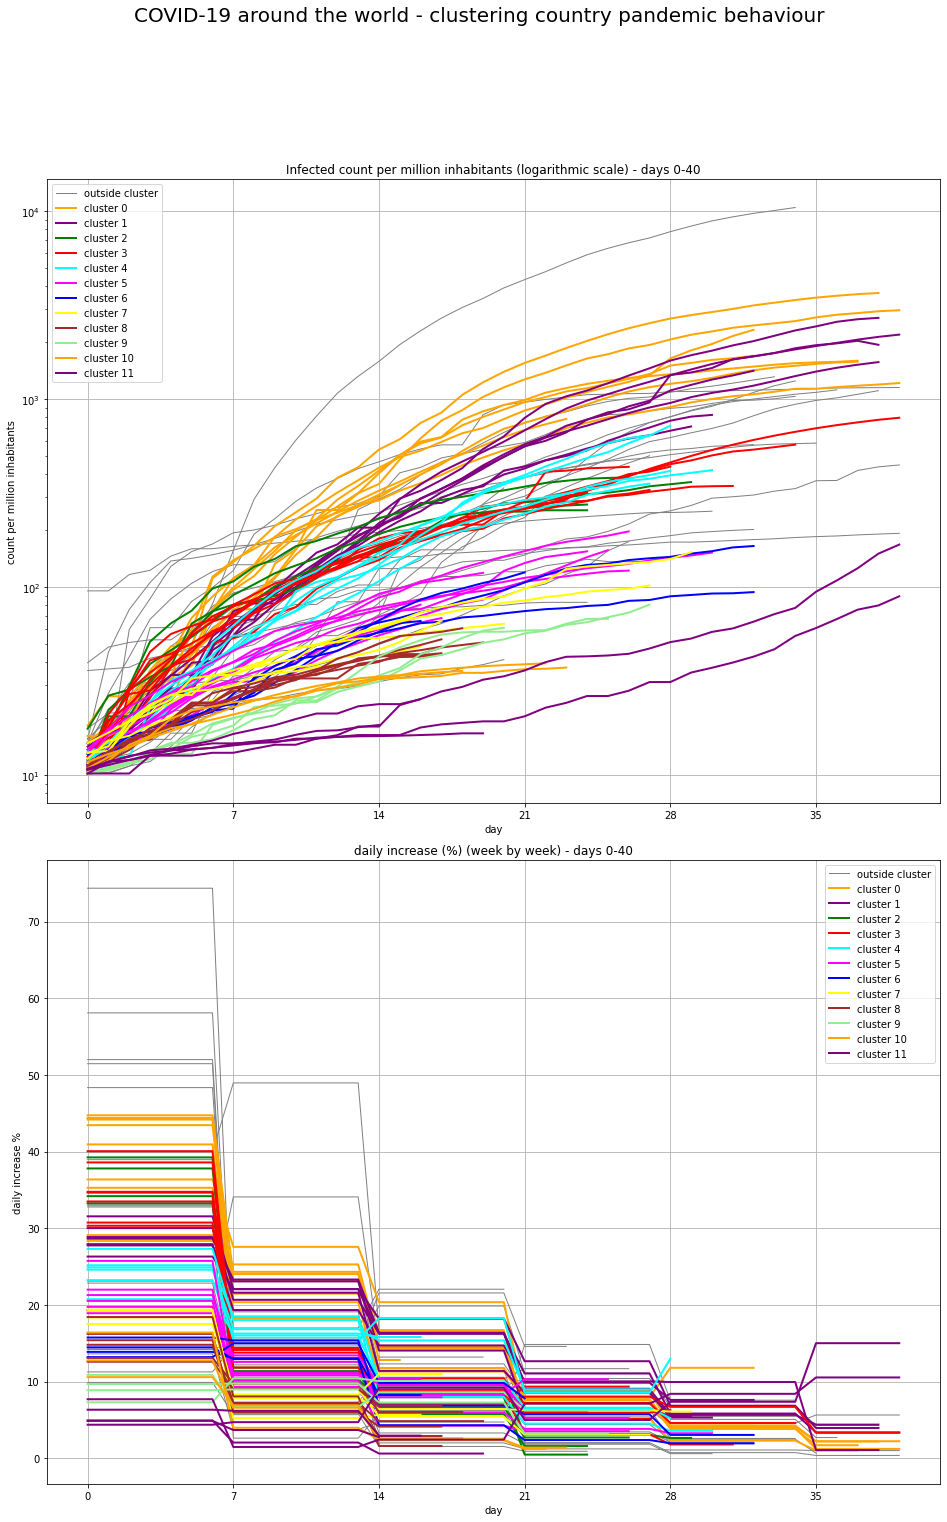

In [62]:
clustering = reorder_clusters(clustering, countries_for_clustering)
fig = plot_clustering_report(clustering, countries_for_clustering, countries_not_clustering, max_days=40)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.33it/s]


infected count  infected count per million current date  \
Spain                172541                        3663   2020-04-14   
Switzerland           25936                        3026   2020-04-14   
Ireland               11479                        2332   2020-04-14   
Portugal              17448                        1697   2020-04-14   
Austria               14226                        1597   2020-04-14   
Germany              131359                        1579   2020-04-14   
Norway                 6623                        1233   2020-04-14   
Turkey                65111                         783   2020-04-14   
Belarus                3281                         348   2020-04-14   

             daily increase % (smoothened over last 7 days)  \
Spain                                                 0.032   
Switzerland                                           0.025   
Ireland                                               0.103   
Portugal                                              0.054   
Austria                                               0.019   
Germany                                               0.033   
Norway                                                0.017   
Turkey                                                0.106   
Belarus                                               0.226   

             doubles every ... days  \
Spain                         22.18   
Switzerland                   28.42   
Ireland                        7.08   
Portugal                      13.21   
Austria                       36.58   
Germany                       21.12   
Norway                        40.94   
Turkey                         6.90   
Belarus                        3.40   

             days since at least 1 per million infected  \
Spain                                                38   
Switzerland                                          41   
Ireland                                              32   
Portugal                                             32   
Austria                                              37   
Germany                                              37   
Norway                                               41   
Turkey                                               23   
Belarus                                              15   

             days between 1st case and at least 10 per million infected  \
Spain                                                       35            
Switzerland                                                  8            
Ireland                                                     13            
Portugal                                                    11            
Austria                                                     12            
Germany                                                     41            
Norway                                                       7            
Turkey                                                      11            
Belarus                                                     31            

             population (million)  density (people per km2)  \
Spain                        47.1                      93.0   
Switzerland                   8.6                     208.0   
Ireland                       4.9                      70.0   
Portugal                     10.3                     112.0   
Austria                       8.9                     106.0   
Germany                      83.1                     233.0   
Norway                        5.4                      17.0   
Turkey                       83.2                     106.0   
Belarus                       9.4                      46.0   

             GDP per capita ($) (PPP)  ...  daily increase % week_1  \
Spain                         43007.0  ...                    0.215   
Switzerland                   67558.0  ...                    0.276   
Ireland                       86988.0  ...                    0.184   
Portugal     

Saved analysis to: output/covid/clustering/cluster_0/countries_comparison.xlsx


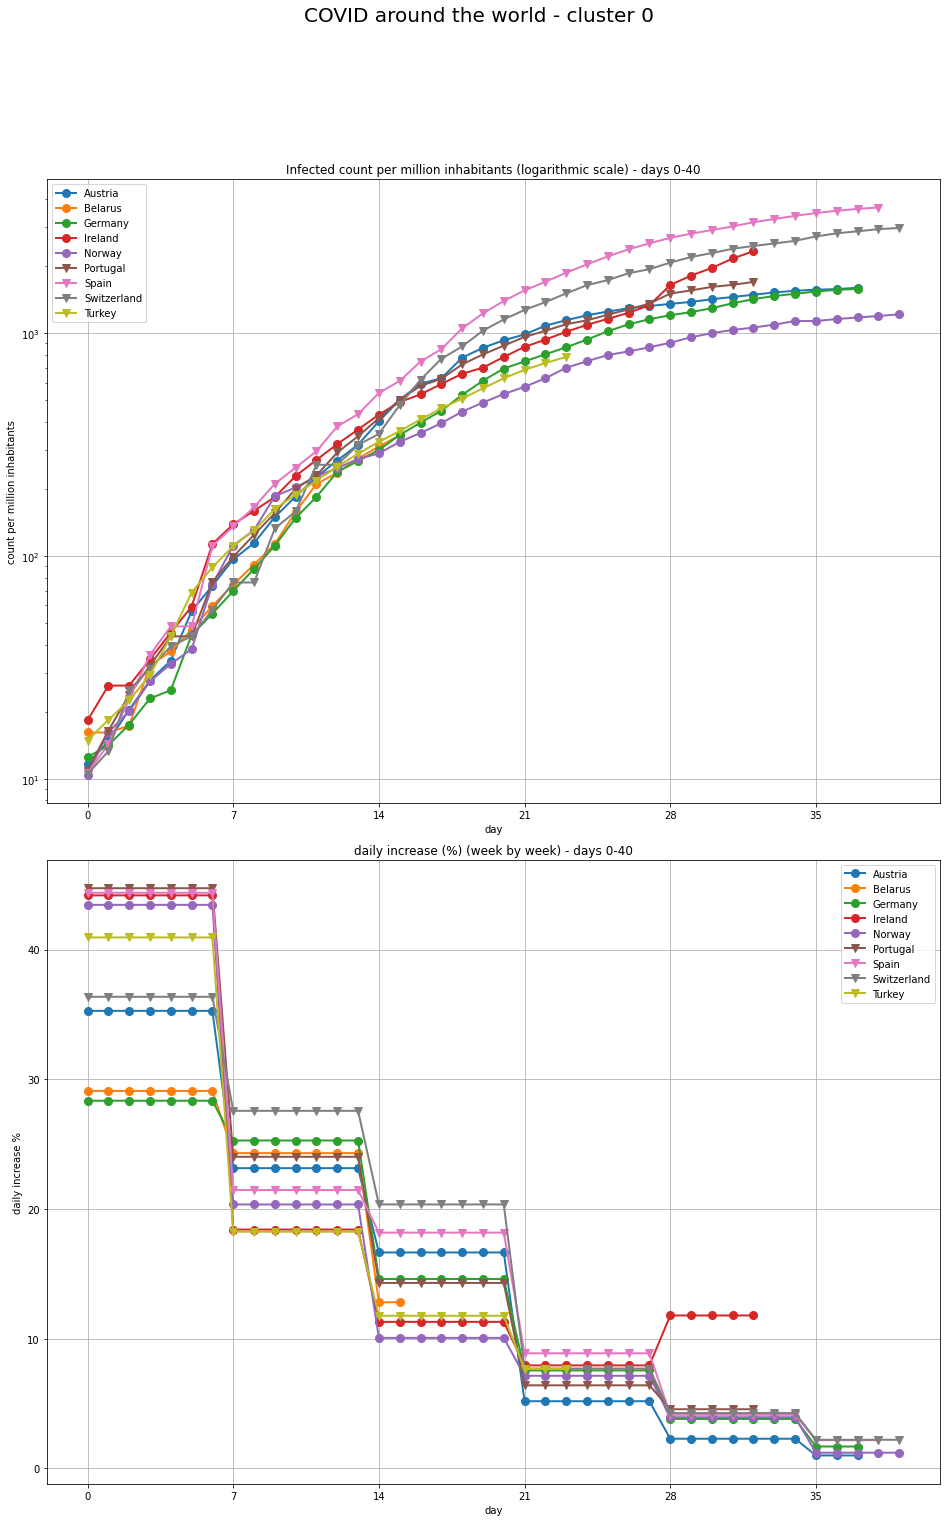

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_0/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


infected count  infected count per million current date  \
Belgium                  31119                        2702   2020-04-14   
Italy                   162488                        2697   2020-04-14   
France                  130253                        1941   2020-04-14   
Netherlands              27419                        1571   2020-04-14   
United Kingdom           93873                        1412   2020-04-14   
Panama                    3472                         822   2020-04-14   
Canada                   27034                         713   2020-04-14   

                daily increase % (smoothened over last 7 days)  \
Belgium                                                  0.057   
Italy                                                    0.027   
France                                                   0.049   
Netherlands                                              0.051   
United Kingdom                                           0.080   
Panama                                                   0.080   
Canada                                                   0.065   

                doubles every ... days  \
Belgium                          12.60   
Italy                            26.20   
France                           14.56   
Netherlands                      14.06   
United Kingdom                    8.97   
Panama                            9.04   
Canada                           11.06   

                days since at least 1 per million infected  \
Belgium                                                 38   
Italy                                                   47   
France                                                  38   
Netherlands                                             38   
United Kingdom                                          32   
Panama                                                  30   
Canada                                                  29   

                days between 1st case and at least 10 per million infected  \
Belgium                                                        32            
Italy                                                          27            
France                                                         43            
Netherlands                                                     9            
United Kingdom                                                 42            
Panama                                                          5            
Canada                                                         50            

                population (million)  density (people per km2)  \
Belgium                         11.5                     376.0   
Italy                           60.2                     200.0   
France                          67.1                     123.0   
Netherlands                     17.5                     420.0   
United Kingdom                  66.4                     274.0   
Panama                           4.2                      56.0   
Canada                          37.9                       5.4   

                GDP per capita ($) (PPP)  ...  daily increase % week_1  \
Belgium                          50904.0  ...                    0.221   
Italy                            41582.0  ...                    0.221   
France                           48640.0  ...                    0.193   
Netherlands                      60299.0  ...                    0.207   
United Kingdom                   48169.0  ...                    0.233   
Panama                           28456.0  ...                    0.216   
Canada                           52139.0  ...                    0.231   

                infected count per million week_1  daily increase % week_2  \
Belgium                                       195                    0.182   
Italy                                         206                    0.162   
France                                        188                    0.

Saved analysis to: output/covid/clustering/cluster_1/countries_comparison.xlsx


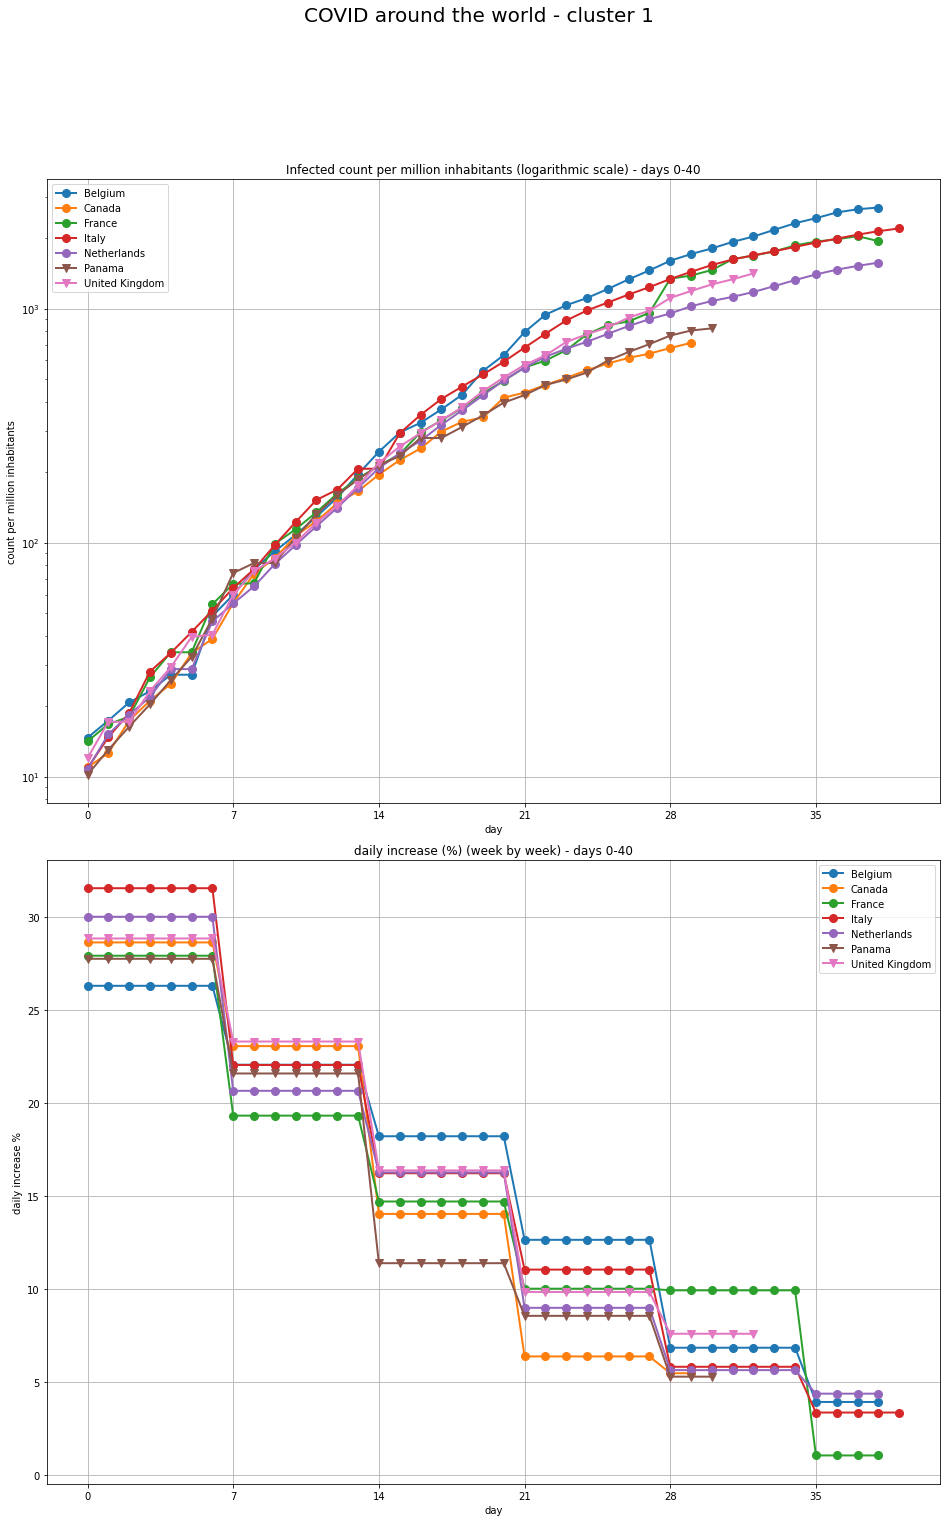

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_1/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]


infected count  infected count per million current date  \
Lithuania              1070                         383   2020-04-14   
Armenia                1067                         361   2020-04-14   
New Zealand            1366                         274   2020-04-14   
Mauritius               324                         255   2020-04-14   

             daily increase % (smoothened over last 7 days)  \
Lithuania                                             0.034   
Armenia                                               0.032   
New Zealand                                           0.029   
Mauritius                                             0.041   

             doubles every ... days  \
Lithuania                     21.01   
Armenia                       21.96   
New Zealand                   24.43   
Mauritius                     17.11   

             days since at least 1 per million infected  \
Lithuania                                            26   
Armenia                                              29   
New Zealand                                          24   
Mauritius                                            24   

             days between 1st case and at least 10 per million infected  \
Lithuania                                                   20            
Armenia                                                     15            
New Zealand                                                 22            
Mauritius                                                    3            

             population (million)  density (people per km2)  \
Lithuania                     2.8                      43.0   
Armenia                       3.0                     101.5   
New Zealand                   5.0                      18.0   
Mauritius                     1.3                     620.0   

             GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Lithuania                     38751.0                       19266.0   
Armenia                       11845.0                        4527.0   
New Zealand                   42045.0                       40634.0   
Mauritius                     26461.0                       11360.0   

             average yearly temperature (degree Celsius)  \
Lithuania                                            6.2   
Armenia                                              7.2   
New Zealand                                         10.6   
Mauritius                                           22.4   

             daily increase % week_0  infected count per million week_0  \
Lithuania                      0.392                                 98   
Armenia                        0.333                                 65   
New Zealand                    0.378                                 73   
Mauritius                      0.342                                 74   

             daily increase % week_1  infected count per million week_1  \
Lithuania                      0.113                                207   
Armenia                        0.118                                143   
New Zealand                    0.130                                174   
Mauritius                      0.102                                146   

             daily increase % week_2  infected count per million week_2  \
Lithuania                      0.067                                326   
Armenia                        0.099                                278   
New Zealand                    0.057                                257   
Mauritius                      0.080                                251   

             daily increase % week_3  infected count per million week_3  
Lithuania                        NaN                                NaN  
Armenia                         0.03                              343.0  
New Zealand                      NaN                                NaN  
Mauritius                        NaN                                NaN

Saved analysis to: output/covid/clustering/cluster_2/countries_comparison.xlsx


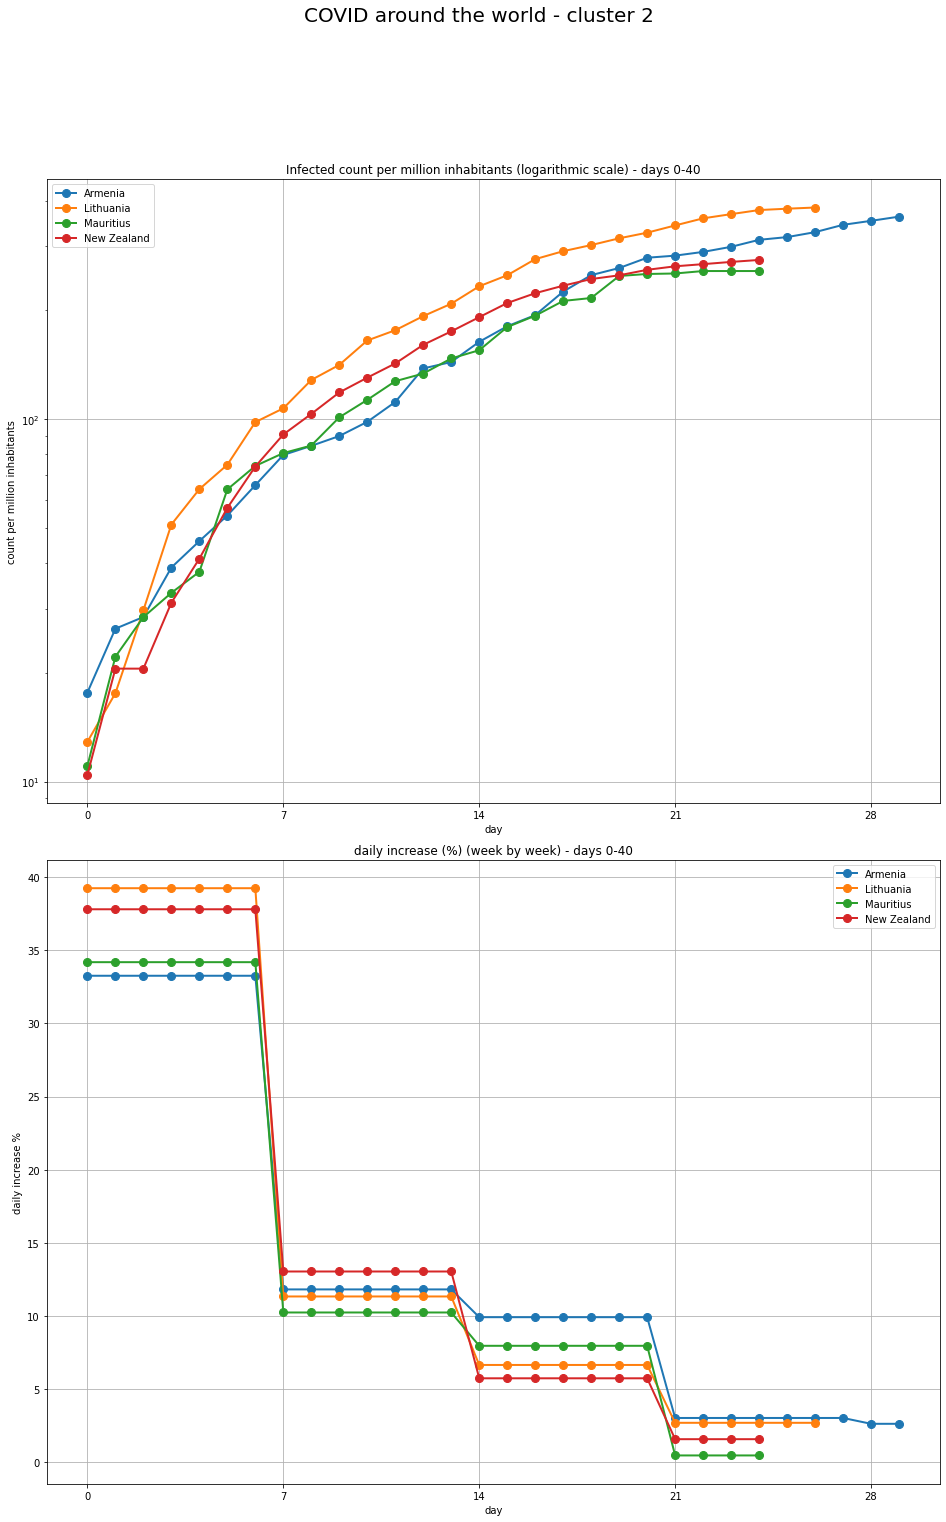

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_2/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.40it/s]


infected count  infected count per million  \
Iran                             74877                         898   
Finland                           3161                         571   
North Macedonia                    908                         437   
Ecuador                           7603                         435   
Latvia                             657                         344   
Bosnia and Herzegovina            1083                         328   
Dominican Republic                3286                         317   

                       current date  \
Iran                     2020-04-14   
Finland                  2020-04-14   
North Macedonia          2020-04-14   
Ecuador                  2020-04-14   
Latvia                   2020-04-14   
Bosnia and Herzegovina   2020-04-14   
Dominican Republic       2020-04-14   

                        daily increase % (smoothened over last 7 days)  \
Iran                                                             0.028   
Finland                                                          0.050   
North Macedonia                                                  0.059   
Ecuador                                                          0.105   
Latvia                                                           0.027   
Bosnia and Herzegovina                                           0.063   
Dominican Republic                                               0.082   

                        doubles every ... days  \
Iran                                     25.28   
Finland                                  14.18   
North Macedonia                          12.00   
Ecuador                                   6.95   
Latvia                                   25.62   
Bosnia and Herzegovina                   11.26   
Dominican Republic                        8.83   

                        days since at least 1 per million infected  \
Iran                                                            44   
Finland                                                         34   
North Macedonia                                                 28   
Ecuador                                                         26   
Latvia                                                          31   
Bosnia and Herzegovina                                          27   
Dominican Republic                                              24   

                        days between 1st case and at least 10 per million infected  \
Iran                                                                   11            
Finland                                                                42            
North Macedonia                                                        20            
Ecuador                                                                18            
Latvia                                                                 12            
Bosnia and Herzegovina                                                 13            
Dominican Republic                                                     20            

                        population (million)  density (people per km2)  \
Iran                                    83.3                      51.0   
Finland                                  5.5                      16.0   
North Macedonia                          2.1                      81.0   
Ecuador                                 17.5                      63.0   
Latvia                                   1.9                      30.0   
Bosnia and Herzegovina                   3.3                      69.0   
Dominican Republic                      10.4                     216.0   

                        GDP per capita ($) (PPP)  ...  \
Iran                                     17832.0  ...   
Finland                                  49548.0  ...   
North Macedonia                          17378.0  ...   
Ecuador                                  11866.0  ...   
Latvia                      

Saved analysis to: output/covid/clustering/cluster_3/countries_comparison.xlsx


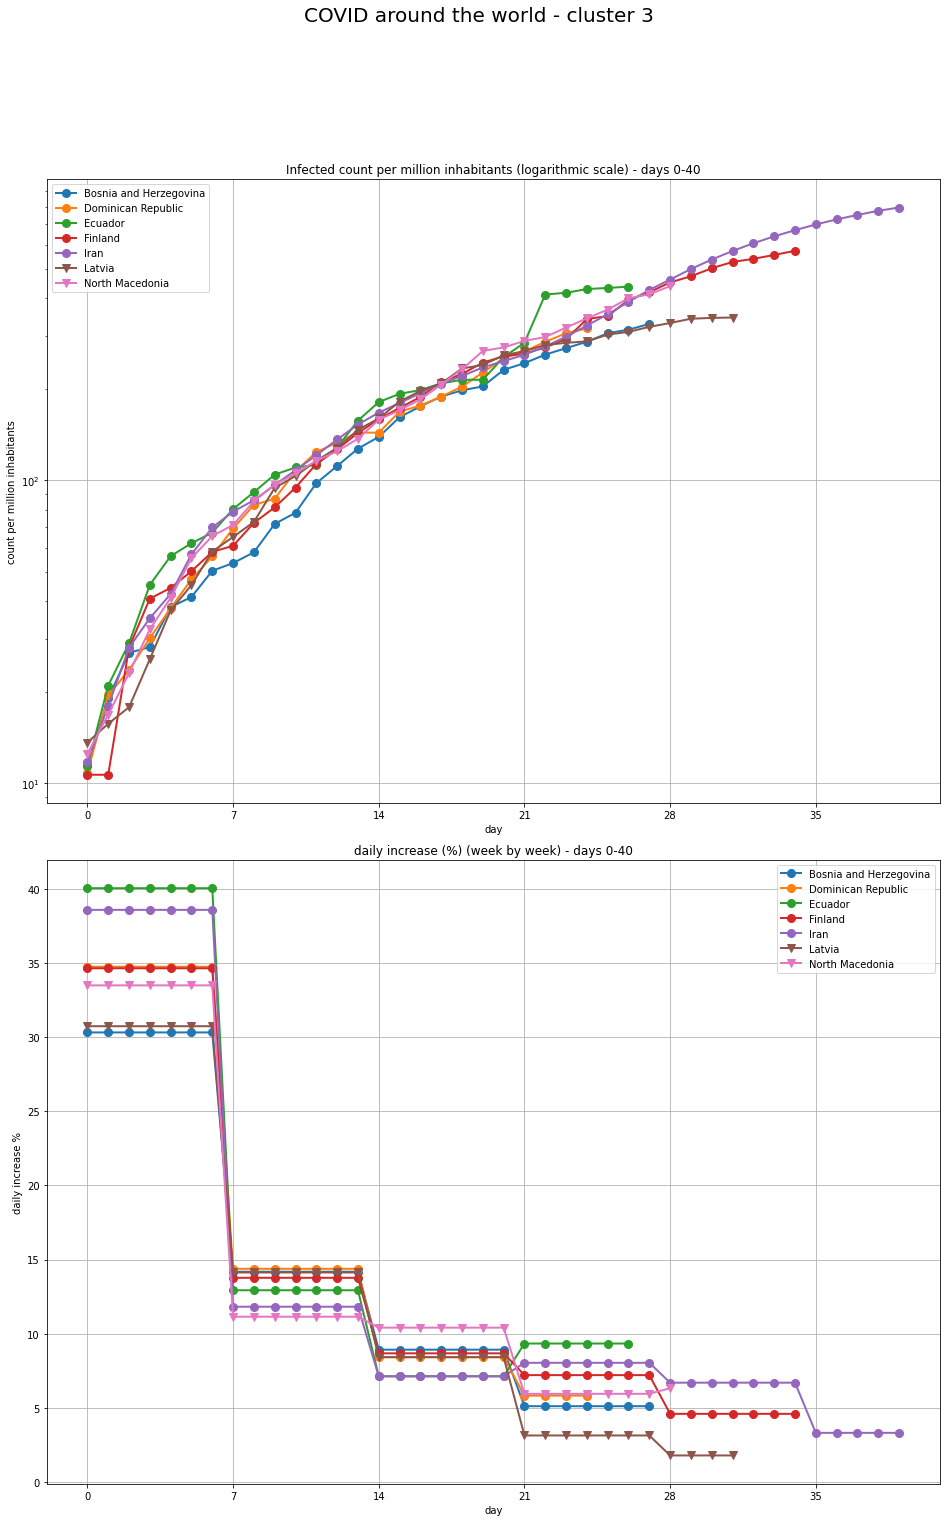

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_3/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.45it/s]


infected count  infected count per million current date  \
Moldova            1934                         721   2020-04-14   
Serbia             4465                         641   2020-04-14   
Croatia            1704                         418   2020-04-14   
Chile              7917                         414   2020-04-14   
Romania            6879                         354   2020-04-14   
Russia            21102                         143   2020-04-14   

         daily increase % (smoothened over last 7 days)  \
Moldova                                           0.085   
Serbia                                            0.091   
Croatia                                           0.044   
Chile                                             0.066   
Romania                                           0.073   
Russia                                            0.164   

         doubles every ... days  days since at least 1 per million infected  \
Moldova                    8.46                                          28   
Serbia                     7.94                                          27   
Croatia                   16.16                                          30   
Chile                     10.87                                          28   
Romania                    9.87                                          27   
Russia                     4.57                                          16   

         days between 1st case and at least 10 per million infected  \
Moldova                                                  9            
Serbia                                                  12            
Croatia                                                 19            
Chile                                                   14            
Romania                                                 21            
Russia                                                  58            

         population (million)  density (people per km2)  \
Moldova                   2.7                      79.0   
Serbia                    7.0                      89.0   
Croatia                   4.1                     102.0   
Chile                    19.1                      23.0   
Romania                  19.4                      81.0   
Russia                  146.7                       9.0   

         GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Moldova                    8161.0                        3300.0   
Serbia                    19767.0                        7397.0   
Croatia                   29207.0                       14949.0   
Chile                     27150.0                       15399.0   
Romania                   29555.0                       12482.0   
Russia                    30820.0                       11162.0   

         average yearly temperature (degree Celsius)  daily increase % week_0  \
Moldova                                          9.4                    0.249   
Serbia                                          10.6                    0.246   
Croatia                                         10.9                    0.273   
Chile                                            8.4                    0.252   
Romania                                          8.8                    0.232   
Russia                                          -5.1                    0.207   

         infected count per million week_0  daily increase % week_1  \
Moldova                                 40                    0.155   
Serbia                                  43                    0.168   
Croatia                                 50                    0.180   
Chile                                   39                    0.185   
Romania                                 40                    0.160   
Russia                                  32                    0.163   

         infected count per million week_1  daily increase % week_2  \
Moldova                                111   

Saved analysis to: output/covid/clustering/cluster_4/countries_comparison.xlsx


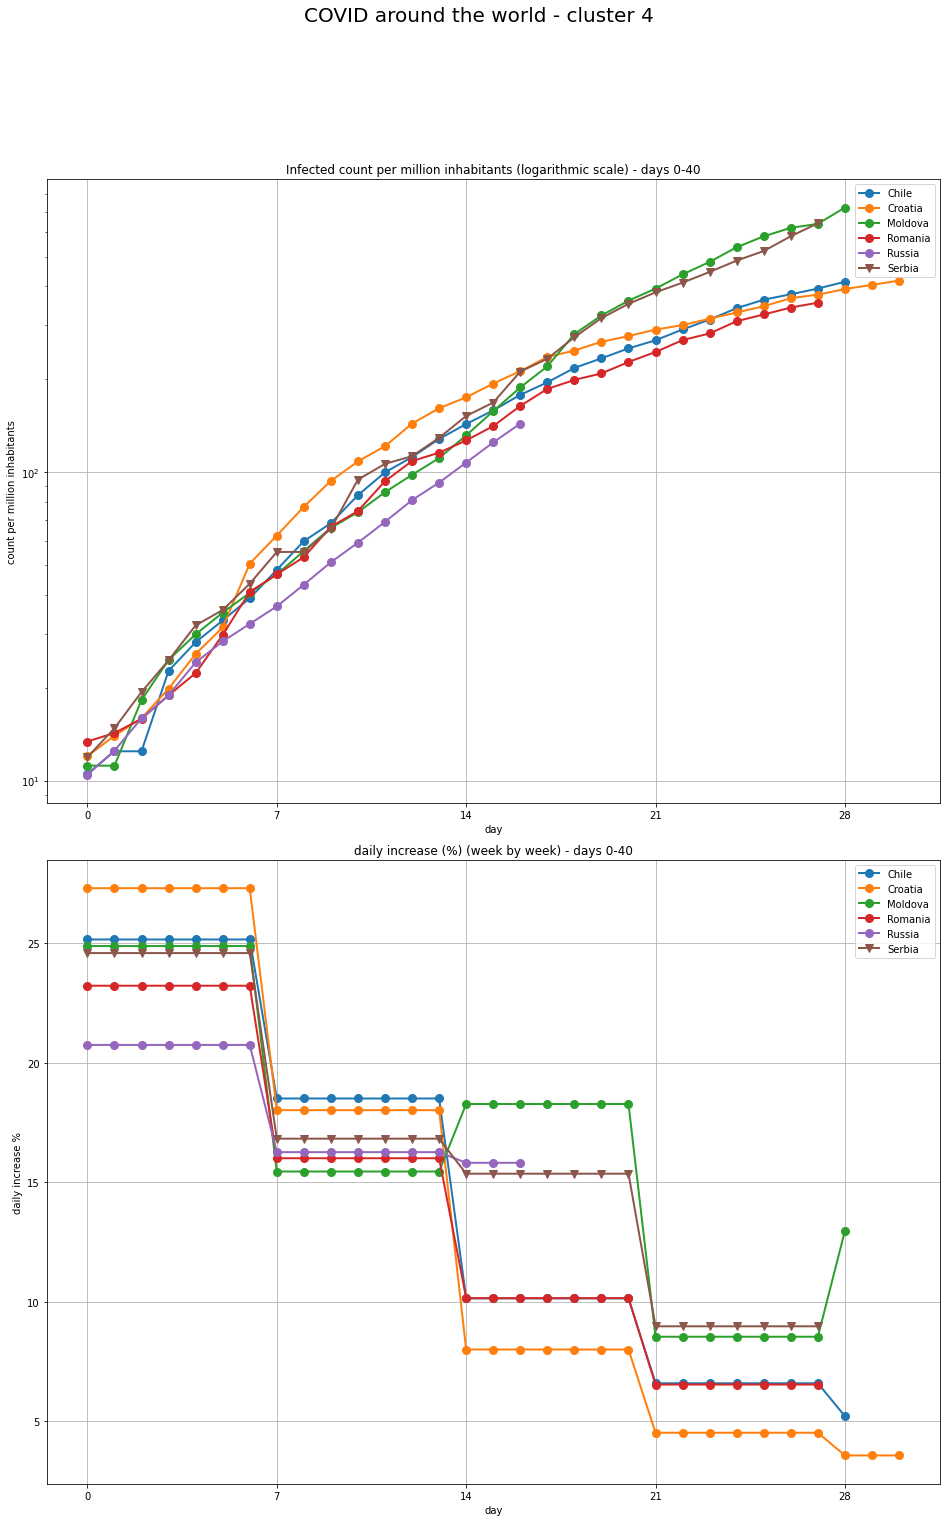

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_4/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s]


infected count  infected count per million current date  \
Poland                  7582                         197   2020-04-15   
Saudi Arabia            5369                         156   2020-04-14   
Hungary                 1512                         154   2020-04-14   
Malaysia                4987                         152   2020-04-14   
Costa Rica               618                         122   2020-04-14   
Azerbaijan              1197                         118   2020-04-14   
Ukraine                 3372                          80   2020-04-14   
Cuba                     766                          68   2020-04-14   

              daily increase % (smoothened over last 7 days)  \
Poland                                                 0.058   
Saudi Arabia                                           0.096   
Hungary                                                0.101   
Malaysia                                               0.035   
Costa Rica                                             0.039   
Azerbaijan                                             0.087   
Ukraine                                                0.130   
Cuba                                                   0.110   

              doubles every ... days  \
Poland                         12.26   
Saudi Arabia                    7.60   
Hungary                         7.21   
Malaysia                       20.30   
Costa Rica                     17.94   
Azerbaijan                      8.33   
Ukraine                         5.67   
Cuba                            6.65   

              days since at least 1 per million infected  \
Poland                                                26   
Saudi Arabia                                          25   
Hungary                                               24   
Malaysia                                              30   
Costa Rica                                            26   
Azerbaijan                                            19   
Ukraine                                               16   
Cuba                                                  17   

              days between 1st case and at least 10 per million infected  \
Poland                                                       16            
Saudi Arabia                                                 18            
Hungary                                                      17            
Malaysia                                                     50            
Costa Rica                                                   13            
Azerbaijan                                                   25            
Ukraine                                                      26            
Cuba                                                         16            

              population (million)  density (people per km2)  \
Poland                        38.4                     123.0   
Saudi Arabia                  34.2                      16.0   
Hungary                        9.8                     105.0   
Malaysia                      32.7                      99.0   
Costa Rica                     5.1                      99.0   
Azerbaijan                    10.1                     116.0   
Ukraine                       41.9                      69.0   
Cuba                          11.2                     102.0   

              GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Poland                         35651.0                       14901.0   
Saudi Arabia                   56912.0                       22865.0   
Hungary                        35941.0                       17463.0   
Malaysia                       34567.0                       11136.0   
Costa Rica                     18651.0                       12014.0   
Azerbaijan                     19156.0                        4689.0   
Ukraine                        10130.0                        3592.0   
Cuba                           22237.0 

Saved analysis to: output/covid/clustering/cluster_5/countries_comparison.xlsx


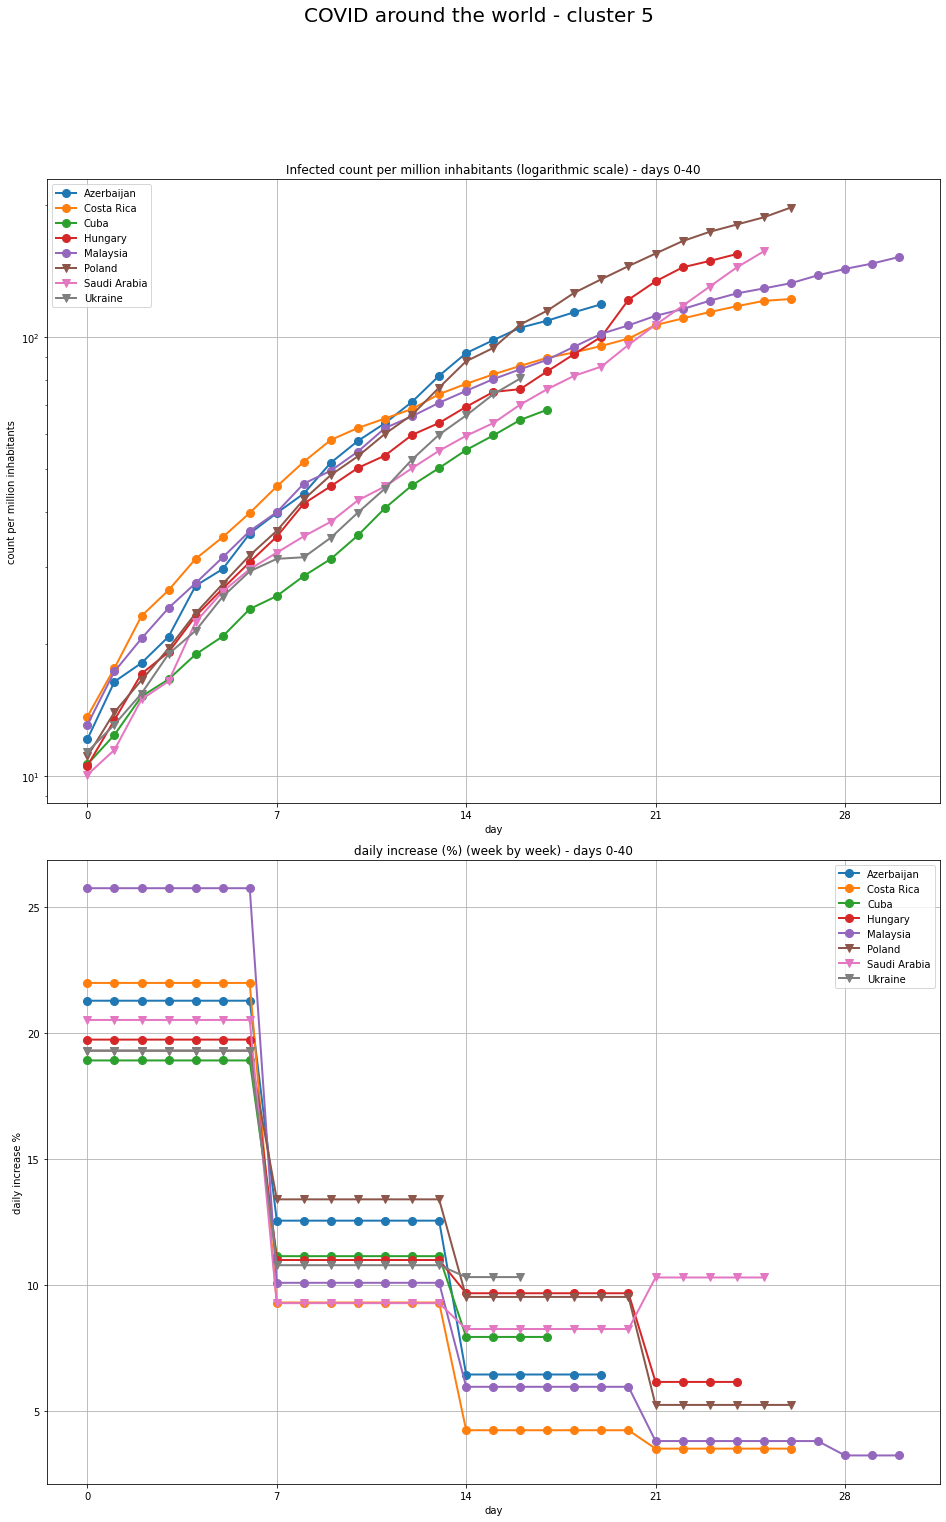

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_5/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s]


infected count  infected count per million current date  \
Albania                475                         165   2020-04-14   
Brazil               25262                         119   2020-04-14   
Lebanon                641                          93   2020-04-14   
Kyrgyzstan             430                          65   2020-04-14   

            daily increase % (smoothened over last 7 days)  \
Albania                                              0.031   
Brazil                                               0.098   
Lebanon                                              0.022   
Kyrgyzstan                                           0.099   

            doubles every ... days  \
Albania                      22.66   
Brazil                        7.40   
Lebanon                      31.21   
Kyrgyzstan                    7.32   

            days since at least 1 per million infected  \
Albania                                             32   
Brazil                                              21   
Lebanon                                             32   
Kyrgyzstan                                          16   

            days between 1st case and at least 10 per million infected  \
Albania                                                     4            
Brazil                                                     27            
Lebanon                                                    21            
Kyrgyzstan                                                 11            

            population (million)  density (people per km2)  \
Albania                      2.9                      98.0   
Brazil                     211.3                      25.0   
Lebanon                      6.8                     672.0   
Kyrgyzstan                   6.5                      32.0   

            GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Albania                      14866.0                        5372.0   
Brazil                       17106.0                        8796.0   
Lebanon                      15599.0                        9654.0   
Kyrgyzstan                    4193.0                        1292.0   

            average yearly temperature (degree Celsius)  \
Albania                                            11.4   
Brazil                                             25.0   
Lebanon                                            16.4   
Kyrgyzstan                                          1.6   

            daily increase % week_0  infected count per million week_0  \
Albania                       0.157                                 22   
Brazil                        0.132                                 21   
Lebanon                       0.145                                 23   
Kyrgyzstan                    0.139                                 22   

            daily increase % week_1  infected count per million week_1  \
Albania                       0.154                                 60   
Brazil                        0.150                                 57   
Lebanon                       0.129                                 53   
Kyrgyzstan                    0.130                                 51   

            daily increase % week_2  infected count per million week_2  \
Albania                       0.069                               96.0   
Brazil                        0.098                              110.0   
Lebanon                       0.043                               72.0   
Kyrgyzstan                      NaN                                NaN   

            daily increase % week_3  infected count per million week_3  
Albania                       0.057                              142.0  
Brazil                          NaN                                NaN  
Lebanon                       0.024                               85.0  
Kyrgyzstan                      NaN                                NaN

Saved analysis to: output/covid/clustering/cluster_6/countries_comparison.xlsx


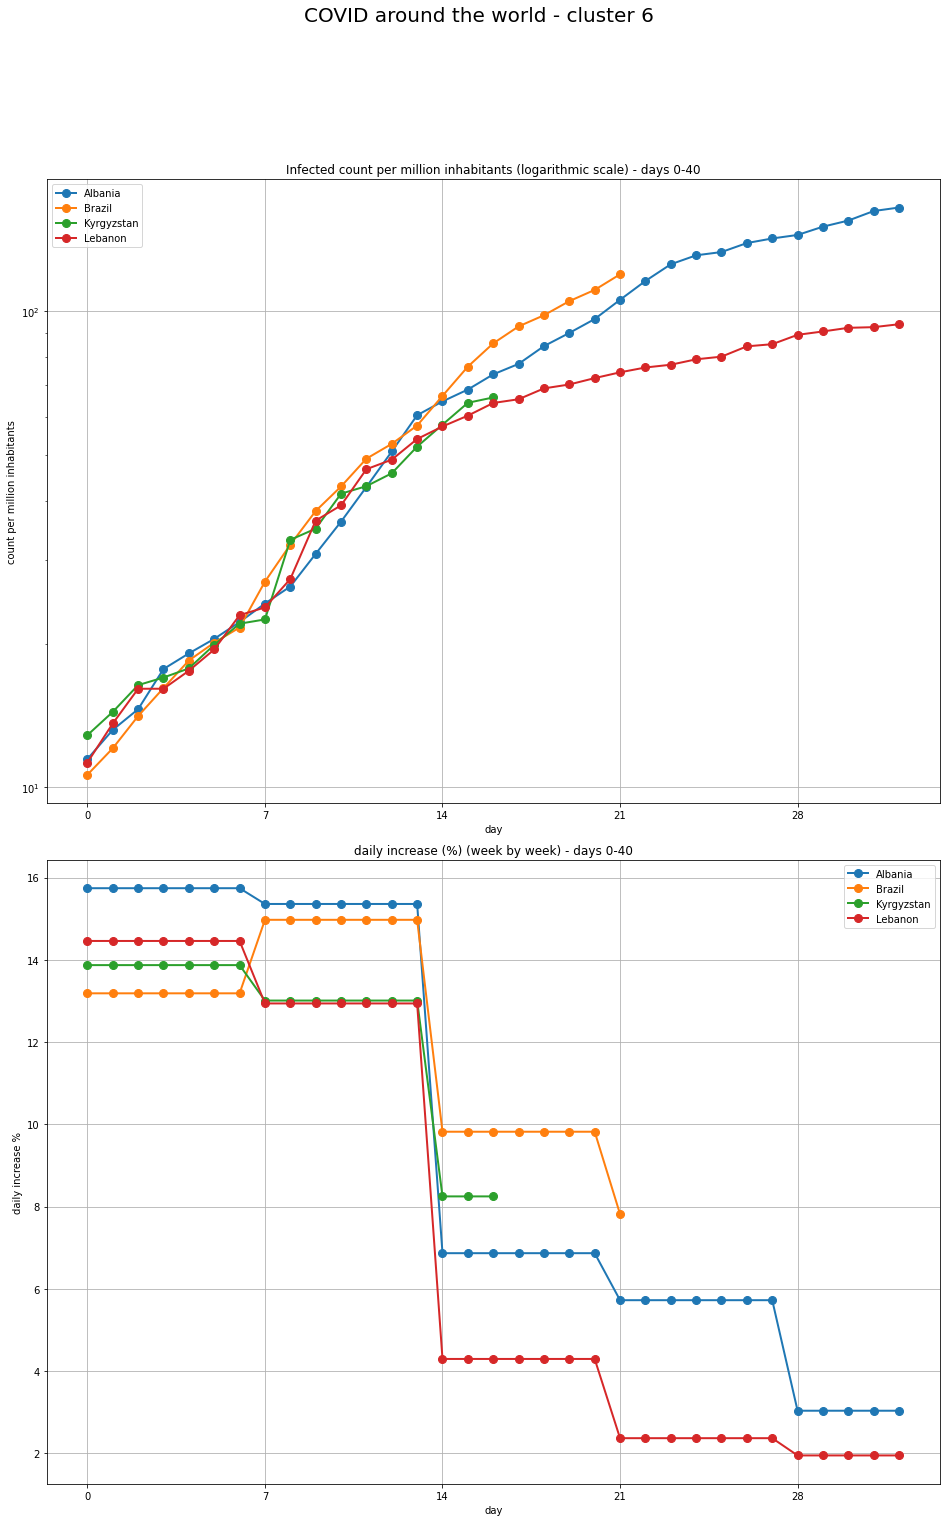

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_6/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.62it/s]


infected count  infected count per million current date  \
Slovakia                835                         153   2020-04-14   
Bulgaria                713                         101   2020-04-14   
Kazakhstan             1232                          65   2020-04-14   
Tunisia                 747                          63   2020-04-14   
Philippines            5223                          48   2020-04-14   

             daily increase % (smoothened over last 7 days)  \
Slovakia                                              0.053   
Bulgaria                                              0.032   
Kazakhstan                                            0.074   
Tunisia                                               0.029   
Philippines                                           0.044   

             doubles every ... days  \
Slovakia                      13.30   
Bulgaria                      21.92   
Kazakhstan                     9.71   
Tunisia                       24.59   
Philippines                   16.27   

             days since at least 1 per million infected  \
Slovakia                                             29   
Bulgaria                                             27   
Kazakhstan                                           17   
Tunisia                                              20   
Philippines                                          16   

             days between 1st case and at least 10 per million infected  \
Slovakia                                                    10            
Bulgaria                                                    10            
Kazakhstan                                                  15            
Tunisia                                                     21            
Philippines                                                 59            

             population (million)  density (people per km2)  \
Slovakia                      5.5                     111.0   
Bulgaria                      7.0                      63.0   
Kazakhstan                   18.7                       7.0   
Tunisia                      11.7                      72.0   
Philippines                 108.5                     362.0   

             GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Slovakia                      38321.0                       19547.0   
Bulgaria                      26034.0                        9518.0   
Kazakhstan                    30178.0                        9139.0   
Tunisia                       13093.0                        3287.0   
Philippines                   10094.0                        3294.0   

             average yearly temperature (degree Celsius)  \
Slovakia                                             6.8   
Bulgaria                                            10.6   
Kazakhstan                                           6.4   
Tunisia                                             19.2   
Philippines                                         25.8   

             daily increase % week_0  infected count per million week_0  \
Slovakia                       0.192                                 33   
Bulgaria                       0.184                                 31   
Kazakhstan                     0.175                                 24   
Tunisia                        0.194                                 33   
Philippines                    0.163                                 28   

             daily increase % week_1  infected count per million week_1  \
Slovakia                       0.079                                 57   
Bulgaria                       0.090                                 56   
Kazakhstan                     0.083                                 43   
Tunisia                        0.068                                 53   
Philippines                    0.053                                 40   

             daily increase % week_2  infected count per million week_2  \
Slovakia        

Saved analysis to: output/covid/clustering/cluster_7/countries_comparison.xlsx


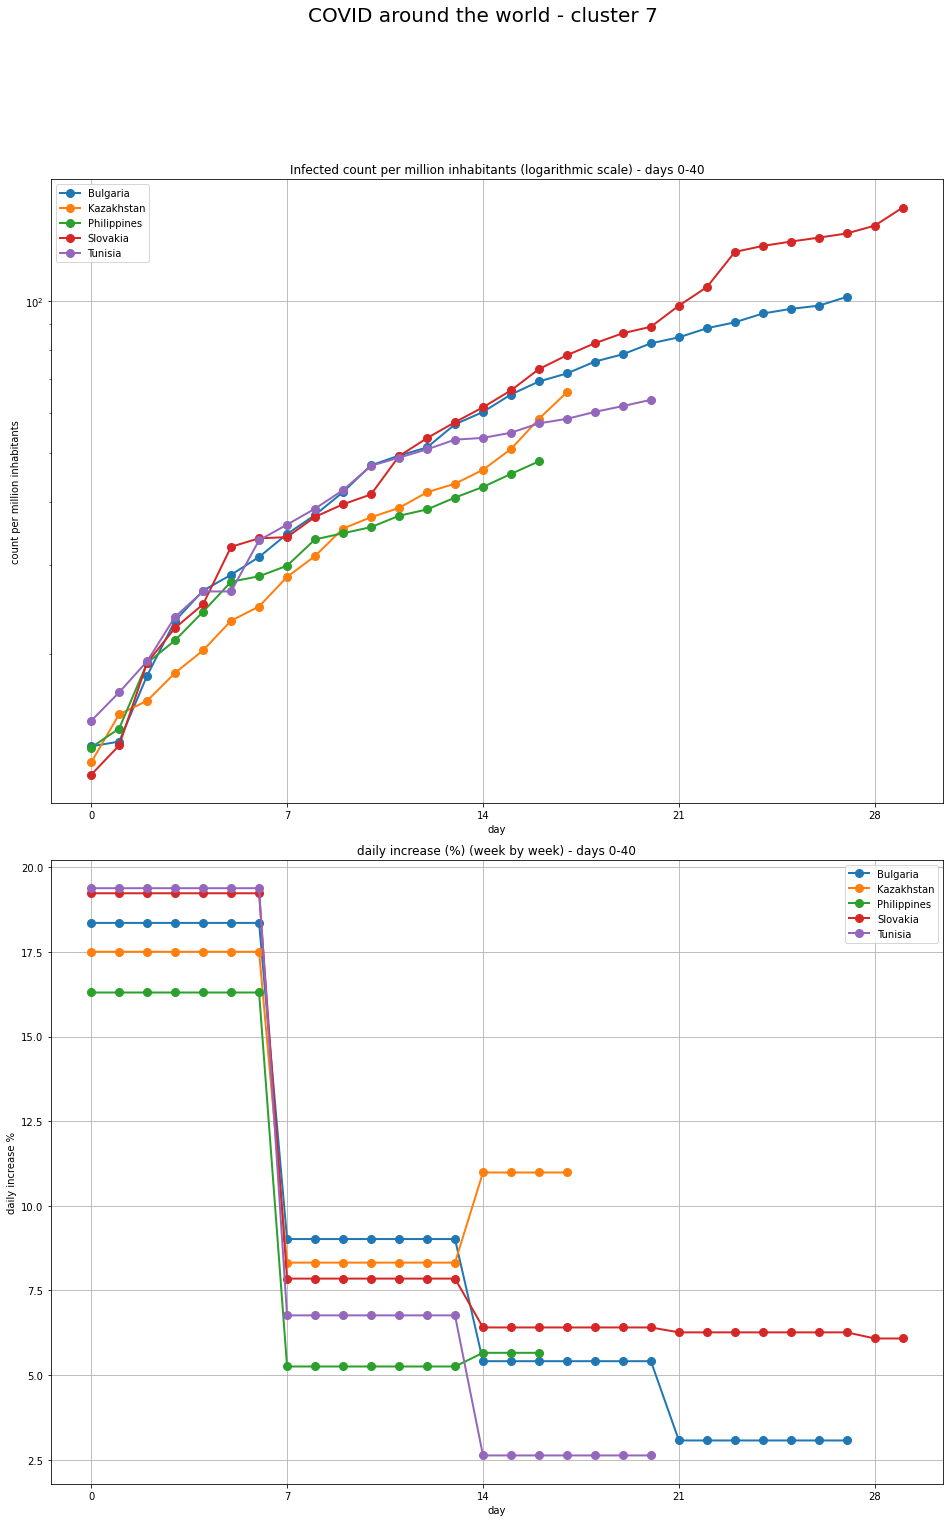

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_7/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]


infected count  infected count per million current date  \
Colombia                    2979                          60   2020-04-14   
Morocco                     1888                          52   2020-04-14   
Argentina                   2277                          50   2020-04-14   
Algeria                     2070                          48   2020-04-14   
Honduras                     407                          44   2020-04-14   
Congo (Kinshasa)             241                          43   2020-04-14   

                  daily increase % (smoothened over last 7 days)  \
Colombia                                                   0.088   
Morocco                                                    0.067   
Argentina                                                  0.051   
Algeria                                                    0.049   
Honduras                                                   0.042   
Congo (Kinshasa)                                           0.056   

                  doubles every ... days  \
Colombia                            8.21   
Morocco                            10.69   
Argentina                          13.81   
Algeria                            14.62   
Honduras                           16.92   
Congo (Kinshasa)                   12.83   

                  days since at least 1 per million infected  \
Colombia                                                  18   
Morocco                                                   17   
Argentina                                                 19   
Algeria                                                   17   
Honduras                                                  17   
Congo (Kinshasa)                                          17   

                  days between 1st case and at least 10 per million infected  \
Colombia                                                         21            
Morocco                                                          26            
Argentina                                                        23            
Algeria                                                          32            
Honduras                                                         17            
Congo (Kinshasa)                                                 17            

                  population (million)  density (people per km2)  \
Colombia                          49.4                      40.0   
Morocco                           35.9                      80.0   
Argentina                         44.9                      14.4   
Algeria                           43.0                      18.0   
Honduras                           9.2                      81.0   
Congo (Kinshasa)                   5.5                       2.4   

                  GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Colombia                           16265.0                        6508.0   
Morocco                             9667.0                        3345.0   
Argentina                          19971.0                        9887.0   
Algeria                            16091.0                        3980.0   
Honduras                            5600.0                        2548.0   
Congo (Kinshasa)                     843.0                         500.0   

                  average yearly temperature (degree Celsius)  \
Colombia                                                 24.5   
Morocco                                                  17.1   
Argentina                                                14.8   
Algeria                                                  22.5   
Honduras                                                 23.5   
Congo (Kinshasa)                                         24.0   

                  daily increase % week_0  infected count per million week_0  \
Colombia                            0.131                                 23   
Morocco                             0.126               

Saved analysis to: output/covid/clustering/cluster_8/countries_comparison.xlsx


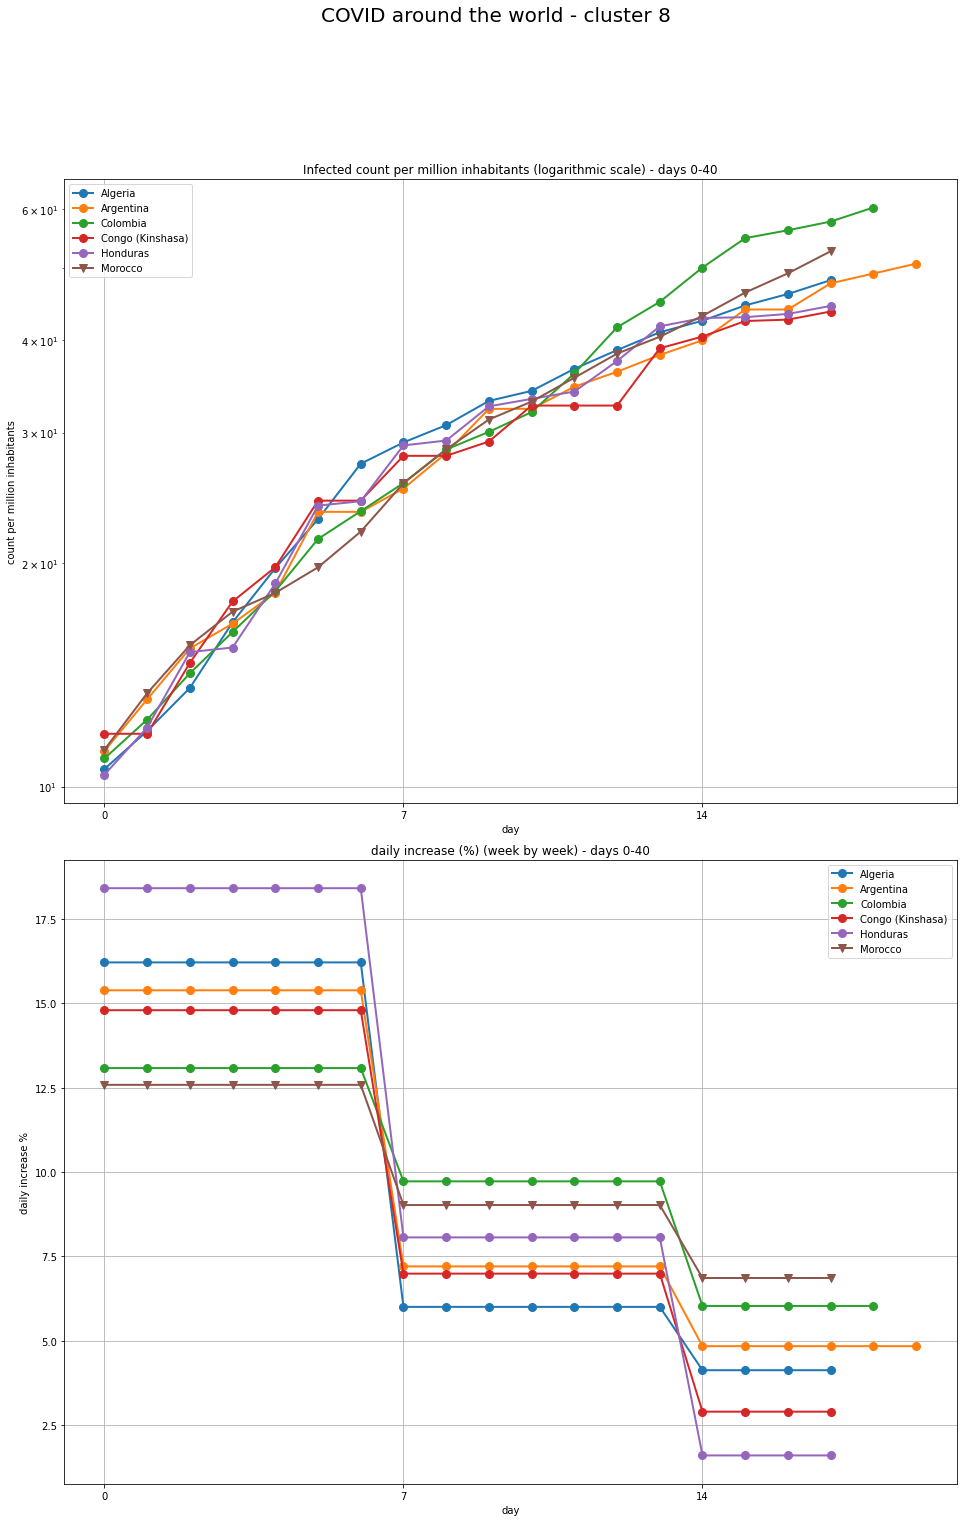

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_8/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


infected count  infected count per million current date  \
Georgia                        300                          80   2020-04-14   
West Bank and Gaza             308                          67   2020-04-14   
Japan                         7645                          60   2020-04-14   
Bolivia                        354                          30   2020-04-14   

                    daily increase % (smoothened over last 7 days)  \
Georgia                                                      0.054   
West Bank and Gaza                                           0.028   
Japan                                                        0.105   
Bolivia                                                      0.088   

                    doubles every ... days  \
Georgia                              13.14   
West Bank and Gaza                   25.17   
Japan                                 6.92   
Bolivia                               8.23   

                    days since at least 1 per million infected  \
Georgia                                                     27   
West Bank and Gaza                                          25   
Japan                                                       20   
Bolivia                                                     13   

                    days between 1st case and at least 10 per million infected  \
Georgia                                                            21            
West Bank and Gaza                                                 15            
Japan                                                              63            
Bolivia                                                            21            

                    population (million)  density (people per km2)  \
Georgia                              3.7                      54.0   
West Bank and Gaza                   4.6                     654.0   
Japan                              126.0                     333.0   
Bolivia                             11.5                      10.0   

                    GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Georgia                              13200.0                        4289.0   
West Bank and Gaza                    5157.0                        3199.0   
Japan                                46827.0                       40846.0   
Bolivia                               8525.0                        3670.0   

                    average yearly temperature (degree Celsius)  \
Georgia                                                     5.8   
West Bank and Gaza                                         22.9   
Japan                                                      11.2   
Bolivia                                                    21.6   

                    daily increase % week_0  \
Georgia                               0.109   
West Bank and Gaza                    0.097   
Japan                                 0.073   
Bolivia                               0.089   

                    infected count per million week_0  \
Georgia                                            18   
West Bank and Gaza                                 18   
Japan                                              15   
Bolivia                                            16   

                    daily increase % week_1  \
Georgia                               0.067   
West Bank and Gaza                    0.097   
Japan                                 0.104   
Bolivia                               0.090   

                    infected count per million week_1  \
Georgia                                            29   
West Bank and Gaza                                 35   
Japan                                              31   
Bolivia                                            30   

                    daily increase % week_2  \
Georgia                               0.086   
West Bank and Gaza                    0.073   
Japan                                

Saved analysis to: output/covid/clustering/cluster_9/countries_comparison.xlsx


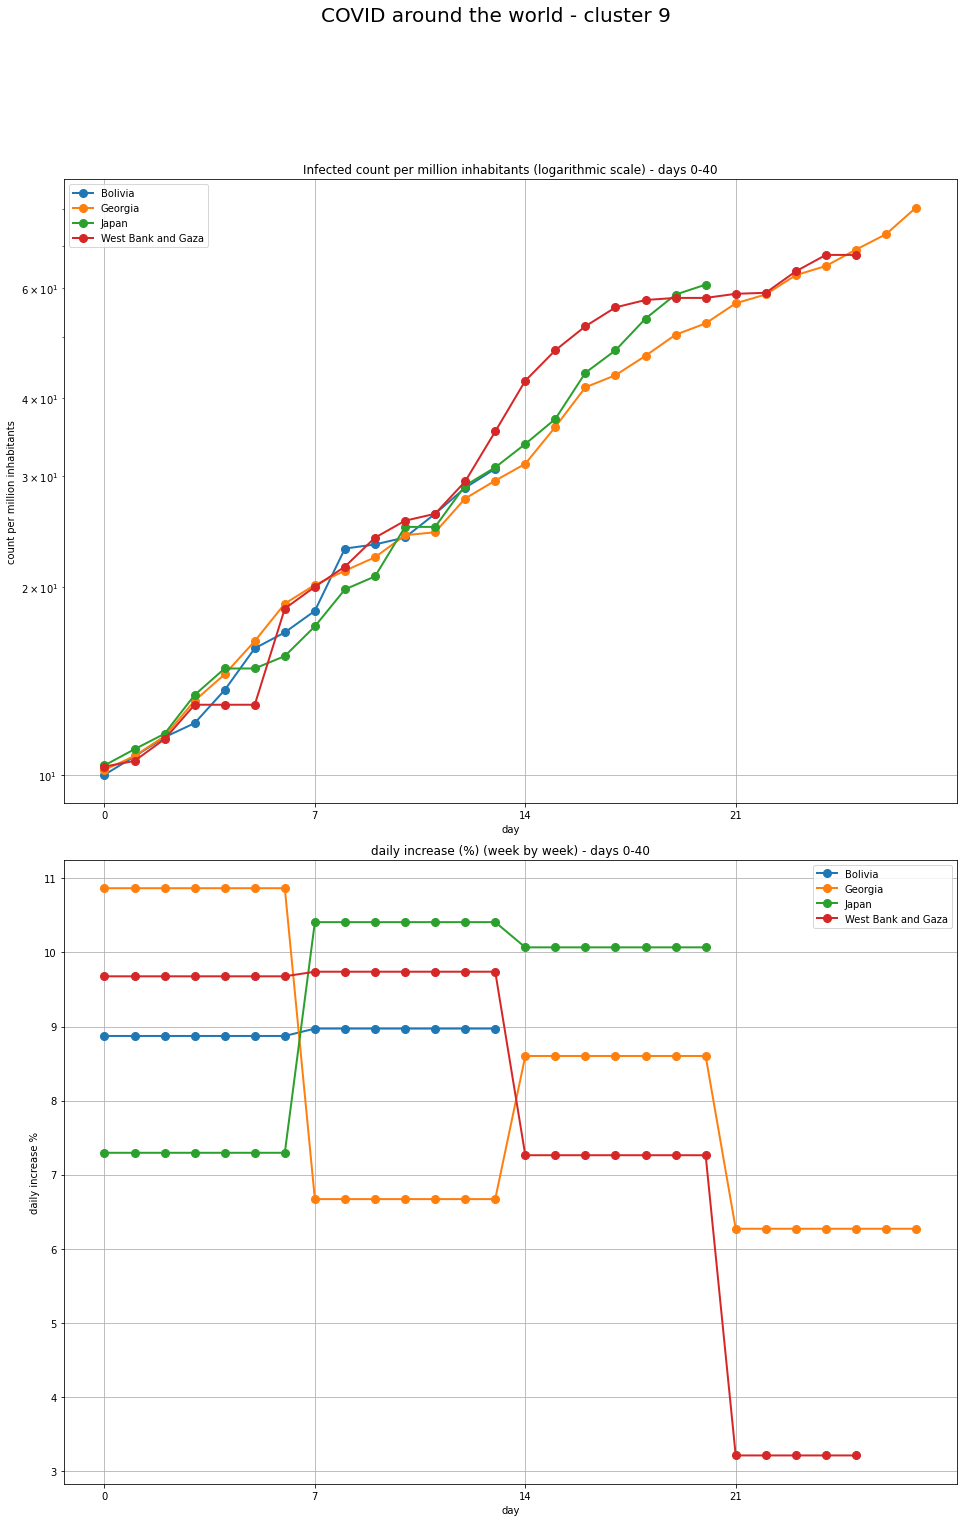

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_9/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


infected count  infected count per million current date  \
Thailand            2613                          39   2020-04-14   
Jordan               397                          37   2020-04-14   
Iraq                1400                          35   2020-04-14   

          daily increase % (smoothened over last 7 days)  \
Thailand                                           0.022   
Jordan                                             0.016   
Iraq                                               0.042   

          doubles every ... days  days since at least 1 per million infected  \
Thailand                   32.37                                          22   
Jordan                     42.70                                          23   
Iraq                       16.72                                          18   

          days between 1st case and at least 10 per million infected  \
Thailand                                                 61            
Jordan                                                   19            
Iraq                                                     32            

          population (million)  density (people per km2)  \
Thailand                  66.5                     130.0   
Jordan                    10.6                     119.0   
Iraq                      39.1                      90.0   

          GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Thailand                   21361.0                        7791.0   
Jordan                      9939.0                        4386.0   
Iraq                       18755.0                        5738.0   

          average yearly temperature (degree Celsius)  \
Thailand                                         26.3   
Jordan                                           18.3   
Iraq                                             21.4   

          daily increase % week_0  infected count per million week_0  \
Thailand                    0.128                                 20   
Jordan                      0.164                                 23   
Iraq                        0.106                                 19   

          daily increase % week_1  infected count per million week_1  \
Thailand                    0.066                                 32   
Jordan                      0.040                                 30   
Iraq                        0.069                                 31   

          daily increase % week_2  infected count per million week_2  
Thailand                    0.023                               38.0  
Jordan                      0.024                               35.0  
Iraq                          NaN                                NaN

Saved analysis to: output/covid/clustering/cluster_10/countries_comparison.xlsx


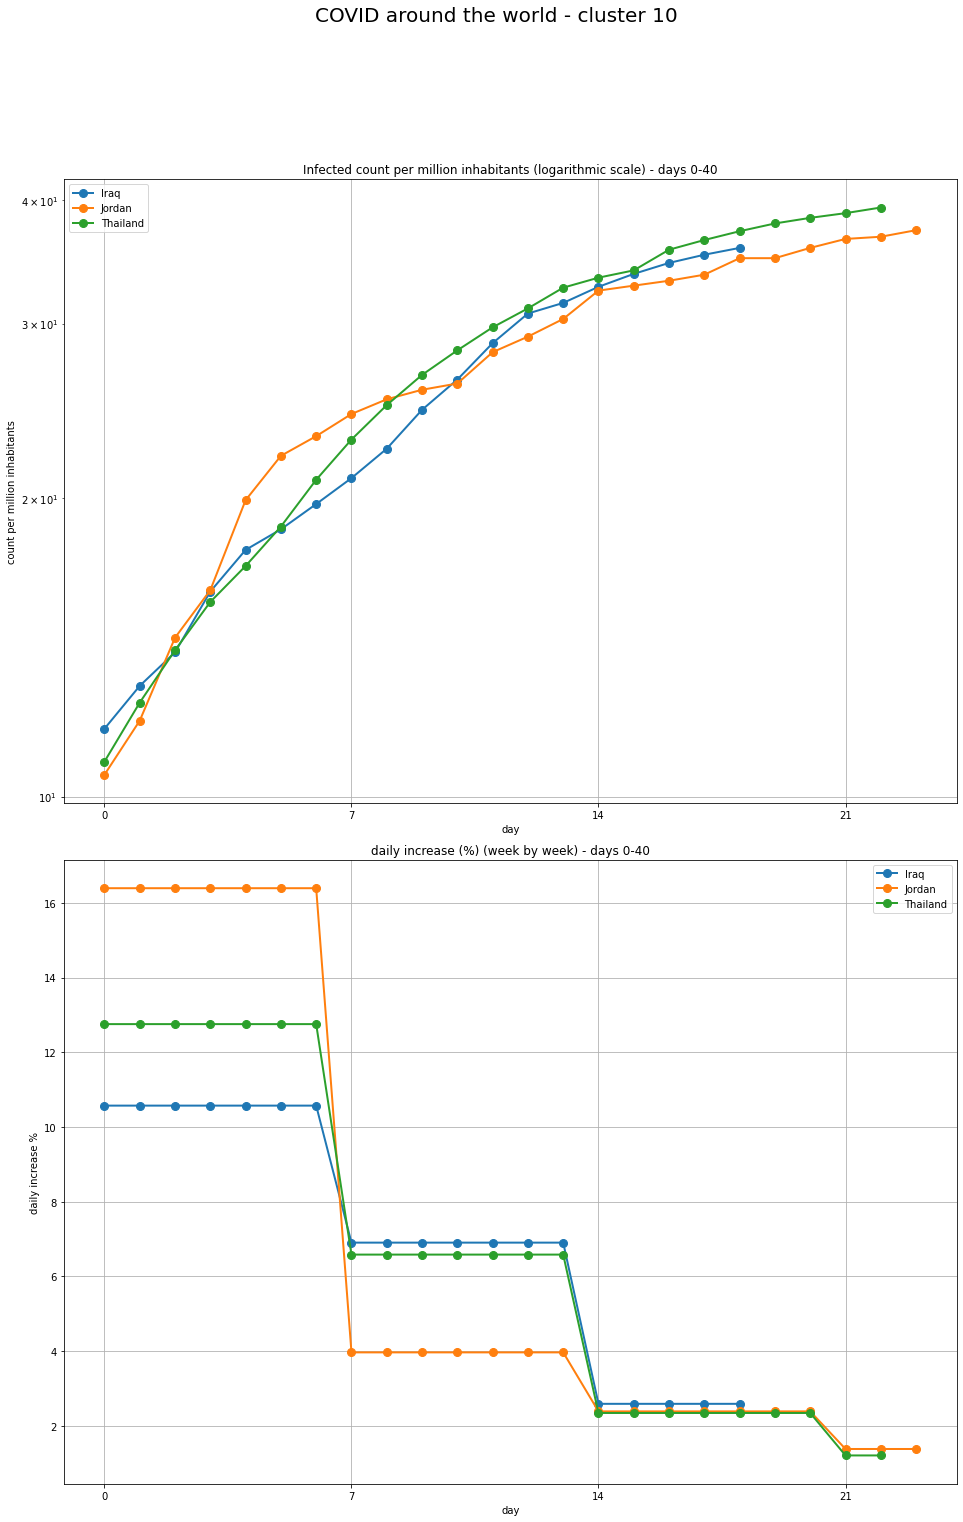

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_10/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


infected count  infected count per million current date  \
Singapore               3252                         570   2020-04-14   
Kuwait                  1355                         306   2020-04-14   
Burkina Faso             528                          25   2020-04-14   
Senegal                  299                          18   2020-04-14   
Taiwan                   393                          16   2020-04-14   

              daily increase % (smoothened over last 7 days)  \
Singapore                                              0.113   
Kuwait                                                 0.100   
Burkina Faso                                           0.045   
Senegal                                                0.037   
Taiwan                                                 0.007   

              doubles every ... days  \
Singapore                       6.45   
Kuwait                          7.24   
Burkina Faso                   15.58   
Senegal                        19.19   
Taiwan                         92.89   

              days since at least 1 per million infected  \
Singapore                                             61   
Kuwait                                                46   
Burkina Faso                                          16   
Senegal                                               14   
Taiwan                                                19   

              days between 1st case and at least 10 per million infected  \
Singapore                                                    21            
Kuwait                                                        4            
Burkina Faso                                                 19            
Senegal                                                      29            
Taiwan                                                       64            

              population (million)  density (people per km2)  \
Singapore                      5.7                    7894.0   
Kuwait                         4.4                     248.0   
Burkina Faso                  20.9                      75.0   
Senegal                       16.2                      82.0   
Taiwan                        23.6                     652.0   

              GDP per capita ($) (PPP)  ...  daily increase % week_3  \
Singapore                     105689.0  ...                    0.071   
Kuwait                         67891.0  ...                    0.050   
Burkina Faso                    2181.0  ...                      NaN   
Senegal                         4079.0  ...                      NaN   
Taiwan                         57214.0  ...                      NaN   

              infected count per million week_3  daily increase % week_4  \
Singapore                                  31.0                    0.084   
Kuwait                                     47.0                    0.074   
Burkina Faso                                NaN                      NaN   
Senegal                                     NaN                      NaN   
Taiwan                                      NaN                      NaN   

              infected count per million week_4  daily increase % week_5  \
Singapore                                  54.0                    0.105   
Kuwait                                     77.0                    0.150   
Burkina Faso                                NaN                      NaN   
Senegal                                     NaN                      NaN   
Taiwan                                      NaN                      NaN   

              infected count per million week_5  daily increase % week_6  \
Singapore                                 110.0                    0.068   
Kuwait                                    205.0                      NaN   
Burkina Faso                                NaN                      NaN   
Senegal                                     NaN                      NaN   
Taiwan             

Saved analysis to: output/covid/clustering/cluster_11/countries_comparison.xlsx


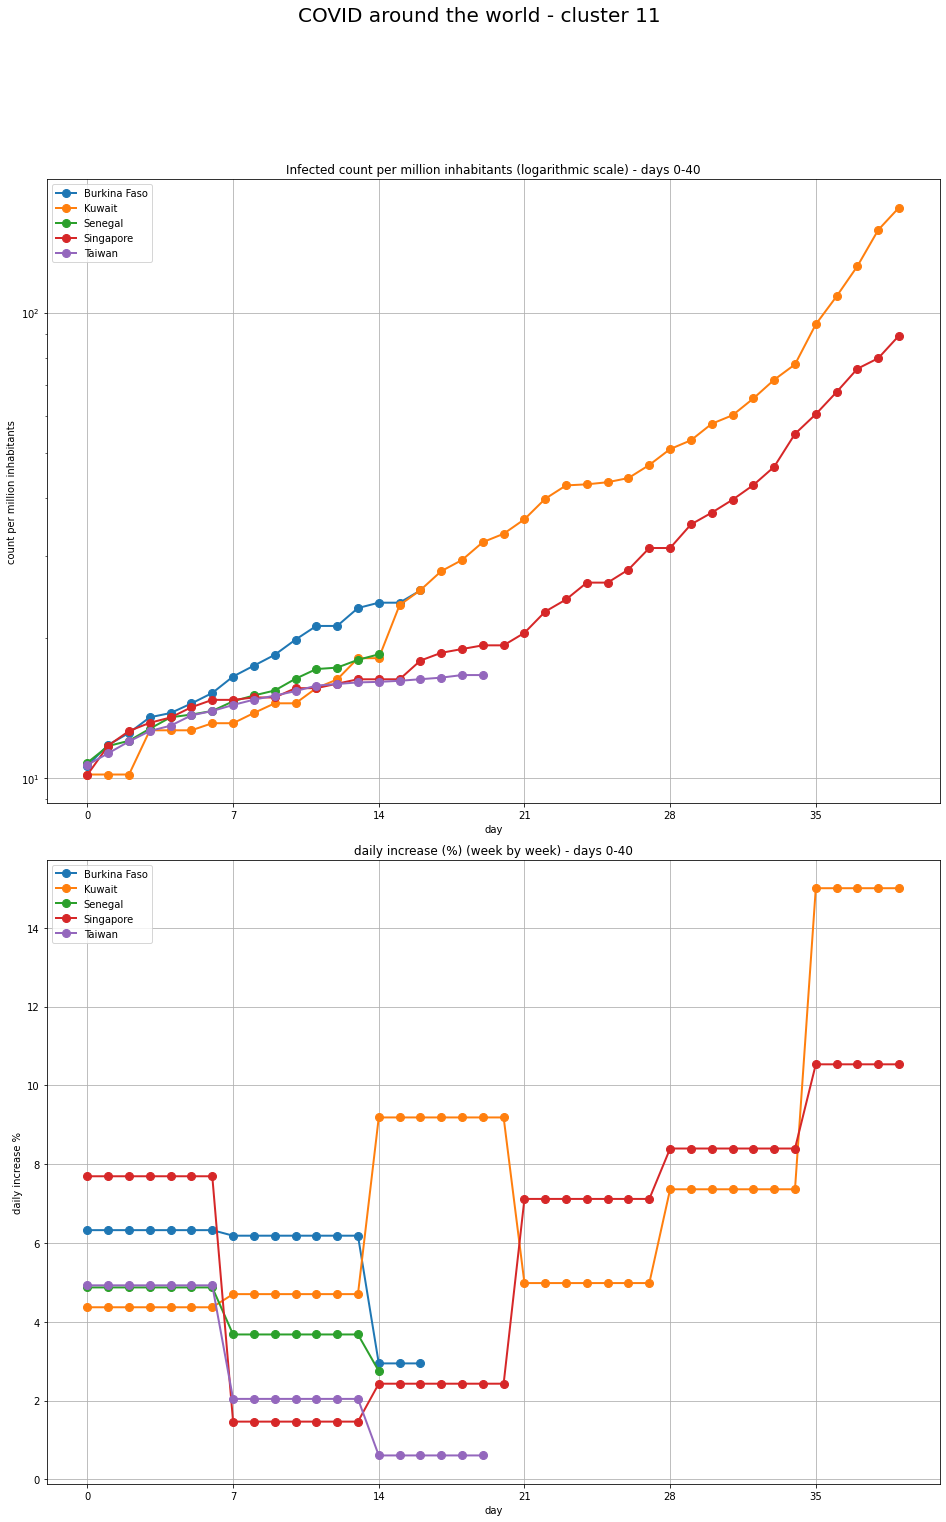

Saved analysis to: output/covid/clustering/cluster_11/covid_plot.jpeg


In [63]:
for cluster in sorted(clustering.unique()):
    if cluster == -1:
        continue
    cluster_countries = clustering[clustering == cluster]
    cluster_countries = [c for c in countries_for_clustering if c['country'] in cluster_countries.index]
    read_data_plot_countries(cluster_countries, 
                             output_folder=f'clustering/cluster_{cluster}/', 
                             min_count_per_million=10,
                             title=f'COVID around the world - cluster {cluster}'
                            )